In [1]:
import copy
import math
import random

%matplotlib inline
import mpld3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpld3.enable_notebook()

import numpy as np
from numpy import linalg as LA

from colorsys import hsv_to_rgb
from PIL import Image

In [2]:
class incrementalOffPolicy(object):
    def __init__(self, filename):
        actualMap = np.array(self.txt_to_obs_map('track1.txt'))
        reviseMap = np.empty(actualMap.shape)
        for i in range(0,len(actualMap)):
            reviseMap[i,] = actualMap[len(actualMap)-1-i,]
        self.map = copy.copy(np.transpose(reviseMap))
        
        self.start = np.empty([1,2],dtype=int)
        for i in range(0, self.map.shape[0]):
            if self.map[i,0] == 0:
                self.start = np.vstack((self.start,(i,0)))
        self.start = np.delete(self.start,(0), axis=0)
        
        self.finish = np.empty([1,2])
        for i in range(0, self.map.shape[1]):
            if self.map[self.map.shape[0]-1,i] == 0:
                self.finish = np.vstack((self.finish,(self.map.shape[0]-1,i)))
        self.finish = np.delete(self.finish, (0), axis=0)
        
        self.epsilon = 0.1
        self.initialVelocity = [0,0]
        self.allActions = np.array(((-1,-1), (-1,0), (-1,1), 
                                        (0,-1), (0,0), (0,1),
                                        (1,-1), (1,0), (1,1)))
        self.maxVelocity = 5
        self.minVelocity = 0
        self.numStates = self.map.size*(self.maxVelocity - self.minVelocity + 1)**2
        self.numActions = len(self.allActions)
        try:
            self.Q = np.random.rand(self.numStates,self.numActions)
#             self.Q = np.loadtxt('newq_2050000.txt')
        except:
            self.Q = np.empty(shape=(self.numStates,self.numActions))

        self.C = np.zeros(shape=(self.numStates,self.numActions))
        self.finishState = np.empty(shape=(1,4))

    def txt_to_obs_map(self, file_name):
        with open(file_name) as inputFile:
            return [[int(i) for i in line.strip().split('\t')] for line in inputFile]

    def behaviourPolicy(self, state):
        stateIndex = self.stateIndex(state[0,0:4])
        temp = copy.copy(policy[stateIndex])
#             print(stateIndex, temp, np.sum(temp))
        actionIndex = np.random.choice(9,1, p=temp.tolist())
        return actionIndex

    def targetPolicy1(self, previousState):
        if(previousState[1] ==0):
            xVel = 0
            yVel = 1
        elif (previousState[1] < 28):
            if(previousState[3] == 0):
                xVel = 0
                yVel = 1
            else:
                xVel = 0
                yVel = 0
        elif(previousState[1] >= 28):
            xVel = 1
            if(previousState[3] == 0):
                yVel = 0
            else:
                yVel = -1
        return np.array((xVel, yVel))
    
    def uniformTargetPolicy(self):
        policy = np.zeros(self.Q.shape)
        for i in range(0, self.Q.shape[0]):
            state = self.statesIndex2states(i)
            possibleActions = self.possibleActions(state[2], state[3])
            numPossibleActions = np.sum(possibleActions)
            policy[i] = 1.0*possibleActions/numPossibleActions
#         policy = np.random.uniform(0,1,(self.map.size*6*6,9))
#         for i in range(0, policy.shape[0]):
#             policy[i] = policy[i]/LA.norm(policy[i])
        return policy
    
    def greedyTargetPolicy(self, policy, episode):
        for i in range(0, episode.shape[0]):
            stateIndex = self.stateIndex(episode[i])
            state = copy.copy(self.statesIndex2states(stateIndex))
            possibleActions = self.possibleActions(state[2], state[3])
            numPossibleActions = np.sum(possibleActions)
            possibleActionsBool = possibleActions == 1
            maxQ = np.amax(self.Q[stateIndex, possibleActionsBool])
            for j in range(0,len(possibleActions)):
                if possibleActions[j] == 1:
                    if self.Q[stateIndex,j] == maxQ:
                        policy[stateIndex,j] = 1 - self.epsilon + self.epsilon/numPossibleActions
                    else:
                        policy[stateIndex,j] = self.epsilon/numPossibleActions
        return policy
    
    def updateTargetPolicy(self, policy, state):
        stateIndex = self.stateIndex(state)
        possibleActions = self.possibleActions(state[2], state[3])
        numPossibleActions = np.sum(possibleActions)
        if numPossibleActions==0:
            print("error: ", possibleActions)
        possibleActionsBool = possibleActions == 1
        maxQ = np.amax(self.Q[stateIndex, possibleActionsBool])
        greedyActions = self.Q[stateIndex,possibleActionsBool] == maxQ
        numGreedyActions = sum(greedyActions)
        for j in range(0,len(possibleActions)):
            policy[stateIndex,j] = 0
            if possibleActions[j] == 1:
                if self.Q[stateIndex,j] == maxQ:
                    policy[stateIndex,j] = (1.0 - self.epsilon)/numGreedyActions + self.epsilon/numPossibleActions
                else:
                    policy[stateIndex,j] = self.epsilon/numPossibleActions
        if np.sum(policy[stateIndex]) > 1.001 or np.sum(policy[stateIndex]) < 0.998:
            print(possibleActions)
            print(self.Q[stateIndex])
            print(possibleActionsBool,maxQ)
            print("state: ", state)
            print("policy: ", policy[stateIndex])
            print("gredyActions: ",greedyActions)
        return policy
    
    def possibleActions(self, velocity_x, velocity_y):
        possibleActions = np.ones(self.numActions)
#         print(possibleActions)
        for j in range(0, self.numActions):
            projVelocityX = velocity_x + self.allActions[j,0]
            projVelocityY = velocity_y + self.allActions[j,1]
            # print(projVelocityX, projVelocityY, self.allActions[j])
            if (projVelocityX>=self.minVelocity and projVelocityX<=self.maxVelocity and 
                projVelocityY>=self.minVelocity and projVelocityY<=self.maxVelocity):
                if projVelocityX==self.minVelocity and projVelocityY==self.minVelocity:
                    possibleActions[j] = 0
                else:
                    possibleActions[j] = 1
            else:
                possibleActions[j] = 0
#         print(possibleActions)
        return possibleActions

    def generateEpisode(self, policy):
        # print(self.start, self.start.shape)
        previousState = np.append(self.start[np.random.randint(self.start.shape[0])], [0,0])
        episode = np.zeros(shape=(1,6))
        while True:
            stateIndex = self.stateIndex(previousState)
            temp = copy.copy(policy[stateIndex])
#             print(stateIndex, temp, np.sum(temp))
            actionIndex = np.random.choice(9,1, p=temp.tolist())
            action = copy.copy(self.allActions[actionIndex])
            velocity_x = max(min((previousState[2]+action[0,0]),5),0)
            velocity_y = max(min((previousState[3]+action[0,1]),5),0)
            nextState = np.array(((previousState[0] + velocity_x),
                                    (previousState[1] + velocity_y), velocity_x, velocity_y))
            nextState = nextState.astype(int)
            intersection = self.projectedIntersection(previousState, nextState)
            if (intersection == 2):
                nextState = np.append(copy.copy(
                    self.start[np.random.randint(self.start.shape[0])]), [0,0])
#                 self.finishState[0,2] = copy.copy(velocity_x)
#                 self.finishState[0,3] = copy.copy(velocity_y)
                reward = -1
#                 break
            elif (intersection == 1):
                # episode = np.vstack((episode, np.append(nextState,np.array((0, action[0], action[1])))))
                self.finishState[0,2] = copy.copy(velocity_x)
                self.finishState[0,3] = copy.copy(velocity_y)
                break
            else:
                reward = -1
                
#             print(np.append(previousState,[reward, actionIndex]), episode.shape, stateIndex)

            if episode.shape[0] == 1:
                episode = np.append(previousState, [reward, actionIndex])
            else:
                episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
            previousState = copy.copy(nextState)
            
#         print(np.append(previousState, [reward, actionIndex]), episode.shape)
        episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
#         print(np.append(previousState,np.array((reward, actionIndex))))
        episode =np.vstack((episode, np.append(self.finishState, [reward, actionIndex])))
        return episode

    def projectedIntersection(self, previousState, nextState):
        projectedState = copy.copy(previousState[0:2])
#         print(projectedState)
        for i in range(0, max(nextState[2], nextState[3])+1):
            if(np.amin(np.sum(np.absolute(self.finish - np.array(projectedState[0:2])),axis=1)) ==0):
                self.finishState[0,0] = copy.copy(projectedState[0])
                self.finishState[0,1] = copy.copy(projectedState[1])
                return 1
            if(projectedState[0] >= self.map.shape[0]-1 or projectedState[1] >= self.map.shape[1]-1 or 
               self.map[projectedState[0],projectedState[1]] == 1):
                self.finishState[0,0] = copy.copy(projectedState[0])
                self.finishState[0,1] = copy.copy(projectedState[1])
                return 2
#             elif(self.map[projectedState[0],projectedState[1]] == 1):
#                 return 2
            projectedState[0] = min(projectedState[0]+1,nextState[0])
            projectedState[1] = min(projectedState[1]+1,nextState[1])
        return 3
    
    def stateIndex(self, currentState):
        velRange = (self.maxVelocity - self.minVelocity + 1)
        return int((velRange**2)*(currentState[1]*self.map.shape[0] + currentState[0]) + 6*currentState[3] + currentState[2] )
    
    def statesIndex2states(self, stateIndex):
        velRange = (mc.maxVelocity - mc.minVelocity + 1)
        velocity_x = (stateIndex%(velRange**2))%velRange
        velocity_y = (stateIndex%(velRange**2))/velRange
        stateY = int(int(stateIndex/velRange**2)/mc.map.shape[0])
        stateX = int(int(stateIndex/velRange**2)%mc.map.shape[0])
        return np.array((stateX, stateY, velocity_x, velocity_y))

In [3]:
mc = incrementalOffPolicy(filename = 'track1.txt')

In [4]:
gamma = 1.
count = 0
policyPI = mc.uniformTargetPolicy()
mc.epsilon = 0.1

In [ ]:
otherCount = 0
while count <= 7000000:
    episode = mc.generateEpisode(policyPI)
    # state : {x, y, vx, vy}
    # action-value function q(every state): vector of 36*9 elements for every grid
    G = 0.
#         W = 1.
    otherCount = 0
    for i in range(episode.shape[0]-2, -1, -1):
        state = copy.copy(episode[i])
        G = gamma*G + episode[i,4]
        ind1 = mc.stateIndex(episode[i])
        ind2 =  int(copy.copy(episode[i,5]))
        mc.C[ind1,ind2] += 1
        mc.Q[ind1,ind2] = mc.Q[ind1,ind2] + (1./mc.C[ind1,ind2])*(G - mc.Q[ind1,ind2])
#             W = W*policyPI[ind1,ind2]*np.sum(mc.possibleActions(state[2], state[3]))/np.sum(policyPI[ind1])
        policyPI = mc.updateTargetPolicy(policyPI, state)
        otherCount += 1
    if otherCount > 100:
        print("cnt:", count, "otherC:", otherCount,"  state:", state)
    count += 1
#     if (count%4000000 ==0 and mc.epsilon >0.05):
#         mc.epsilon =0
    if (count%1000 == 0):
        print("cnt:", count, "otherC:", otherCount,"  state:", state)
    if (count % 500000 == 0):
        np.savetxt('oldq_%d.txt'% count, mc.Q, fmt='%.18e', delimiter=' ', newline='\n')

np.savetxt('oldQ.txt', mc.Q, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt('oldN.txt', mc.C, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt('oldPolicy.txt', policyPI, fmt='%.18e', delimiter=' ', newline='\n')

cnt: 6434313 otherC: 447   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6434314 otherC: 109   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6434318 otherC: 151   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6434320 otherC: 689   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6434321 otherC: 157   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6434322 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434329 otherC: 193   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6434330 otherC: 271   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6434331 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434333 otherC: 182   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6434335 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434336 otherC: 299   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434337 otherC: 152   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6434339 otherC: 135   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6434341 otherC: 202   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434343 otherC: 163   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6434346 otherC: 321   state: [ 3.  

cnt: 6434607 otherC: 155   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6434608 otherC: 138   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6434609 otherC: 436   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434610 otherC: 180   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434611 otherC: 123   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6434612 otherC: 106   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6434619 otherC: 116   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6434623 otherC: 215   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6434626 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434627 otherC: 286   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434629 otherC: 115   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6434632 otherC: 312   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6434633 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434635 otherC: 164   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6434638 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434639 otherC: 287   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434640 otherC: 622   state: [ 5.  

cnt: 6434906 otherC: 164   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6434911 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434912 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434913 otherC: 164   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6434916 otherC: 155   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6434920 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6434921 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6434923 otherC: 303   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434925 otherC: 206   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6434928 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6434930 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434932 otherC: 177   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6434933 otherC: 235   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6434937 otherC: 319   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6434938 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6434939 otherC: 254   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6434940 otherC: 155   state: [ 7.  

cnt: 6435239 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435241 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435244 otherC: 176   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6435246 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435247 otherC: 159   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435248 otherC: 124   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6435252 otherC: 407   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6435256 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435257 otherC: 108   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6435262 otherC: 108   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6435263 otherC: 303   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435264 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6435265 otherC: 464   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6435266 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6435267 otherC: 200   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6435276 otherC: 391   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6435279 otherC: 101   state: [ 4.  

cnt: 6435554 otherC: 175   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6435555 otherC: 498   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6435556 otherC: 194   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6435557 otherC: 186   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6435558 otherC: 238   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6435561 otherC: 291   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6435564 otherC: 167   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6435566 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435568 otherC: 212   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6435569 otherC: 143   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6435570 otherC: 251   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435573 otherC: 325   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6435574 otherC: 317   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6435575 otherC: 163   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6435579 otherC: 316   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6435580 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435582 otherC: 259   state: [ 7.  

cnt: 6435868 otherC: 221   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6435869 otherC: 194   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6435870 otherC: 160   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6435874 otherC: 171   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6435876 otherC: 146   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6435877 otherC: 133   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6435880 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6435882 otherC: 207   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6435883 otherC: 199   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6435888 otherC: 198   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6435889 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6435890 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435894 otherC: 208   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435896 otherC: 297   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6435897 otherC: 164   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6435900 otherC: 182   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6435901 otherC: 456   state: [ 4.  

cnt: 6436137 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6436139 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436142 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436146 otherC: 139   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6436148 otherC: 147   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436157 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436158 otherC: 141   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6436159 otherC: 266   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6436163 otherC: 168   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6436164 otherC: 342   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6436166 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436167 otherC: 168   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436171 otherC: 319   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6436172 otherC: 186   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6436175 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6436177 otherC: 184   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6436178 otherC: 165   state: [ 5.  

cnt: 6436449 otherC: 140   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436453 otherC: 382   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6436456 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436458 otherC: 435   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436459 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436460 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436465 otherC: 283   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436467 otherC: 750   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436468 otherC: 330   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6436470 otherC: 210   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6436471 otherC: 197   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6436472 otherC: 304   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6436476 otherC: 485   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6436479 otherC: 258   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436484 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436485 otherC: 152   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6436487 otherC: 112   state: [ 8.  

cnt: 6436743 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436746 otherC: 159   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6436747 otherC: 218   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436748 otherC: 175   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6436749 otherC: 201   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6436752 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436753 otherC: 324   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6436754 otherC: 131   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436757 otherC: 174   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436759 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436765 otherC: 161   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6436768 otherC: 156   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6436769 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6436771 otherC: 295   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6436772 otherC: 118   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6436774 otherC: 388   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6436775 otherC: 106   state: [ 3.  

cnt: 6437016 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6437018 otherC: 332   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437019 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437020 otherC: 102   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6437023 otherC: 363   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437026 otherC: 264   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6437029 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437031 otherC: 113   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6437032 otherC: 363   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6437033 otherC: 239   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437035 otherC: 462   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437038 otherC: 103   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6437040 otherC: 213   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437041 otherC: 348   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437042 otherC: 104   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6437044 otherC: 159   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6437048 otherC: 245   state: [ 5.  

cnt: 6437319 otherC: 265   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437320 otherC: 365   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6437323 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437325 otherC: 173   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437327 otherC: 102   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6437328 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437330 otherC: 195   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6437333 otherC: 207   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6437336 otherC: 105   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6437338 otherC: 197   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437339 otherC: 210   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6437344 otherC: 116   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437347 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437348 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437350 otherC: 124   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6437352 otherC: 244   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6437355 otherC: 408   state: [ 3.  

cnt: 6437621 otherC: 426   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6437624 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437627 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437629 otherC: 257   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437638 otherC: 438   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6437639 otherC: 156   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437641 otherC: 381   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6437642 otherC: 390   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437645 otherC: 202   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6437647 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437649 otherC: 319   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6437650 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437651 otherC: 221   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437653 otherC: 225   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6437654 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6437657 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437658 otherC: 204   state: [ 6.  

cnt: 6437927 otherC: 178   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6437930 otherC: 193   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6437931 otherC: 330   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6437936 otherC: 144   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437941 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437944 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437945 otherC: 311   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437946 otherC: 445   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437949 otherC: 320   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437950 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6437953 otherC: 270   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6437954 otherC: 329   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437955 otherC: 323   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6437956 otherC: 175   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6437959 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6437961 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6437962 otherC: 350   state: [ 3.  

cnt: 6438217 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6438219 otherC: 119   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6438221 otherC: 179   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6438223 otherC: 423   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438225 otherC: 208   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6438227 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6438231 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6438233 otherC: 162   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6438235 otherC: 255   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6438236 otherC: 372   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6438237 otherC: 248   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6438239 otherC: 360   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6438241 otherC: 161   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6438247 otherC: 149   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6438248 otherC: 241   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6438249 otherC: 112   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6438250 otherC: 165   state: [ 3.  

cnt: 6438501 otherC: 171   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6438502 otherC: 249   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6438503 otherC: 192   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6438506 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6438508 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6438509 otherC: 110   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6438510 otherC: 250   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6438512 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438517 otherC: 201   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6438518 otherC: 175   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6438519 otherC: 202   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6438521 otherC: 136   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6438523 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438526 otherC: 208   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6438528 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6438530 otherC: 132   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6438533 otherC: 177   state: [ 4.  

cnt: 6438798 otherC: 354   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6438799 otherC: 286   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6438800 otherC: 304   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6438803 otherC: 260   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6438806 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6438812 otherC: 259   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6438814 otherC: 186   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6438819 otherC: 165   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6438822 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6438823 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6438824 otherC: 361   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6438825 otherC: 284   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438826 otherC: 158   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6438829 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438832 otherC: 286   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6438836 otherC: 445   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6438838 otherC: 260   state: [ 5.  

cnt: 6439085 otherC: 140   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6439088 otherC: 326   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439089 otherC: 151   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6439090 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6439091 otherC: 133   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6439092 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6439094 otherC: 258   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6439095 otherC: 193   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6439096 otherC: 147   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6439097 otherC: 251   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6439102 otherC: 298   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439110 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6439115 otherC: 551   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6439118 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6439120 otherC: 139   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6439123 otherC: 175   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439124 otherC: 325   state: [ 5.  

cnt: 6439387 otherC: 370   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6439390 otherC: 127   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439391 otherC: 230   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439392 otherC: 212   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6439396 otherC: 254   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6439397 otherC: 115   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6439401 otherC: 339   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439403 otherC: 724   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6439406 otherC: 314   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6439407 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439416 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6439417 otherC: 180   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6439420 otherC: 258   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439422 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6439425 otherC: 517   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6439426 otherC: 297   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439433 otherC: 102   state: [ 5.  

cnt: 6439727 otherC: 147   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439728 otherC: 121   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6439730 otherC: 153   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6439731 otherC: 661   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6439734 otherC: 457   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6439736 otherC: 246   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6439737 otherC: 194   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6439740 otherC: 194   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6439741 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6439742 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6439744 otherC: 284   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6439745 otherC: 311   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6439746 otherC: 160   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6439747 otherC: 928   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439748 otherC: 333   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6439749 otherC: 274   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6439750 otherC: 216   state: [ 8.  

cnt: 6440002 otherC: 421   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6440004 otherC: 139   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440006 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440007 otherC: 106   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6440008 otherC: 249   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440013 otherC: 329   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6440015 otherC: 117   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6440018 otherC: 239   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6440020 otherC: 486   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6440021 otherC: 145   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6440022 otherC: 130   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6440025 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440026 otherC: 102   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6440029 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440031 otherC: 210   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6440033 otherC: 251   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6440034 otherC: 163   state: [ 7.  

cnt: 6440288 otherC: 573   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440290 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440291 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440293 otherC: 758   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6440296 otherC: 137   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440297 otherC: 200   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6440298 otherC: 115   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6440299 otherC: 177   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440300 otherC: 113   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6440304 otherC: 147   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6440307 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440308 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6440309 otherC: 216   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440311 otherC: 327   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440312 otherC: 550   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6440314 otherC: 120   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6440315 otherC: 196   state: [ 7.  

cnt: 6440593 otherC: 144   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440600 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440603 otherC: 135   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6440606 otherC: 118   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6440607 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440608 otherC: 285   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6440610 otherC: 479   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6440612 otherC: 497   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6440613 otherC: 438   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440616 otherC: 293   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6440621 otherC: 188   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6440629 otherC: 106   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6440631 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440633 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440634 otherC: 299   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440635 otherC: 174   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6440639 otherC: 304   state: [ 8.  

cnt: 6440929 otherC: 243   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6440930 otherC: 284   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6440931 otherC: 138   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6440932 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6440936 otherC: 157   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440937 otherC: 320   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6440940 otherC: 124   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6440944 otherC: 579   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6440945 otherC: 167   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440949 otherC: 187   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6440954 otherC: 104   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440958 otherC: 161   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6440961 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440962 otherC: 322   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440963 otherC: 289   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6440968 otherC: 371   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6440969 otherC: 186   state: [ 3.  

cnt: 6441223 otherC: 193   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6441226 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6441232 otherC: 234   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441233 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441235 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441236 otherC: 139   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6441239 otherC: 168   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441241 otherC: 101   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441242 otherC: 223   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441248 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6441251 otherC: 324   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6441252 otherC: 184   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6441253 otherC: 241   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6441259 otherC: 329   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6441260 otherC: 127   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6441262 otherC: 232   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441264 otherC: 310   state: [ 3.  

cnt: 6441547 otherC: 303   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6441548 otherC: 148   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6441550 otherC: 142   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6441551 otherC: 211   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6441553 otherC: 117   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6441554 otherC: 263   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6441555 otherC: 210   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6441556 otherC: 203   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441562 otherC: 545   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441564 otherC: 218   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6441566 otherC: 327   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6441568 otherC: 168   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6441572 otherC: 170   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441578 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441579 otherC: 382   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441581 otherC: 235   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441587 otherC: 110   state: [ 6.  

cnt: 6441869 otherC: 308   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6441871 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441876 otherC: 250   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6441877 otherC: 296   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6441879 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6441880 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6441881 otherC: 396   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6441882 otherC: 103   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6441884 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6441887 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6441892 otherC: 167   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6441894 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6441895 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6441896 otherC: 228   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6441897 otherC: 384   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6441898 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6441899 otherC: 461   state: [ 7.  

cnt: 6442175 otherC: 564   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442176 otherC: 205   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6442177 otherC: 108   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6442179 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442181 otherC: 190   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442185 otherC: 196   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6442188 otherC: 546   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442192 otherC: 165   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6442193 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6442197 otherC: 224   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6442198 otherC: 138   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6442200 otherC: 176   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6442201 otherC: 615   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442203 otherC: 218   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6442205 otherC: 115   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6442206 otherC: 148   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6442207 otherC: 261   state: [ 7.  

cnt: 6442454 otherC: 456   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6442455 otherC: 239   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442456 otherC: 249   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442458 otherC: 150   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6442459 otherC: 214   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6442462 otherC: 237   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6442463 otherC: 392   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6442467 otherC: 148   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6442469 otherC: 164   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6442470 otherC: 393   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6442473 otherC: 225   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442475 otherC: 282   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442476 otherC: 166   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6442477 otherC: 163   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6442478 otherC: 225   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6442479 otherC: 129   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6442485 otherC: 189   state: [ 3.  

cnt: 6442740 otherC: 394   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442741 otherC: 491   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6442745 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6442746 otherC: 194   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6442747 otherC: 138   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6442749 otherC: 173   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6442751 otherC: 196   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6442752 otherC: 238   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6442753 otherC: 175   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6442757 otherC: 153   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6442758 otherC: 139   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6442759 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6442762 otherC: 345   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6442763 otherC: 177   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6442764 otherC: 102   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6442766 otherC: 157   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6442768 otherC: 326   state: [ 5.  

cnt: 6443017 otherC: 327   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443018 otherC: 167   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6443019 otherC: 210   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443021 otherC: 316   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6443022 otherC: 191   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443025 otherC: 291   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6443031 otherC: 401   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443032 otherC: 237   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6443033 otherC: 145   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6443034 otherC: 534   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443037 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443042 otherC: 223   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443044 otherC: 555   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443045 otherC: 220   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443046 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443047 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443051 otherC: 365   state: [ 6.  

cnt: 6443304 otherC: 166   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443306 otherC: 127   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6443307 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443312 otherC: 379   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6443313 otherC: 152   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443315 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443316 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443317 otherC: 630   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6443318 otherC: 300   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443319 otherC: 117   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443320 otherC: 335   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6443322 otherC: 176   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443323 otherC: 365   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443325 otherC: 148   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6443328 otherC: 209   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443330 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6443331 otherC: 287   state: [ 5.  

cnt: 6443571 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443572 otherC: 304   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6443574 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6443577 otherC: 248   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6443578 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443581 otherC: 213   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6443582 otherC: 176   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443585 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6443586 otherC: 247   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6443588 otherC: 278   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443591 otherC: 324   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443592 otherC: 140   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6443595 otherC: 287   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6443596 otherC: 166   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6443599 otherC: 177   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6443602 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443603 otherC: 116   state: [ 8.  

cnt: 6443857 otherC: 273   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6443859 otherC: 347   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443860 otherC: 760   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443862 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6443865 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443866 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6443869 otherC: 222   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6443870 otherC: 199   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6443871 otherC: 250   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6443872 otherC: 364   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6443873 otherC: 612   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6443876 otherC: 150   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443877 otherC: 262   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6443878 otherC: 205   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6443879 otherC: 138   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6443880 otherC: 233   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6443883 otherC: 343   state: [ 8.  

cnt: 6444165 otherC: 198   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6444167 otherC: 276   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6444172 otherC: 144   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6444173 otherC: 157   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6444175 otherC: 135   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444181 otherC: 332   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6444182 otherC: 152   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6444183 otherC: 375   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6444185 otherC: 128   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6444186 otherC: 139   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6444187 otherC: 107   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6444189 otherC: 369   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6444194 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444198 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6444200 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444201 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444202 otherC: 227   state: [ 5.  

cnt: 6444458 otherC: 231   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444460 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444461 otherC: 123   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6444462 otherC: 259   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6444465 otherC: 175   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444470 otherC: 214   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6444472 otherC: 107   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444475 otherC: 224   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444476 otherC: 101   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6444477 otherC: 264   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6444481 otherC: 174   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6444483 otherC: 367   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6444485 otherC: 183   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6444487 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6444488 otherC: 229   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6444490 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444494 otherC: 348   state: [ 4.  

cnt: 6444789 otherC: 166   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6444790 otherC: 101   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6444792 otherC: 127   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6444798 otherC: 309   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6444799 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444802 otherC: 329   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6444805 otherC: 166   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6444806 otherC: 289   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6444809 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444810 otherC: 282   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6444817 otherC: 204   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6444818 otherC: 166   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6444819 otherC: 214   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6444826 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6444828 otherC: 330   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6444829 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6444835 otherC: 124   state: [ 8.  

cnt: 6445108 otherC: 281   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445110 otherC: 207   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445113 otherC: 234   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6445118 otherC: 225   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445123 otherC: 236   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6445126 otherC: 334   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6445129 otherC: 303   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6445133 otherC: 123   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6445134 otherC: 147   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445135 otherC: 154   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6445137 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6445141 otherC: 200   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6445142 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445143 otherC: 223   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6445144 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445147 otherC: 265   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6445154 otherC: 240   state: [ 3.  

cnt: 6445435 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6445437 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6445438 otherC: 265   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6445440 otherC: 365   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445441 otherC: 153   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6445442 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445446 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445447 otherC: 110   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6445448 otherC: 228   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6445449 otherC: 168   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445453 otherC: 155   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6445456 otherC: 118   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6445457 otherC: 217   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6445459 otherC: 238   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445462 otherC: 174   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445464 otherC: 367   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6445465 otherC: 117   state: [ 4.  

cnt: 6445757 otherC: 187   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445761 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6445762 otherC: 236   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6445763 otherC: 199   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6445764 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6445765 otherC: 289   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445766 otherC: 692   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445768 otherC: 133   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6445769 otherC: 181   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6445770 otherC: 141   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6445775 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6445776 otherC: 229   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445778 otherC: 279   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6445779 otherC: 332   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6445780 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6445781 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6445782 otherC: 265   state: [ 3.  

cnt: 6446027 otherC: 230   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446028 otherC: 309   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446029 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446030 otherC: 255   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446031 otherC: 276   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6446034 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446045 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446047 otherC: 277   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446049 otherC: 142   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6446050 otherC: 270   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446054 otherC: 265   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446055 otherC: 290   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446058 otherC: 114   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446061 otherC: 317   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446065 otherC: 253   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446070 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446075 otherC: 107   state: [ 7.  

cnt: 6446343 otherC: 174   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446347 otherC: 176   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446352 otherC: 197   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446358 otherC: 261   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446359 otherC: 136   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6446360 otherC: 319   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446364 otherC: 109   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446366 otherC: 200   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446369 otherC: 215   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6446370 otherC: 103   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6446372 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446373 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446376 otherC: 144   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6446377 otherC: 177   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6446378 otherC: 342   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446379 otherC: 239   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446385 otherC: 302   state: [ 3.  

cnt: 6446653 otherC: 187   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446660 otherC: 284   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6446661 otherC: 102   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446664 otherC: 234   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6446670 otherC: 481   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446673 otherC: 497   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6446674 otherC: 124   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446675 otherC: 178   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6446676 otherC: 543   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6446679 otherC: 198   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6446680 otherC: 106   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6446684 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446685 otherC: 112   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6446686 otherC: 369   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446687 otherC: 208   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6446688 otherC: 354   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6446689 otherC: 382   state: [ 7.  

cnt: 6446912 otherC: 192   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446914 otherC: 160   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6446917 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446919 otherC: 217   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446923 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446924 otherC: 354   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6446927 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6446929 otherC: 355   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6446931 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446932 otherC: 110   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6446938 otherC: 251   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6446941 otherC: 313   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6446942 otherC: 117   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6446943 otherC: 255   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6446948 otherC: 107   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6446951 otherC: 194   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6446953 otherC: 109   state: [ 5.  

cnt: 6447222 otherC: 393   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447224 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447225 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447229 otherC: 494   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6447230 otherC: 258   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447232 otherC: 463   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447233 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447238 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447239 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447242 otherC: 176   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6447245 otherC: 107   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447247 otherC: 116   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6447253 otherC: 463   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447254 otherC: 416   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6447255 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447256 otherC: 142   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447257 otherC: 210   state: [ 6.  

cnt: 6447504 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6447506 otherC: 119   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6447507 otherC: 120   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6447509 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447510 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447513 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6447514 otherC: 454   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6447516 otherC: 193   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447524 otherC: 368   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447526 otherC: 289   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447527 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447530 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447535 otherC: 101   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6447539 otherC: 165   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6447543 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6447544 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447545 otherC: 251   state: [ 4.  

cnt: 6447825 otherC: 116   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6447827 otherC: 148   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6447828 otherC: 177   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447829 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6447832 otherC: 220   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6447834 otherC: 139   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6447836 otherC: 177   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6447837 otherC: 236   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6447841 otherC: 293   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6447844 otherC: 210   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6447845 otherC: 264   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447847 otherC: 140   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6447848 otherC: 154   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6447850 otherC: 227   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447853 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6447856 otherC: 179   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6447857 otherC: 163   state: [ 3.  

cnt: 6448126 otherC: 227   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6448129 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448130 otherC: 115   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6448132 otherC: 135   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6448133 otherC: 156   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6448135 otherC: 141   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6448137 otherC: 211   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6448138 otherC: 570   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448141 otherC: 295   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448143 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448144 otherC: 120   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6448151 otherC: 555   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6448160 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448161 otherC: 421   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6448164 otherC: 345   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6448166 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448168 otherC: 223   state: [ 7.  

cnt: 6448440 otherC: 321   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6448442 otherC: 189   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6448444 otherC: 159   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448450 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6448456 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6448458 otherC: 230   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448462 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448468 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448469 otherC: 265   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6448470 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448471 otherC: 142   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6448472 otherC: 151   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6448473 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448475 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448476 otherC: 129   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6448480 otherC: 200   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6448482 otherC: 247   state: [ 7.  

cnt: 6448742 otherC: 230   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6448745 otherC: 247   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448746 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448747 otherC: 249   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448753 otherC: 208   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6448754 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448755 otherC: 137   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6448756 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6448758 otherC: 115   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6448761 otherC: 225   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448762 otherC: 234   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6448765 otherC: 106   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6448772 otherC: 252   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6448773 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6448776 otherC: 182   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6448777 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6448779 otherC: 113   state: [ 8.  

cnt: 6449044 otherC: 191   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6449045 otherC: 166   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6449046 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6449052 otherC: 141   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6449054 otherC: 138   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449055 otherC: 212   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6449056 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449058 otherC: 130   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449059 otherC: 145   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6449060 otherC: 105   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6449061 otherC: 290   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6449062 otherC: 108   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6449066 otherC: 234   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449067 otherC: 280   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449068 otherC: 342   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449069 otherC: 195   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6449070 otherC: 343   state: [ 5.  

cnt: 6449378 otherC: 218   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6449382 otherC: 259   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449385 otherC: 102   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6449390 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6449393 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449394 otherC: 116   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6449395 otherC: 162   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6449399 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449402 otherC: 393   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449403 otherC: 878   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449404 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6449405 otherC: 125   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6449407 otherC: 297   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6449409 otherC: 282   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449412 otherC: 110   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6449417 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6449422 otherC: 191   state: [ 3.  

cnt: 6449699 otherC: 334   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6449700 otherC: 289   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449702 otherC: 181   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6449705 otherC: 200   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6449706 otherC: 326   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6449707 otherC: 155   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6449710 otherC: 222   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449713 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449714 otherC: 394   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449717 otherC: 179   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6449723 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6449725 otherC: 682   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449726 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6449728 otherC: 395   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6449729 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6449730 otherC: 139   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449731 otherC: 260   state: [ 5.  

cnt: 6449982 otherC: 340   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6449985 otherC: 324   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6449987 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449990 otherC: 293   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6449992 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6449994 otherC: 114   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6449998 otherC: 415   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6450000 otherC: 99   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6450001 otherC: 120   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6450002 otherC: 179   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6450006 otherC: 110   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6450008 otherC: 133   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6450009 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6450011 otherC: 234   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6450014 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6450015 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450016 otherC: 168   state: [ 5.  0

cnt: 6450267 otherC: 142   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6450268 otherC: 360   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450271 otherC: 142   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450272 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450273 otherC: 196   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450274 otherC: 239   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450282 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450285 otherC: 169   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450287 otherC: 141   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6450288 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6450289 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6450291 otherC: 200   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6450292 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6450293 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450294 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450295 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450296 otherC: 139   state: [ 7.  

cnt: 6450584 otherC: 326   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450585 otherC: 199   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6450590 otherC: 417   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450591 otherC: 275   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6450598 otherC: 231   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450599 otherC: 128   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6450602 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450603 otherC: 202   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6450606 otherC: 448   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6450609 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6450616 otherC: 238   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6450618 otherC: 262   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450621 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450622 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450625 otherC: 153   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6450627 otherC: 255   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6450631 otherC: 247   state: [ 3.  

cnt: 6450914 otherC: 315   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450916 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6450917 otherC: 298   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6450920 otherC: 219   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6450922 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6450925 otherC: 276   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6450929 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450932 otherC: 179   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6450933 otherC: 165   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450934 otherC: 136   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6450938 otherC: 369   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6450945 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450949 otherC: 168   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6450950 otherC: 196   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450951 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6450952 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6450954 otherC: 109   state: [ 7.  

cnt: 6451183 otherC: 143   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451188 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6451191 otherC: 227   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6451192 otherC: 109   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6451197 otherC: 178   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6451200 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6451205 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6451209 otherC: 282   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451212 otherC: 138   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6451213 otherC: 202   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6451217 otherC: 222   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6451219 otherC: 108   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6451220 otherC: 220   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451221 otherC: 231   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6451225 otherC: 276   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6451226 otherC: 223   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6451231 otherC: 178   state: [ 4.  

cnt: 6451468 otherC: 333   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6451470 otherC: 671   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451472 otherC: 103   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6451475 otherC: 218   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6451476 otherC: 206   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6451477 otherC: 210   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6451481 otherC: 143   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6451490 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6451493 otherC: 111   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6451494 otherC: 215   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6451496 otherC: 154   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6451497 otherC: 192   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6451501 otherC: 143   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6451506 otherC: 179   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6451507 otherC: 290   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6451508 otherC: 143   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6451510 otherC: 107   state: [ 3.  

cnt: 6451787 otherC: 137   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6451790 otherC: 413   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451793 otherC: 413   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6451797 otherC: 214   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6451799 otherC: 265   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6451800 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6451801 otherC: 124   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6451803 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451805 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6451806 otherC: 122   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6451807 otherC: 109   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6451808 otherC: 114   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6451810 otherC: 111   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6451813 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6451814 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6451815 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6451816 otherC: 114   state: [ 4.  

cnt: 6452079 otherC: 198   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452081 otherC: 317   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6452082 otherC: 202   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452084 otherC: 163   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452085 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452087 otherC: 291   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6452088 otherC: 178   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452089 otherC: 143   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6452090 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452091 otherC: 331   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6452094 otherC: 266   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6452096 otherC: 213   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452098 otherC: 143   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452106 otherC: 194   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6452108 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452109 otherC: 159   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6452110 otherC: 111   state: [ 4.  

cnt: 6452359 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452360 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452362 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452364 otherC: 397   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452366 otherC: 165   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6452367 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452369 otherC: 102   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6452370 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452372 otherC: 433   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452373 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452374 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452378 otherC: 341   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452379 otherC: 143   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452385 otherC: 103   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6452387 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452392 otherC: 212   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6452393 otherC: 204   state: [ 5.  

cnt: 6452665 otherC: 333   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452666 otherC: 267   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452667 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452668 otherC: 213   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452669 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452673 otherC: 203   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452674 otherC: 190   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452675 otherC: 131   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6452679 otherC: 186   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452680 otherC: 228   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452681 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452682 otherC: 422   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452689 otherC: 226   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452692 otherC: 183   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452693 otherC: 189   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6452694 otherC: 190   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6452696 otherC: 120   state: [ 4.  

cnt: 6452940 otherC: 276   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452942 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452944 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452945 otherC: 205   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6452947 otherC: 229   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6452949 otherC: 237   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6452951 otherC: 206   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452952 otherC: 213   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6452955 otherC: 173   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6452956 otherC: 154   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6452957 otherC: 166   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6452962 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6452964 otherC: 122   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6452965 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6452967 otherC: 230   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6452970 otherC: 290   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6452972 otherC: 216   state: [ 5.  

cnt: 6453215 otherC: 172   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453218 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453219 otherC: 123   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453220 otherC: 242   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453222 otherC: 198   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453224 otherC: 139   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453226 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453230 otherC: 266   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453231 otherC: 233   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453234 otherC: 210   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453236 otherC: 151   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453238 otherC: 288   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453239 otherC: 370   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6453240 otherC: 479   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453242 otherC: 340   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453245 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6453249 otherC: 297   state: [ 4.  

cnt: 6453497 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453507 otherC: 197   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6453509 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6453511 otherC: 116   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453512 otherC: 156   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6453515 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453518 otherC: 131   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6453520 otherC: 162   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453521 otherC: 158   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6453525 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453527 otherC: 204   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453533 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453534 otherC: 174   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453538 otherC: 112   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6453539 otherC: 127   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453540 otherC: 171   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6453541 otherC: 157   state: [ 3.  

cnt: 6453786 otherC: 346   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6453787 otherC: 257   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6453789 otherC: 493   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453790 otherC: 302   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453792 otherC: 555   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453794 otherC: 341   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6453797 otherC: 275   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6453802 otherC: 241   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453803 otherC: 371   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453804 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6453805 otherC: 248   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6453806 otherC: 127   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6453810 otherC: 125   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6453811 otherC: 239   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6453813 otherC: 202   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6453814 otherC: 258   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6453817 otherC: 142   state: [ 6.  

cnt: 6454074 otherC: 392   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454076 otherC: 410   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454077 otherC: 173   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6454080 otherC: 289   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454086 otherC: 195   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454089 otherC: 333   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454092 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454093 otherC: 222   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6454094 otherC: 463   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454097 otherC: 326   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454098 otherC: 127   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454103 otherC: 264   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454104 otherC: 231   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6454106 otherC: 219   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6454107 otherC: 279   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6454110 otherC: 108   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454113 otherC: 208   state: [ 7.  

cnt: 6454338 otherC: 156   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6454339 otherC: 460   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454340 otherC: 180   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454341 otherC: 133   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454343 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454351 otherC: 152   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6454353 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454355 otherC: 239   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6454359 otherC: 281   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6454361 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454362 otherC: 159   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6454365 otherC: 225   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6454366 otherC: 107   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6454367 otherC: 147   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454368 otherC: 347   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6454370 otherC: 267   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6454371 otherC: 103   state: [ 6.  

cnt: 6454648 otherC: 365   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6454651 otherC: 185   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6454652 otherC: 154   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454657 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454658 otherC: 160   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454659 otherC: 102   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6454662 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454663 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6454668 otherC: 228   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6454669 otherC: 478   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454670 otherC: 109   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6454671 otherC: 149   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6454672 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6454673 otherC: 144   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6454674 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454677 otherC: 134   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6454679 otherC: 174   state: [ 7.  

cnt: 6454936 otherC: 180   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6454937 otherC: 134   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6454942 otherC: 176   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6454943 otherC: 344   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454948 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454951 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6454952 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454955 otherC: 156   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454957 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6454959 otherC: 294   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6454960 otherC: 203   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454964 otherC: 116   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6454965 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6454969 otherC: 187   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6454970 otherC: 274   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6454972 otherC: 203   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6454974 otherC: 385   state: [ 4.  

cnt: 6455241 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455245 otherC: 249   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455246 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6455249 otherC: 269   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6455251 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455252 otherC: 432   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455256 otherC: 117   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6455257 otherC: 317   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6455259 otherC: 273   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455260 otherC: 366   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6455262 otherC: 158   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455263 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455264 otherC: 186   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6455267 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6455268 otherC: 157   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6455269 otherC: 217   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6455270 otherC: 340   state: [ 8.  

cnt: 6455517 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455518 otherC: 373   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6455519 otherC: 288   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6455520 otherC: 104   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6455521 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6455522 otherC: 623   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6455524 otherC: 134   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6455526 otherC: 231   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6455531 otherC: 198   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6455532 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6455533 otherC: 299   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455539 otherC: 196   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6455541 otherC: 486   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6455542 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6455543 otherC: 244   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6455547 otherC: 443   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6455548 otherC: 106   state: [ 3.  

cnt: 6455821 otherC: 288   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455825 otherC: 112   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6455828 otherC: 171   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455831 otherC: 155   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6455833 otherC: 210   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6455834 otherC: 190   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455835 otherC: 255   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6455836 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6455839 otherC: 128   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6455841 otherC: 120   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6455842 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6455845 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6455847 otherC: 146   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6455849 otherC: 219   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6455851 otherC: 241   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6455852 otherC: 343   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6455853 otherC: 163   state: [ 3.  

cnt: 6456104 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6456106 otherC: 209   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6456107 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456108 otherC: 173   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6456114 otherC: 172   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6456115 otherC: 226   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456116 otherC: 237   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6456117 otherC: 110   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6456120 otherC: 190   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6456122 otherC: 231   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456123 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456124 otherC: 312   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6456125 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456127 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456130 otherC: 340   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456133 otherC: 211   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456136 otherC: 167   state: [ 6.  

cnt: 6456371 otherC: 188   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456372 otherC: 188   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456374 otherC: 417   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6456375 otherC: 202   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6456377 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456378 otherC: 104   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456379 otherC: 137   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6456382 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456384 otherC: 122   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6456385 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456386 otherC: 136   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6456392 otherC: 104   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6456393 otherC: 219   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456394 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456395 otherC: 285   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456399 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456400 otherC: 389   state: [ 5.  

cnt: 6456640 otherC: 315   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6456642 otherC: 177   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6456643 otherC: 189   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456645 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456647 otherC: 436   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456651 otherC: 180   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6456652 otherC: 281   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6456653 otherC: 138   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456655 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456656 otherC: 238   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456657 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456658 otherC: 150   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6456661 otherC: 131   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6456663 otherC: 272   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456665 otherC: 283   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456666 otherC: 324   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456671 otherC: 279   state: [ 6.  

cnt: 6456930 otherC: 156   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6456933 otherC: 151   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6456934 otherC: 446   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456936 otherC: 163   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6456937 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456940 otherC: 405   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6456943 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6456946 otherC: 213   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6456952 otherC: 249   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456953 otherC: 259   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6456954 otherC: 137   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6456959 otherC: 122   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6456961 otherC: 231   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6456962 otherC: 164   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6456965 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6456971 otherC: 254   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6456974 otherC: 120   state: [ 6.  

cnt: 6457260 otherC: 458   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6457262 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6457267 otherC: 370   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6457268 otherC: 332   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6457274 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457275 otherC: 321   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6457276 otherC: 154   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457280 otherC: 172   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6457281 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6457292 otherC: 164   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6457293 otherC: 157   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6457295 otherC: 119   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6457296 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457299 otherC: 171   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6457301 otherC: 409   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6457304 otherC: 219   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6457306 otherC: 242   state: [ 7.  

cnt: 6457545 otherC: 239   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6457547 otherC: 415   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6457549 otherC: 137   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6457550 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6457551 otherC: 161   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6457552 otherC: 142   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6457554 otherC: 289   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6457560 otherC: 235   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6457563 otherC: 295   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6457564 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6457568 otherC: 102   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6457569 otherC: 144   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457570 otherC: 426   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457571 otherC: 425   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457574 otherC: 452   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457575 otherC: 364   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6457577 otherC: 180   state: [ 3.  

cnt: 6457872 otherC: 198   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457873 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6457874 otherC: 208   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6457876 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6457878 otherC: 228   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457879 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6457882 otherC: 248   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6457884 otherC: 153   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6457887 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457891 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6457893 otherC: 367   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6457894 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6457895 otherC: 144   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457896 otherC: 251   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6457897 otherC: 266   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6457898 otherC: 123   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6457900 otherC: 424   state: [ 6.  

cnt: 6458149 otherC: 346   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6458153 otherC: 267   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458155 otherC: 162   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6458158 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458159 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6458160 otherC: 218   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6458161 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458162 otherC: 471   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6458163 otherC: 355   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6458167 otherC: 456   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458168 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6458169 otherC: 263   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6458171 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458172 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458174 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6458176 otherC: 152   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6458177 otherC: 378   state: [ 7.  

cnt: 6458421 otherC: 732   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458422 otherC: 306   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6458423 otherC: 173   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6458426 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6458427 otherC: 195   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6458428 otherC: 140   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458431 otherC: 133   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458433 otherC: 242   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6458435 otherC: 273   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6458437 otherC: 304   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6458439 otherC: 184   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458441 otherC: 149   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6458442 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6458443 otherC: 143   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6458444 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458445 otherC: 157   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6458449 otherC: 353   state: [ 3.  

cnt: 6458711 otherC: 230   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6458717 otherC: 218   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6458719 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6458720 otherC: 232   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458721 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6458723 otherC: 406   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6458726 otherC: 437   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6458727 otherC: 102   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6458731 otherC: 151   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6458735 otherC: 171   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6458738 otherC: 520   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6458742 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6458743 otherC: 138   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6458744 otherC: 139   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6458747 otherC: 149   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6458748 otherC: 154   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6458749 otherC: 298   state: [ 6.  

cnt: 6459011 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459012 otherC: 909   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6459014 otherC: 194   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459015 otherC: 133   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459018 otherC: 279   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459021 otherC: 185   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459022 otherC: 170   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459027 otherC: 316   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6459030 otherC: 287   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459031 otherC: 182   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459032 otherC: 108   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6459034 otherC: 164   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6459035 otherC: 691   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459036 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459040 otherC: 123   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6459042 otherC: 163   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459043 otherC: 153   state: [ 8.  

cnt: 6459292 otherC: 101   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6459294 otherC: 212   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459296 otherC: 173   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459301 otherC: 194   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459302 otherC: 283   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6459305 otherC: 295   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459307 otherC: 133   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6459309 otherC: 121   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459311 otherC: 253   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459313 otherC: 159   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459315 otherC: 103   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6459316 otherC: 214   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6459319 otherC: 119   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459320 otherC: 432   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459321 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459323 otherC: 190   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6459324 otherC: 197   state: [ 3.  

cnt: 6459596 otherC: 322   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459599 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459600 otherC: 380   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459602 otherC: 189   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459603 otherC: 406   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459604 otherC: 338   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459605 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459607 otherC: 126   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6459609 otherC: 164   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6459611 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459614 otherC: 324   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6459615 otherC: 164   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459616 otherC: 167   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6459619 otherC: 472   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459620 otherC: 111   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6459621 otherC: 197   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459623 otherC: 448   state: [ 4.  

cnt: 6459866 otherC: 103   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6459868 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6459870 otherC: 497   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459871 otherC: 531   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459875 otherC: 180   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459877 otherC: 253   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6459879 otherC: 315   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459881 otherC: 147   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6459882 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459883 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459884 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6459887 otherC: 986   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6459888 otherC: 190   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459889 otherC: 243   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6459895 otherC: 203   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6459896 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6459897 otherC: 257   state: [ 6.  

cnt: 6460153 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460154 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460155 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6460158 otherC: 203   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6460160 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460161 otherC: 267   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460162 otherC: 231   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460166 otherC: 425   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6460168 otherC: 402   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460173 otherC: 236   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460175 otherC: 216   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6460179 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6460181 otherC: 206   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6460182 otherC: 161   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460184 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6460185 otherC: 266   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460186 otherC: 110   state: [ 3.  

cnt: 6460448 otherC: 177   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6460449 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460450 otherC: 102   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6460451 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460452 otherC: 177   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460455 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6460456 otherC: 119   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6460458 otherC: 220   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6460460 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6460463 otherC: 142   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6460464 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6460470 otherC: 180   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6460477 otherC: 544   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6460478 otherC: 194   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460479 otherC: 146   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6460480 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460482 otherC: 445   state: [ 4.  

cnt: 6460773 otherC: 435   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6460776 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6460778 otherC: 489   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6460779 otherC: 262   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6460781 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460785 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6460787 otherC: 177   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6460789 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460791 otherC: 418   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6460792 otherC: 169   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460795 otherC: 192   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6460796 otherC: 233   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6460797 otherC: 267   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6460804 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6460810 otherC: 192   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6460813 otherC: 342   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6460815 otherC: 126   state: [ 4.  

cnt: 6461097 otherC: 130   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6461098 otherC: 111   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6461101 otherC: 117   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6461103 otherC: 217   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461104 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461108 otherC: 178   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6461111 otherC: 226   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6461112 otherC: 114   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6461116 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461118 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461123 otherC: 176   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461124 otherC: 310   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6461130 otherC: 324   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461135 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6461138 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6461141 otherC: 238   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6461142 otherC: 312   state: [ 5.  

cnt: 6461414 otherC: 257   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6461419 otherC: 315   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6461421 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6461422 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461423 otherC: 161   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461425 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6461426 otherC: 107   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6461428 otherC: 186   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6461430 otherC: 333   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461431 otherC: 150   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6461432 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6461434 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461438 otherC: 192   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6461439 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461440 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6461441 otherC: 212   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6461443 otherC: 194   state: [ 5.  

cnt: 6461747 otherC: 384   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6461750 otherC: 236   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461751 otherC: 189   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6461755 otherC: 384   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6461760 otherC: 186   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461765 otherC: 259   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461766 otherC: 331   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6461767 otherC: 249   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6461768 otherC: 202   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6461770 otherC: 115   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6461772 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461777 otherC: 201   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6461778 otherC: 151   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6461785 otherC: 191   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461787 otherC: 112   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6461788 otherC: 281   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6461791 otherC: 186   state: [ 3.  

cnt: 6462039 otherC: 200   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462042 otherC: 117   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6462045 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462046 otherC: 120   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462047 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462051 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462054 otherC: 215   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462056 otherC: 238   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462057 otherC: 484   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462058 otherC: 151   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6462060 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6462063 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6462070 otherC: 257   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462071 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6462073 otherC: 244   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462074 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462075 otherC: 155   state: [ 5.  

cnt: 6462329 otherC: 233   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462330 otherC: 179   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6462332 otherC: 205   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462333 otherC: 110   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6462338 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462342 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462345 otherC: 274   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6462346 otherC: 213   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462351 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6462353 otherC: 313   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6462354 otherC: 290   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462355 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462356 otherC: 400   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6462357 otherC: 239   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462358 otherC: 312   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6462360 otherC: 130   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6462361 otherC: 176   state: [ 5.  

cnt: 6462631 otherC: 320   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6462633 otherC: 103   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6462635 otherC: 188   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6462638 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462639 otherC: 140   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6462643 otherC: 134   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6462645 otherC: 458   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462650 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462651 otherC: 208   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6462652 otherC: 137   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6462653 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6462655 otherC: 215   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462656 otherC: 296   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462661 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462662 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6462664 otherC: 119   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6462665 otherC: 200   state: [ 7.  

cnt: 6462916 otherC: 364   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462918 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462919 otherC: 176   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6462921 otherC: 374   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462922 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462923 otherC: 287   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462924 otherC: 110   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6462927 otherC: 224   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6462928 otherC: 311   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462930 otherC: 143   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462932 otherC: 304   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462934 otherC: 190   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6462935 otherC: 249   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6462936 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6462937 otherC: 199   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6462940 otherC: 273   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6462941 otherC: 228   state: [ 4.  

cnt: 6463229 otherC: 218   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463230 otherC: 234   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463235 otherC: 382   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463236 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463240 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463241 otherC: 158   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463242 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463244 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463247 otherC: 649   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463250 otherC: 350   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463251 otherC: 209   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463253 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6463254 otherC: 506   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463256 otherC: 149   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6463262 otherC: 114   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463263 otherC: 184   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463268 otherC: 112   state: [ 4.  

cnt: 6463504 otherC: 154   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6463505 otherC: 192   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6463510 otherC: 250   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6463513 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463516 otherC: 190   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6463517 otherC: 384   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463518 otherC: 196   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6463522 otherC: 120   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6463525 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463526 otherC: 144   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6463527 otherC: 266   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463528 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463532 otherC: 436   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463533 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463534 otherC: 298   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6463536 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6463538 otherC: 213   state: [ 4.  

cnt: 6463804 otherC: 121   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6463807 otherC: 217   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6463809 otherC: 402   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463810 otherC: 224   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6463814 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6463815 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463817 otherC: 362   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6463818 otherC: 293   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6463820 otherC: 230   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463824 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463826 otherC: 180   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6463827 otherC: 260   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463829 otherC: 224   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6463831 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6463832 otherC: 181   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6463834 otherC: 180   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6463835 otherC: 191   state: [ 6.  

cnt: 6464120 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464124 otherC: 114   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6464127 otherC: 144   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6464129 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464131 otherC: 559   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464132 otherC: 170   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6464134 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464141 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464142 otherC: 179   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6464146 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464147 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464150 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464152 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464154 otherC: 598   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464155 otherC: 444   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464156 otherC: 471   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464157 otherC: 178   state: [ 7.  

cnt: 6464421 otherC: 189   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6464422 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464424 otherC: 215   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6464434 otherC: 198   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464436 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6464439 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464440 otherC: 178   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6464441 otherC: 163   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464442 otherC: 130   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6464449 otherC: 431   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6464452 otherC: 106   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6464453 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464455 otherC: 135   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464457 otherC: 267   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464458 otherC: 687   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6464467 otherC: 126   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6464469 otherC: 249   state: [ 5.  

cnt: 6464726 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464732 otherC: 393   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464735 otherC: 266   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6464736 otherC: 167   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464738 otherC: 253   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6464739 otherC: 419   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6464741 otherC: 398   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464745 otherC: 261   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6464754 otherC: 261   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464755 otherC: 188   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464760 otherC: 168   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6464761 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464763 otherC: 111   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6464767 otherC: 267   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6464770 otherC: 217   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6464772 otherC: 428   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6464773 otherC: 241   state: [ 6.  

cnt: 6465029 otherC: 250   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6465030 otherC: 153   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465031 otherC: 365   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465033 otherC: 143   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6465035 otherC: 138   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6465036 otherC: 337   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465039 otherC: 127   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6465042 otherC: 122   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6465044 otherC: 163   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465045 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465046 otherC: 333   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465047 otherC: 253   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465048 otherC: 180   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6465049 otherC: 246   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465052 otherC: 192   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465054 otherC: 181   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465060 otherC: 155   state: [ 7.  

cnt: 6465334 otherC: 175   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465335 otherC: 152   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465337 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465338 otherC: 155   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465340 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465345 otherC: 130   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465346 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465347 otherC: 213   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465350 otherC: 287   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465351 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465352 otherC: 172   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465353 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465355 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465358 otherC: 189   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465360 otherC: 285   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465361 otherC: 109   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465364 otherC: 249   state: [ 4.  

cnt: 6465639 otherC: 194   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465640 otherC: 331   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6465641 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465643 otherC: 222   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6465645 otherC: 173   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465646 otherC: 198   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465647 otherC: 202   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465648 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465649 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465651 otherC: 116   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465652 otherC: 272   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465653 otherC: 666   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465656 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465658 otherC: 422   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465661 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465664 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6465667 otherC: 404   state: [ 6.  

cnt: 6465959 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465960 otherC: 428   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465962 otherC: 257   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465963 otherC: 277   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6465966 otherC: 363   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465968 otherC: 250   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6465969 otherC: 241   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6465971 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465972 otherC: 144   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6465978 otherC: 189   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6465980 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6465983 otherC: 159   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6465987 otherC: 298   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6465988 otherC: 104   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6465989 otherC: 163   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6465990 otherC: 398   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6465992 otherC: 275   state: [ 7.  

cnt: 6466282 otherC: 213   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6466286 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466293 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466295 otherC: 135   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6466300 otherC: 208   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466301 otherC: 152   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6466303 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466304 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466307 otherC: 254   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466308 otherC: 347   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6466310 otherC: 112   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6466317 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466318 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466326 otherC: 142   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6466328 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466329 otherC: 174   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6466333 otherC: 213   state: [ 6.  

cnt: 6466593 otherC: 434   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6466599 otherC: 109   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466600 otherC: 152   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466602 otherC: 320   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466603 otherC: 379   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466607 otherC: 155   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6466611 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466612 otherC: 122   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466613 otherC: 383   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6466618 otherC: 156   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466620 otherC: 190   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466626 otherC: 147   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6466627 otherC: 178   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6466629 otherC: 201   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6466630 otherC: 353   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6466631 otherC: 268   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6466634 otherC: 373   state: [ 5.  

cnt: 6466912 otherC: 273   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6466913 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466914 otherC: 171   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6466918 otherC: 394   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6466924 otherC: 197   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6466925 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6466927 otherC: 179   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6466928 otherC: 214   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466930 otherC: 137   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6466931 otherC: 181   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6466932 otherC: 780   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6466933 otherC: 175   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6466934 otherC: 344   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6466938 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6466939 otherC: 115   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6466941 otherC: 247   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6466942 otherC: 230   state: [ 6.  

cnt: 6467212 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467213 otherC: 207   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6467214 otherC: 331   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467215 otherC: 184   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6467216 otherC: 251   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467219 otherC: 162   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467222 otherC: 157   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6467224 otherC: 292   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6467225 otherC: 193   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6467227 otherC: 118   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6467229 otherC: 366   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467233 otherC: 205   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6467236 otherC: 462   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467238 otherC: 139   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6467240 otherC: 243   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6467241 otherC: 231   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6467242 otherC: 152   state: [ 7.  

cnt: 6467526 otherC: 323   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6467527 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467531 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467533 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467534 otherC: 257   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6467543 otherC: 310   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467545 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467546 otherC: 108   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6467548 otherC: 165   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6467552 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6467553 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6467555 otherC: 178   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6467557 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6467558 otherC: 160   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467560 otherC: 467   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467562 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467568 otherC: 178   state: [ 6.  

cnt: 6467834 otherC: 518   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467836 otherC: 123   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6467837 otherC: 155   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6467838 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467840 otherC: 188   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6467841 otherC: 319   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6467842 otherC: 217   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467843 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467845 otherC: 149   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6467850 otherC: 204   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6467853 otherC: 315   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6467854 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467858 otherC: 188   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6467859 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6467861 otherC: 259   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6467862 otherC: 180   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6467868 otherC: 177   state: [ 5.  

cnt: 6468124 otherC: 167   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468129 otherC: 211   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6468130 otherC: 193   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468131 otherC: 123   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468133 otherC: 195   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468137 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468139 otherC: 137   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468140 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468141 otherC: 173   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468146 otherC: 280   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468149 otherC: 182   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468150 otherC: 284   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6468151 otherC: 189   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6468152 otherC: 133   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6468154 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468156 otherC: 206   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468157 otherC: 242   state: [ 5.  

cnt: 6468451 otherC: 386   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6468452 otherC: 167   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468454 otherC: 208   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468458 otherC: 215   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468460 otherC: 128   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6468461 otherC: 144   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6468465 otherC: 164   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6468467 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468470 otherC: 369   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6468473 otherC: 152   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6468475 otherC: 276   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468476 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468478 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6468480 otherC: 446   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6468482 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6468487 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6468490 otherC: 186   state: [ 4.  

cnt: 6468777 otherC: 201   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6468789 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468790 otherC: 574   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468791 otherC: 233   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6468795 otherC: 476   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468797 otherC: 306   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6468798 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468799 otherC: 200   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468802 otherC: 251   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6468803 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468806 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6468809 otherC: 144   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6468811 otherC: 168   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6468815 otherC: 200   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6468818 otherC: 212   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6468821 otherC: 241   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6468822 otherC: 128   state: [ 5.  

cnt: 6469090 otherC: 524   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6469091 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6469092 otherC: 160   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6469094 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469095 otherC: 169   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6469096 otherC: 161   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6469099 otherC: 211   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469101 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6469102 otherC: 207   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6469104 otherC: 142   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6469106 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469107 otherC: 103   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6469112 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6469113 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469115 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469117 otherC: 369   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6469118 otherC: 211   state: [ 6.  

cnt: 6469390 otherC: 139   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6469391 otherC: 237   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6469394 otherC: 138   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6469395 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6469396 otherC: 139   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6469397 otherC: 181   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469398 otherC: 363   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6469402 otherC: 260   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6469407 otherC: 272   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6469408 otherC: 336   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6469409 otherC: 112   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6469411 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469421 otherC: 200   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6469431 otherC: 319   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6469434 otherC: 138   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6469435 otherC: 285   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6469436 otherC: 113   state: [ 8.  

cnt: 6469714 otherC: 109   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6469720 otherC: 187   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6469721 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6469723 otherC: 260   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6469725 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469727 otherC: 213   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6469729 otherC: 182   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6469730 otherC: 413   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6469733 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6469736 otherC: 151   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6469739 otherC: 101   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6469741 otherC: 358   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6469744 otherC: 269   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6469746 otherC: 431   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6469747 otherC: 153   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6469748 otherC: 220   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6469752 otherC: 163   state: [ 4.  

cnt: 6470027 otherC: 145   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6470029 otherC: 174   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6470031 otherC: 227   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470032 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470034 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6470035 otherC: 113   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6470038 otherC: 255   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470040 otherC: 469   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470042 otherC: 165   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6470043 otherC: 340   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470048 otherC: 144   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6470049 otherC: 268   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470052 otherC: 114   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470053 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6470055 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470058 otherC: 198   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6470059 otherC: 250   state: [ 8.  

cnt: 6470351 otherC: 187   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470352 otherC: 145   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6470353 otherC: 222   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6470357 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470360 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470361 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470362 otherC: 139   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470368 otherC: 544   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6470376 otherC: 335   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470377 otherC: 173   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6470379 otherC: 312   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6470380 otherC: 527   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6470383 otherC: 251   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470384 otherC: 283   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470385 otherC: 282   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6470388 otherC: 241   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6470389 otherC: 112   state: [ 8.  

cnt: 6470647 otherC: 254   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470648 otherC: 466   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6470652 otherC: 137   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6470654 otherC: 282   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470656 otherC: 231   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6470660 otherC: 174   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6470661 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470662 otherC: 423   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6470664 otherC: 155   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6470665 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470667 otherC: 337   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6470670 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6470671 otherC: 218   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470676 otherC: 394   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6470678 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470682 otherC: 270   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6470683 otherC: 105   state: [ 4.  

cnt: 6470938 otherC: 108   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6470940 otherC: 117   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6470945 otherC: 160   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6470946 otherC: 131   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6470948 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6470949 otherC: 182   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470951 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6470952 otherC: 277   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6470953 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470955 otherC: 102   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6470960 otherC: 107   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6470961 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6470966 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470967 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6470969 otherC: 207   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6470970 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6470971 otherC: 105   state: [ 3.  

cnt: 6471206 otherC: 224   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6471208 otherC: 161   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6471209 otherC: 110   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6471211 otherC: 537   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6471213 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6471219 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6471221 otherC: 112   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6471224 otherC: 141   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6471225 otherC: 105   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6471226 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6471227 otherC: 113   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6471228 otherC: 380   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6471229 otherC: 306   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6471230 otherC: 214   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6471231 otherC: 114   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6471233 otherC: 101   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6471240 otherC: 168   state: [ 8.  

cnt: 6471505 otherC: 307   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6471507 otherC: 105   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6471509 otherC: 141   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6471511 otherC: 106   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6471512 otherC: 214   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6471516 otherC: 165   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6471517 otherC: 504   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6471522 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6471524 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471526 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6471530 otherC: 344   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6471531 otherC: 167   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6471533 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6471536 otherC: 215   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6471537 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6471538 otherC: 231   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6471542 otherC: 336   state: [ 8.  

cnt: 6471806 otherC: 269   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6471807 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471808 otherC: 299   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6471809 otherC: 714   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6471810 otherC: 237   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471816 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6471817 otherC: 446   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471818 otherC: 137   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6471820 otherC: 209   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6471822 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471823 otherC: 132   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6471825 otherC: 119   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6471827 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6471830 otherC: 207   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6471832 otherC: 309   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6471833 otherC: 375   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6471834 otherC: 276   state: [ 3.  

cnt: 6472104 otherC: 748   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472105 otherC: 223   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472106 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472107 otherC: 502   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6472109 otherC: 279   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472110 otherC: 227   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6472111 otherC: 163   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472114 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6472116 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472117 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472119 otherC: 124   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6472121 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472128 otherC: 112   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6472129 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472130 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472131 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472133 otherC: 142   state: [ 4.  

cnt: 6472401 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472402 otherC: 244   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472403 otherC: 185   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6472405 otherC: 155   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472406 otherC: 292   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6472407 otherC: 200   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472411 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472414 otherC: 309   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472418 otherC: 298   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6472422 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6472423 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472430 otherC: 269   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472432 otherC: 393   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472435 otherC: 101   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6472436 otherC: 139   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6472438 otherC: 123   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6472439 otherC: 106   state: [ 5.  

cnt: 6472711 otherC: 219   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472713 otherC: 141   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6472714 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6472718 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6472724 otherC: 365   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6472725 otherC: 110   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6472727 otherC: 104   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6472729 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472730 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6472732 otherC: 136   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6472735 otherC: 206   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472737 otherC: 198   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472740 otherC: 229   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6472745 otherC: 140   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472747 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6472749 otherC: 442   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6472752 otherC: 300   state: [ 8.  

cnt: 6472989 otherC: 419   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6472990 otherC: 195   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472992 otherC: 215   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6472993 otherC: 293   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472994 otherC: 385   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6472998 otherC: 186   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6472999 otherC: 462   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473000 otherC: 462   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473004 otherC: 196   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6473005 otherC: 177   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473006 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473010 otherC: 220   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6473016 otherC: 180   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6473017 otherC: 247   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6473020 otherC: 155   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6473024 otherC: 200   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6473028 otherC: 110   state: [ 3.  

cnt: 6473323 otherC: 288   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6473324 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6473326 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473332 otherC: 214   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6473333 otherC: 147   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6473337 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473338 otherC: 284   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6473339 otherC: 102   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6473340 otherC: 213   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473342 otherC: 224   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473344 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473345 otherC: 189   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6473348 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473349 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473350 otherC: 139   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6473351 otherC: 269   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6473352 otherC: 307   state: [ 3.  

cnt: 6473610 otherC: 627   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6473611 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473612 otherC: 125   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6473613 otherC: 326   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473616 otherC: 206   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473617 otherC: 318   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473619 otherC: 200   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6473620 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473621 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6473630 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6473631 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473634 otherC: 465   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6473637 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6473639 otherC: 320   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6473644 otherC: 219   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6473650 otherC: 153   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6473654 otherC: 147   state: [ 7.  

cnt: 6473939 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473940 otherC: 178   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473943 otherC: 202   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6473945 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473946 otherC: 136   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473949 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473950 otherC: 234   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6473956 otherC: 230   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473959 otherC: 205   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6473960 otherC: 240   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6473962 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6473964 otherC: 456   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6473965 otherC: 165   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6473966 otherC: 306   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6473968 otherC: 235   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6473973 otherC: 287   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6473974 otherC: 405   state: [ 4.  

cnt: 6474230 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6474232 otherC: 125   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474234 otherC: 335   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6474235 otherC: 284   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6474237 otherC: 214   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474247 otherC: 416   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6474251 otherC: 156   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6474253 otherC: 165   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474255 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6474258 otherC: 121   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6474259 otherC: 372   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6474263 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6474267 otherC: 242   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474271 otherC: 102   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6474272 otherC: 298   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6474279 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6474284 otherC: 219   state: [ 6.  

cnt: 6474564 otherC: 538   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6474566 otherC: 127   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6474567 otherC: 163   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6474568 otherC: 293   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6474570 otherC: 139   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6474571 otherC: 127   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6474572 otherC: 234   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6474575 otherC: 444   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6474581 otherC: 583   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6474582 otherC: 372   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6474583 otherC: 234   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474585 otherC: 111   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6474586 otherC: 198   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6474587 otherC: 403   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6474590 otherC: 200   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6474591 otherC: 147   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474592 otherC: 384   state: [ 6.  

cnt: 6474846 otherC: 221   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6474849 otherC: 147   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6474852 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6474853 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474859 otherC: 336   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6474861 otherC: 536   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474864 otherC: 193   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6474865 otherC: 347   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6474866 otherC: 239   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6474870 otherC: 181   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6474871 otherC: 206   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6474874 otherC: 205   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6474876 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6474877 otherC: 156   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6474879 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6474882 otherC: 135   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6474883 otherC: 123   state: [ 7.  

cnt: 6475150 otherC: 437   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6475151 otherC: 152   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6475153 otherC: 163   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475154 otherC: 428   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475158 otherC: 358   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6475159 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6475160 otherC: 273   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6475161 otherC: 325   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475162 otherC: 151   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475163 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6475165 otherC: 102   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6475167 otherC: 110   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6475168 otherC: 148   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6475172 otherC: 193   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6475173 otherC: 157   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6475174 otherC: 563   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6475175 otherC: 149   state: [ 8.  

cnt: 6475445 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6475447 otherC: 124   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6475449 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475450 otherC: 225   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475452 otherC: 188   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475453 otherC: 361   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475454 otherC: 132   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6475455 otherC: 105   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6475456 otherC: 218   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475458 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475459 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475464 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6475465 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475466 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475467 otherC: 181   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475469 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475470 otherC: 426   state: [ 8.  

cnt: 6475736 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6475737 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6475738 otherC: 348   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6475743 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6475745 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475746 otherC: 158   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6475751 otherC: 207   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6475752 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475754 otherC: 307   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475755 otherC: 168   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475756 otherC: 217   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6475757 otherC: 385   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6475758 otherC: 342   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475760 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6475763 otherC: 164   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6475765 otherC: 133   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6475768 otherC: 104   state: [ 8.  

cnt: 6476004 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476006 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476008 otherC: 179   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476009 otherC: 201   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476011 otherC: 194   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6476014 otherC: 147   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6476016 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476018 otherC: 147   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6476019 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476020 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476027 otherC: 237   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476032 otherC: 163   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476034 otherC: 215   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476039 otherC: 103   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6476040 otherC: 138   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6476041 otherC: 170   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476044 otherC: 104   state: [ 4.  

cnt: 6476290 otherC: 137   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6476293 otherC: 141   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6476294 otherC: 136   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6476297 otherC: 156   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6476299 otherC: 118   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6476300 otherC: 161   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6476302 otherC: 166   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476308 otherC: 232   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6476309 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476313 otherC: 111   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6476315 otherC: 469   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476316 otherC: 176   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476323 otherC: 171   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6476325 otherC: 118   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476327 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476328 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476330 otherC: 128   state: [ 4.  

cnt: 6476571 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476572 otherC: 185   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6476574 otherC: 182   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476575 otherC: 167   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476576 otherC: 244   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6476577 otherC: 208   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6476578 otherC: 276   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6476580 otherC: 116   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6476581 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476583 otherC: 202   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6476585 otherC: 438   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6476586 otherC: 138   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476587 otherC: 252   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476589 otherC: 297   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476590 otherC: 123   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6476591 otherC: 117   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6476592 otherC: 252   state: [ 6.  

cnt: 6476871 otherC: 127   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6476873 otherC: 133   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6476876 otherC: 168   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6476878 otherC: 172   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6476880 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476881 otherC: 273   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6476882 otherC: 239   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476883 otherC: 380   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476884 otherC: 389   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476889 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6476891 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6476892 otherC: 168   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476893 otherC: 341   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476896 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6476897 otherC: 186   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6476900 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6476902 otherC: 177   state: [ 3.  

cnt: 6477164 otherC: 204   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477168 otherC: 198   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477169 otherC: 289   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6477174 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6477175 otherC: 267   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477177 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477178 otherC: 127   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477179 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477181 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6477182 otherC: 199   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6477184 otherC: 249   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6477187 otherC: 235   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477193 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6477203 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477205 otherC: 223   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477206 otherC: 123   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6477207 otherC: 495   state: [ 4.  

cnt: 6477501 otherC: 325   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6477505 otherC: 107   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477507 otherC: 272   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6477509 otherC: 192   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477510 otherC: 389   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477511 otherC: 161   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6477520 otherC: 222   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6477521 otherC: 213   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477523 otherC: 242   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477525 otherC: 141   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6477527 otherC: 189   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477532 otherC: 307   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6477533 otherC: 174   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477535 otherC: 515   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477536 otherC: 264   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6477537 otherC: 554   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6477544 otherC: 203   state: [ 5.  

cnt: 6477775 otherC: 590   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477776 otherC: 193   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477778 otherC: 214   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6477781 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6477783 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477790 otherC: 182   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6477792 otherC: 246   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6477793 otherC: 125   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6477795 otherC: 257   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6477797 otherC: 186   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6477799 otherC: 176   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6477801 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477802 otherC: 239   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6477803 otherC: 267   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6477805 otherC: 171   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6477810 otherC: 181   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6477811 otherC: 194   state: [ 8.  

cnt: 6478083 otherC: 141   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6478086 otherC: 159   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6478090 otherC: 303   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478093 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478097 otherC: 200   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6478098 otherC: 130   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6478099 otherC: 213   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478100 otherC: 120   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6478102 otherC: 155   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6478103 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6478104 otherC: 120   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6478105 otherC: 216   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6478109 otherC: 133   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6478115 otherC: 254   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6478116 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6478118 otherC: 131   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6478120 otherC: 149   state: [ 7.  

cnt: 6478387 otherC: 106   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6478388 otherC: 220   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6478390 otherC: 399   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478391 otherC: 108   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478392 otherC: 172   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6478393 otherC: 147   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6478394 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6478395 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478396 otherC: 376   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478399 otherC: 256   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6478402 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478403 otherC: 186   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478405 otherC: 117   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6478411 otherC: 243   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478412 otherC: 176   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6478416 otherC: 346   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6478417 otherC: 216   state: [ 3.  

cnt: 6478679 otherC: 271   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6478680 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6478684 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6478686 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478688 otherC: 280   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478689 otherC: 482   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6478693 otherC: 137   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6478694 otherC: 118   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6478697 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6478698 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6478700 otherC: 204   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478701 otherC: 212   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6478702 otherC: 299   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478704 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6478706 otherC: 293   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6478711 otherC: 137   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6478713 otherC: 121   state: [ 8.  

cnt: 6478991 otherC: 147   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478998 otherC: 170   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6478999 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479000 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479004 otherC: 171   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6479009 otherC: 307   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479010 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479011 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6479014 otherC: 271   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479016 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479020 otherC: 178   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479022 otherC: 143   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479025 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479026 otherC: 127   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479030 otherC: 219   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6479033 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479034 otherC: 130   state: [ 4.  

cnt: 6479318 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479320 otherC: 263   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6479321 otherC: 283   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479322 otherC: 370   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6479323 otherC: 147   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479332 otherC: 269   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479335 otherC: 136   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6479336 otherC: 331   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479337 otherC: 123   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6479338 otherC: 125   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6479339 otherC: 170   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479340 otherC: 160   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479341 otherC: 199   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6479346 otherC: 180   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6479347 otherC: 131   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6479349 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6479352 otherC: 136   state: [ 8.  

cnt: 6479617 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6479618 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479619 otherC: 357   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6479620 otherC: 275   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6479621 otherC: 484   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479622 otherC: 183   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6479623 otherC: 154   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479624 otherC: 185   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6479629 otherC: 230   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479631 otherC: 202   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6479632 otherC: 303   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6479634 otherC: 194   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479638 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479641 otherC: 269   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6479642 otherC: 230   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479644 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479646 otherC: 144   state: [ 6.  

cnt: 6479900 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479902 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6479905 otherC: 242   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479907 otherC: 145   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6479909 otherC: 122   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479910 otherC: 175   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479912 otherC: 115   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6479914 otherC: 266   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6479917 otherC: 189   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6479919 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6479924 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6479928 otherC: 434   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6479929 otherC: 203   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6479931 otherC: 187   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6479933 otherC: 173   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6479937 otherC: 156   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6479938 otherC: 198   state: [ 4.  

cnt: 6480217 otherC: 124   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6480218 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480221 otherC: 189   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6480223 otherC: 147   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6480224 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480230 otherC: 282   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6480231 otherC: 129   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6480232 otherC: 116   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6480234 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480235 otherC: 122   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480239 otherC: 232   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6480241 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480243 otherC: 164   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6480247 otherC: 133   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6480248 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6480250 otherC: 195   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480254 otherC: 164   state: [ 5.  

cnt: 6480553 otherC: 790   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6480554 otherC: 132   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6480555 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6480557 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6480558 otherC: 608   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480559 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480561 otherC: 116   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480562 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480563 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6480566 otherC: 185   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6480570 otherC: 281   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6480574 otherC: 407   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6480576 otherC: 117   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480577 otherC: 313   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6480578 otherC: 162   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6480579 otherC: 316   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480588 otherC: 137   state: [ 3.  

cnt: 6480841 otherC: 170   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480842 otherC: 281   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6480846 otherC: 151   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6480847 otherC: 372   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6480848 otherC: 139   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6480849 otherC: 237   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6480851 otherC: 165   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480852 otherC: 109   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6480857 otherC: 575   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6480858 otherC: 197   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6480860 otherC: 433   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6480863 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6480864 otherC: 249   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6480869 otherC: 243   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6480870 otherC: 113   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6480872 otherC: 403   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6480877 otherC: 351   state: [ 4.  

cnt: 6481133 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6481139 otherC: 178   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6481144 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481147 otherC: 171   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481151 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481152 otherC: 108   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481153 otherC: 165   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481155 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481156 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481158 otherC: 172   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6481160 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481162 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481163 otherC: 318   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6481164 otherC: 318   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481165 otherC: 227   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6481166 otherC: 229   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6481167 otherC: 135   state: [ 7.  

cnt: 6481435 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481436 otherC: 259   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6481440 otherC: 273   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6481443 otherC: 225   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481444 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6481446 otherC: 230   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6481447 otherC: 103   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6481448 otherC: 268   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6481449 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6481450 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6481453 otherC: 327   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481455 otherC: 213   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481456 otherC: 175   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6481460 otherC: 194   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6481465 otherC: 131   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6481467 otherC: 144   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6481469 otherC: 149   state: [ 6.  

cnt: 6481733 otherC: 239   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481734 otherC: 132   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6481735 otherC: 274   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481736 otherC: 480   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6481740 otherC: 171   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481742 otherC: 452   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481745 otherC: 216   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6481748 otherC: 112   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6481750 otherC: 174   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6481755 otherC: 335   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481757 otherC: 179   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6481762 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6481768 otherC: 248   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6481769 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6481770 otherC: 227   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6481771 otherC: 115   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6481772 otherC: 159   state: [ 8.  

cnt: 6482031 otherC: 441   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482032 otherC: 194   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482033 otherC: 185   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6482038 otherC: 193   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6482039 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482040 otherC: 102   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6482041 otherC: 112   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6482042 otherC: 327   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6482044 otherC: 229   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6482048 otherC: 106   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6482049 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482052 otherC: 235   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482055 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482056 otherC: 222   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6482057 otherC: 138   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6482058 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482059 otherC: 157   state: [ 8.  

cnt: 6482343 otherC: 277   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482354 otherC: 116   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6482355 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482356 otherC: 128   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6482357 otherC: 141   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6482359 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482360 otherC: 304   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482362 otherC: 392   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6482365 otherC: 523   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482366 otherC: 225   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6482368 otherC: 109   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6482369 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482374 otherC: 155   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482375 otherC: 227   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6482377 otherC: 246   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6482378 otherC: 329   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482380 otherC: 106   state: [ 4.  

cnt: 6482663 otherC: 135   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6482664 otherC: 212   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6482666 otherC: 235   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6482669 otherC: 284   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482671 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6482672 otherC: 218   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482673 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6482679 otherC: 244   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482680 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482682 otherC: 346   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482688 otherC: 108   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6482689 otherC: 143   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6482692 otherC: 207   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6482693 otherC: 265   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6482697 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482698 otherC: 140   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6482702 otherC: 173   state: [ 8.  

cnt: 6482958 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482961 otherC: 250   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6482963 otherC: 334   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482965 otherC: 277   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6482968 otherC: 346   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482969 otherC: 255   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6482970 otherC: 257   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482971 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482972 otherC: 180   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6482974 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482975 otherC: 161   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6482976 otherC: 140   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6482977 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6482979 otherC: 308   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6482982 otherC: 172   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6482984 otherC: 268   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6482987 otherC: 153   state: [ 5.  

cnt: 6483268 otherC: 158   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6483272 otherC: 140   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6483273 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6483276 otherC: 171   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6483277 otherC: 327   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6483281 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483283 otherC: 189   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6483287 otherC: 240   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6483290 otherC: 189   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6483292 otherC: 107   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6483295 otherC: 394   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483296 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483298 otherC: 259   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483302 otherC: 374   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6483303 otherC: 251   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483307 otherC: 181   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6483309 otherC: 117   state: [ 4.  

cnt: 6483603 otherC: 135   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483604 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483606 otherC: 174   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6483607 otherC: 184   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6483609 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483610 otherC: 194   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483611 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6483612 otherC: 159   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6483613 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483614 otherC: 252   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6483616 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483619 otherC: 374   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483621 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6483623 otherC: 133   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6483625 otherC: 243   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6483626 otherC: 453   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483627 otherC: 212   state: [ 7.  

cnt: 6483870 otherC: 205   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483871 otherC: 429   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483873 otherC: 195   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6483874 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483875 otherC: 163   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483879 otherC: 305   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6483880 otherC: 319   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483882 otherC: 273   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483884 otherC: 111   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6483886 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483890 otherC: 205   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6483893 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483894 otherC: 351   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6483895 otherC: 114   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6483897 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6483898 otherC: 142   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6483899 otherC: 270   state: [ 7.  

cnt: 6484158 otherC: 163   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6484160 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484161 otherC: 296   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484164 otherC: 232   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484165 otherC: 163   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484167 otherC: 278   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6484170 otherC: 146   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6484173 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484174 otherC: 165   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6484175 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6484177 otherC: 280   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6484179 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484180 otherC: 112   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6484187 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484188 otherC: 325   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484189 otherC: 313   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484190 otherC: 116   state: [ 3.  

cnt: 6484447 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484449 otherC: 246   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484455 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484461 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6484462 otherC: 197   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6484468 otherC: 296   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484473 otherC: 326   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484477 otherC: 104   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6484478 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6484481 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6484482 otherC: 101   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6484483 otherC: 278   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484484 otherC: 152   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6484487 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484488 otherC: 147   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484490 otherC: 137   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484492 otherC: 186   state: [ 8.  

cnt: 6484772 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484774 otherC: 225   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6484775 otherC: 214   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484782 otherC: 251   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6484783 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484785 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484786 otherC: 388   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484787 otherC: 675   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484789 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6484798 otherC: 238   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6484799 otherC: 196   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484801 otherC: 233   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6484807 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6484809 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6484810 otherC: 193   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484812 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6484813 otherC: 176   state: [ 4.  

cnt: 6485087 otherC: 206   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6485088 otherC: 270   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485089 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485090 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6485095 otherC: 113   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6485096 otherC: 404   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485098 otherC: 194   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6485100 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6485104 otherC: 189   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6485105 otherC: 153   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6485106 otherC: 123   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6485109 otherC: 253   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6485112 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485114 otherC: 134   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6485117 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485118 otherC: 108   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6485119 otherC: 480   state: [ 8.  

cnt: 6485394 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6485395 otherC: 277   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6485396 otherC: 523   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485399 otherC: 443   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6485401 otherC: 210   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485403 otherC: 154   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6485404 otherC: 188   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485410 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485412 otherC: 209   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485414 otherC: 135   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485416 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6485417 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6485420 otherC: 144   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485422 otherC: 127   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6485425 otherC: 296   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6485426 otherC: 212   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485427 otherC: 222   state: [ 8.  

cnt: 6485708 otherC: 626   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6485710 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485711 otherC: 205   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6485714 otherC: 201   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6485715 otherC: 269   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6485721 otherC: 107   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6485723 otherC: 252   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6485726 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6485727 otherC: 137   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485728 otherC: 218   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6485730 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6485732 otherC: 233   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6485733 otherC: 190   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485738 otherC: 160   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6485739 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6485742 otherC: 326   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6485746 otherC: 109   state: [ 7.  

cnt: 6486005 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486009 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486010 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486011 otherC: 226   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6486015 otherC: 129   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6486016 otherC: 122   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6486017 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486018 otherC: 129   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6486019 otherC: 262   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486024 otherC: 136   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486025 otherC: 151   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486028 otherC: 237   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486031 otherC: 119   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6486032 otherC: 107   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486035 otherC: 187   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6486036 otherC: 152   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6486037 otherC: 281   state: [ 4.  

cnt: 6486312 otherC: 264   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486313 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486315 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6486318 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486321 otherC: 211   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6486323 otherC: 181   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486325 otherC: 266   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486326 otherC: 157   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486327 otherC: 268   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486328 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486329 otherC: 246   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6486330 otherC: 255   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486332 otherC: 104   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6486333 otherC: 269   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6486336 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486337 otherC: 142   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486346 otherC: 108   state: [ 4.  

cnt: 6486649 otherC: 145   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6486653 otherC: 188   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486655 otherC: 108   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486656 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486657 otherC: 332   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486661 otherC: 128   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6486663 otherC: 299   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6486664 otherC: 115   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6486666 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486668 otherC: 375   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6486669 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486670 otherC: 327   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486671 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6486672 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486679 otherC: 363   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486680 otherC: 183   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486684 otherC: 249   state: [ 5.  

cnt: 6486932 otherC: 259   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486935 otherC: 218   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486937 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486938 otherC: 137   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6486939 otherC: 288   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6486942 otherC: 219   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6486943 otherC: 248   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486944 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6486945 otherC: 190   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486948 otherC: 257   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6486953 otherC: 151   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6486955 otherC: 310   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486956 otherC: 172   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486958 otherC: 766   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6486961 otherC: 231   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6486962 otherC: 226   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6486966 otherC: 191   state: [ 8.  

cnt: 6487247 otherC: 164   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6487250 otherC: 177   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6487251 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6487252 otherC: 223   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6487253 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487254 otherC: 182   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487255 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487256 otherC: 168   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6487259 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6487262 otherC: 132   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487263 otherC: 254   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487264 otherC: 217   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6487265 otherC: 156   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6487267 otherC: 139   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487268 otherC: 241   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6487270 otherC: 271   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6487271 otherC: 179   state: [ 8.  

cnt: 6487561 otherC: 272   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487563 otherC: 305   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6487566 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487567 otherC: 280   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6487569 otherC: 261   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6487572 otherC: 201   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6487574 otherC: 152   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6487577 otherC: 272   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487579 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487582 otherC: 445   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487585 otherC: 303   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6487588 otherC: 106   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6487589 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487591 otherC: 239   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6487592 otherC: 379   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6487595 otherC: 127   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6487602 otherC: 131   state: [ 7.  

cnt: 6487865 otherC: 276   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6487866 otherC: 259   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6487867 otherC: 203   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6487869 otherC: 336   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6487870 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6487872 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6487873 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6487874 otherC: 485   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6487875 otherC: 126   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6487876 otherC: 120   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6487879 otherC: 196   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487880 otherC: 135   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6487881 otherC: 117   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6487882 otherC: 120   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6487885 otherC: 225   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6487888 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6487889 otherC: 195   state: [ 4.  

cnt: 6488164 otherC: 165   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488165 otherC: 217   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488169 otherC: 122   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488170 otherC: 211   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488171 otherC: 344   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488174 otherC: 392   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6488175 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488176 otherC: 285   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488177 otherC: 115   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6488180 otherC: 199   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6488184 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488187 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488189 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488190 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488191 otherC: 501   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6488192 otherC: 577   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488197 otherC: 121   state: [ 7.  

cnt: 6488468 otherC: 221   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488469 otherC: 161   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6488471 otherC: 199   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6488474 otherC: 245   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6488475 otherC: 261   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488478 otherC: 222   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488479 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488481 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488485 otherC: 103   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6488487 otherC: 348   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6488489 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488490 otherC: 185   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488493 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6488495 otherC: 178   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6488496 otherC: 241   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6488501 otherC: 151   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6488502 otherC: 183   state: [ 6.  

cnt: 6488769 otherC: 381   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6488770 otherC: 281   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488771 otherC: 106   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6488772 otherC: 289   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6488777 otherC: 266   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488782 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488784 otherC: 203   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6488787 otherC: 268   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488789 otherC: 741   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6488793 otherC: 349   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6488795 otherC: 410   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6488798 otherC: 262   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6488800 otherC: 265   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6488801 otherC: 291   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6488803 otherC: 225   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6488805 otherC: 285   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6488809 otherC: 116   state: [ 7.  

cnt: 6489034 otherC: 188   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489037 otherC: 152   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489038 otherC: 129   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6489040 otherC: 162   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489041 otherC: 442   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6489043 otherC: 116   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6489046 otherC: 215   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6489049 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489050 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6489051 otherC: 324   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6489053 otherC: 136   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6489056 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489059 otherC: 121   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489060 otherC: 902   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489062 otherC: 222   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489065 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6489066 otherC: 270   state: [ 7.  

cnt: 6489331 otherC: 267   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489332 otherC: 423   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489334 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489335 otherC: 230   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489338 otherC: 229   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6489339 otherC: 450   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489342 otherC: 229   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6489343 otherC: 217   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6489344 otherC: 251   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489345 otherC: 215   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6489346 otherC: 186   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489347 otherC: 252   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489348 otherC: 201   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6489351 otherC: 248   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489355 otherC: 520   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6489356 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489363 otherC: 186   state: [ 7.  

cnt: 6489608 otherC: 269   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6489609 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489610 otherC: 223   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489611 otherC: 413   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489613 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489614 otherC: 209   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489615 otherC: 179   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6489616 otherC: 139   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489617 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6489619 otherC: 146   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6489621 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489625 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489628 otherC: 314   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6489630 otherC: 197   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6489631 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489632 otherC: 257   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6489634 otherC: 180   state: [ 7.  

cnt: 6489887 otherC: 186   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6489891 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489893 otherC: 206   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6489894 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6489904 otherC: 208   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6489906 otherC: 476   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6489907 otherC: 459   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489910 otherC: 113   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6489914 otherC: 192   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6489916 otherC: 195   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6489917 otherC: 162   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6489918 otherC: 317   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6489919 otherC: 250   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489922 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6489924 otherC: 347   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6489927 otherC: 295   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6489929 otherC: 115   state: [ 8.  

cnt: 6490197 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490198 otherC: 443   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6490200 otherC: 352   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490204 otherC: 118   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6490206 otherC: 177   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490208 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490211 otherC: 340   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490215 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6490217 otherC: 420   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490219 otherC: 289   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490228 otherC: 115   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6490229 otherC: 214   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6490230 otherC: 537   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490231 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6490232 otherC: 577   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6490234 otherC: 469   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6490236 otherC: 256   state: [ 7.  

cnt: 6490484 otherC: 164   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6490486 otherC: 279   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490492 otherC: 237   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6490494 otherC: 140   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490500 otherC: 102   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6490501 otherC: 115   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6490507 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490508 otherC: 448   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6490509 otherC: 463   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6490510 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490512 otherC: 179   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6490513 otherC: 128   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6490517 otherC: 228   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490518 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6490519 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490520 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490523 otherC: 302   state: [ 5.  

cnt: 6490779 otherC: 437   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490783 otherC: 267   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6490785 otherC: 134   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6490795 otherC: 203   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6490797 otherC: 131   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6490799 otherC: 416   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6490801 otherC: 410   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490802 otherC: 204   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6490803 otherC: 328   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6490804 otherC: 516   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490805 otherC: 162   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6490807 otherC: 138   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6490811 otherC: 167   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6490816 otherC: 184   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6490817 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6490818 otherC: 276   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6490819 otherC: 151   state: [ 5.  

cnt: 6491086 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491088 otherC: 209   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6491089 otherC: 278   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491092 otherC: 296   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491096 otherC: 123   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491101 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491102 otherC: 178   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6491104 otherC: 186   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6491105 otherC: 408   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491108 otherC: 399   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491109 otherC: 169   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491113 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491115 otherC: 164   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491116 otherC: 276   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491120 otherC: 351   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491121 otherC: 150   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491122 otherC: 137   state: [ 5.  

cnt: 6491398 otherC: 272   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491401 otherC: 193   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6491402 otherC: 300   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491405 otherC: 116   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6491406 otherC: 426   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6491407 otherC: 597   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491408 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491409 otherC: 359   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491410 otherC: 107   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6491411 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491413 otherC: 335   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491415 otherC: 169   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491417 otherC: 163   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6491418 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6491420 otherC: 340   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491422 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491425 otherC: 190   state: [ 3.  

cnt: 6491681 otherC: 251   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491682 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491684 otherC: 142   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491685 otherC: 285   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491686 otherC: 179   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6491693 otherC: 193   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6491697 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491698 otherC: 173   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491699 otherC: 102   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6491700 otherC: 342   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491701 otherC: 207   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491703 otherC: 145   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6491704 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491705 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491715 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491716 otherC: 111   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6491717 otherC: 187   state: [ 6.  

cnt: 6491975 otherC: 226   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6491976 otherC: 309   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6491977 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491979 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491980 otherC: 214   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491984 otherC: 218   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491986 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491987 otherC: 222   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6491989 otherC: 178   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6491990 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6491992 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491993 otherC: 200   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6491994 otherC: 129   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6491995 otherC: 162   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6491996 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6491997 otherC: 567   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6492000 otherC: 98   state: [ 6.  0

cnt: 6492278 otherC: 236   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6492280 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492282 otherC: 173   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6492283 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6492284 otherC: 294   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6492287 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492290 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492291 otherC: 249   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6492293 otherC: 132   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492295 otherC: 150   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6492298 otherC: 193   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6492302 otherC: 406   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492303 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6492305 otherC: 166   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6492307 otherC: 108   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6492308 otherC: 119   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6492310 otherC: 159   state: [ 7.  

cnt: 6492583 otherC: 341   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6492585 otherC: 160   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6492587 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492590 otherC: 152   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492595 otherC: 230   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492598 otherC: 352   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492599 otherC: 372   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6492600 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6492601 otherC: 311   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492602 otherC: 260   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492604 otherC: 245   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6492605 otherC: 127   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492606 otherC: 111   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6492608 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492609 otherC: 132   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492610 otherC: 209   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6492612 otherC: 159   state: [ 8.  

cnt: 6492864 otherC: 322   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6492866 otherC: 207   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6492870 otherC: 205   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6492871 otherC: 246   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6492872 otherC: 221   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492873 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6492874 otherC: 400   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492875 otherC: 119   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6492877 otherC: 171   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6492878 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6492879 otherC: 129   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6492880 otherC: 226   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492883 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6492884 otherC: 130   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6492886 otherC: 225   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6492887 otherC: 137   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6492888 otherC: 407   state: [ 7.  

cnt: 6493148 otherC: 540   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493149 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6493150 otherC: 138   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493153 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493156 otherC: 452   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493158 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493166 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493173 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493174 otherC: 202   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6493175 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6493177 otherC: 153   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6493180 otherC: 339   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493184 otherC: 206   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6493186 otherC: 171   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493187 otherC: 216   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6493188 otherC: 140   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6493190 otherC: 108   state: [ 3.  

cnt: 6493490 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493491 otherC: 196   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6493492 otherC: 197   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6493497 otherC: 193   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6493498 otherC: 141   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6493501 otherC: 207   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493504 otherC: 269   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493507 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493508 otherC: 345   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6493509 otherC: 209   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493510 otherC: 194   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6493512 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493513 otherC: 219   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493515 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6493517 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493519 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493521 otherC: 119   state: [ 5.  

cnt: 6493810 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6493811 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493817 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6493822 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493824 otherC: 197   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493826 otherC: 140   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493828 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6493830 otherC: 103   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6493835 otherC: 152   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6493836 otherC: 201   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6493841 otherC: 293   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493842 otherC: 219   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6493844 otherC: 199   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6493845 otherC: 122   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6493847 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6493848 otherC: 196   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6493855 otherC: 157   state: [ 4.  

cnt: 6494137 otherC: 207   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6494140 otherC: 164   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6494141 otherC: 343   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6494143 otherC: 167   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494144 otherC: 152   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494145 otherC: 240   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494146 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6494147 otherC: 159   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6494150 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494155 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494156 otherC: 300   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494157 otherC: 107   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494162 otherC: 296   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494163 otherC: 271   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6494164 otherC: 273   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494165 otherC: 268   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6494166 otherC: 114   state: [ 8.  

cnt: 6494432 otherC: 201   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6494434 otherC: 128   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6494441 otherC: 157   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6494444 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494446 otherC: 277   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494449 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494452 otherC: 139   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6494453 otherC: 280   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494454 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494458 otherC: 141   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494459 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494461 otherC: 256   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494462 otherC: 353   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6494463 otherC: 215   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494474 otherC: 174   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494475 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494478 otherC: 102   state: [ 8.  

cnt: 6494743 otherC: 146   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494744 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494746 otherC: 166   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6494749 otherC: 133   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6494754 otherC: 255   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6494757 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6494758 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6494760 otherC: 469   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494761 otherC: 180   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6494762 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6494767 otherC: 113   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6494769 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494770 otherC: 318   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6494772 otherC: 156   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6494773 otherC: 264   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6494778 otherC: 632   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6494782 otherC: 199   state: [ 4.  

cnt: 6495047 otherC: 332   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495049 otherC: 268   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6495050 otherC: 111   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6495056 otherC: 137   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6495058 otherC: 258   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495060 otherC: 153   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6495062 otherC: 165   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6495065 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6495066 otherC: 242   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495067 otherC: 175   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6495069 otherC: 679   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495076 otherC: 262   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6495078 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495080 otherC: 228   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6495081 otherC: 208   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495082 otherC: 195   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6495083 otherC: 291   state: [ 5.  

cnt: 6495370 otherC: 302   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495371 otherC: 212   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6495373 otherC: 283   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495374 otherC: 103   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6495379 otherC: 259   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495381 otherC: 199   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495382 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495383 otherC: 333   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6495385 otherC: 116   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6495386 otherC: 179   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6495388 otherC: 542   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6495389 otherC: 276   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495390 otherC: 250   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495392 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495394 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495397 otherC: 323   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495403 otherC: 331   state: [ 5.  

cnt: 6495701 otherC: 173   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495704 otherC: 286   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6495705 otherC: 127   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6495707 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495709 otherC: 207   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6495710 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495711 otherC: 319   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6495713 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495714 otherC: 287   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6495717 otherC: 190   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6495721 otherC: 108   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6495723 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495724 otherC: 232   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495733 otherC: 171   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6495735 otherC: 120   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6495736 otherC: 313   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6495740 otherC: 109   state: [ 8.  

cnt: 6495971 otherC: 124   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495972 otherC: 213   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6495973 otherC: 218   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6495974 otherC: 229   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495976 otherC: 338   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495977 otherC: 116   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495978 otherC: 654   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6495980 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495982 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6495987 otherC: 278   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6495989 otherC: 256   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6495990 otherC: 168   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495991 otherC: 139   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6495992 otherC: 477   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6495993 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495994 otherC: 196   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6495997 otherC: 311   state: [ 8.  

cnt: 6496284 otherC: 124   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6496287 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496289 otherC: 304   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6496295 otherC: 243   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496299 otherC: 102   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496301 otherC: 256   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496302 otherC: 151   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6496304 otherC: 271   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6496305 otherC: 496   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496307 otherC: 990   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496308 otherC: 237   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496309 otherC: 141   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496310 otherC: 270   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6496315 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6496317 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496320 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496322 otherC: 112   state: [ 4.  

cnt: 6496590 otherC: 314   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496591 otherC: 214   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496594 otherC: 591   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496595 otherC: 159   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6496597 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6496601 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496602 otherC: 123   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496603 otherC: 217   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496606 otherC: 261   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6496607 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496608 otherC: 543   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496609 otherC: 415   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6496611 otherC: 340   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6496613 otherC: 313   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496615 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496618 otherC: 114   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6496619 otherC: 118   state: [ 3.  

cnt: 6496886 otherC: 177   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496888 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496895 otherC: 105   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6496897 otherC: 201   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6496898 otherC: 545   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6496901 otherC: 332   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6496905 otherC: 222   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6496908 otherC: 193   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6496910 otherC: 302   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6496912 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496914 otherC: 227   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6496919 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6496920 otherC: 109   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6496927 otherC: 351   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6496928 otherC: 133   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6496930 otherC: 204   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6496931 otherC: 190   state: [ 3.  

cnt: 6497197 otherC: 281   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497198 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6497199 otherC: 274   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6497201 otherC: 142   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6497202 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497204 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6497208 otherC: 450   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497209 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6497211 otherC: 145   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6497215 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6497217 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6497223 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6497226 otherC: 226   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497227 otherC: 218   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6497230 otherC: 248   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6497232 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6497236 otherC: 134   state: [ 8.  

cnt: 6497519 otherC: 129   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6497520 otherC: 202   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6497523 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497525 otherC: 376   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6497527 otherC: 184   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6497528 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497531 otherC: 127   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6497532 otherC: 550   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497535 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6497537 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6497540 otherC: 291   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497541 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6497542 otherC: 280   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497545 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497546 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6497552 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6497554 otherC: 135   state: [ 4.  

cnt: 6497799 otherC: 386   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497801 otherC: 487   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6497807 otherC: 125   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6497808 otherC: 134   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6497811 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497812 otherC: 173   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6497814 otherC: 314   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6497816 otherC: 228   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6497817 otherC: 121   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6497820 otherC: 420   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497821 otherC: 370   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6497822 otherC: 254   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6497825 otherC: 283   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6497827 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6497828 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6497830 otherC: 258   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6497832 otherC: 133   state: [ 8.  

cnt: 6498072 otherC: 111   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6498075 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498077 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498085 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6498087 otherC: 112   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6498090 otherC: 125   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6498092 otherC: 105   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6498093 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498097 otherC: 254   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498100 otherC: 149   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6498107 otherC: 170   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498108 otherC: 337   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6498110 otherC: 481   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498114 otherC: 135   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6498116 otherC: 162   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6498118 otherC: 152   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6498119 otherC: 207   state: [ 8.  

cnt: 6498412 otherC: 278   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6498415 otherC: 266   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6498417 otherC: 117   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6498418 otherC: 544   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6498425 otherC: 240   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6498428 otherC: 150   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498431 otherC: 158   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6498432 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6498435 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498436 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498437 otherC: 199   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6498438 otherC: 191   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6498439 otherC: 170   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6498441 otherC: 327   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6498445 otherC: 127   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6498446 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498447 otherC: 149   state: [ 6.  

cnt: 6498708 otherC: 186   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498710 otherC: 210   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6498715 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498716 otherC: 369   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6498718 otherC: 115   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6498719 otherC: 294   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498722 otherC: 190   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6498723 otherC: 362   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6498725 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6498726 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498729 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498732 otherC: 164   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6498734 otherC: 211   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498735 otherC: 137   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6498740 otherC: 207   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6498743 otherC: 123   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6498752 otherC: 101   state: [ 4.  

cnt: 6499023 otherC: 359   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6499024 otherC: 259   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499029 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499030 otherC: 442   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6499031 otherC: 254   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499032 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499033 otherC: 291   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6499034 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499036 otherC: 118   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6499041 otherC: 161   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6499042 otherC: 558   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6499045 otherC: 195   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499047 otherC: 260   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499050 otherC: 257   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6499051 otherC: 119   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6499052 otherC: 235   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499053 otherC: 135   state: [ 8.  

cnt: 6499307 otherC: 199   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499308 otherC: 248   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499309 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499310 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499322 otherC: 126   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6499328 otherC: 137   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499329 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499331 otherC: 279   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499333 otherC: 477   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499335 otherC: 343   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6499336 otherC: 221   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6499337 otherC: 564   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499338 otherC: 143   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499340 otherC: 171   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499342 otherC: 103   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499343 otherC: 161   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6499344 otherC: 250   state: [ 3.  

cnt: 6499620 otherC: 476   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6499622 otherC: 515   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499624 otherC: 172   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6499626 otherC: 106   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499627 otherC: 212   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6499628 otherC: 243   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6499629 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6499631 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499635 otherC: 181   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6499636 otherC: 613   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499637 otherC: 978   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6499641 otherC: 143   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6499642 otherC: 380   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499643 otherC: 303   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6499645 otherC: 451   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499646 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6499648 otherC: 117   state: [ 7.  

cnt: 6499909 otherC: 184   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499911 otherC: 166   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6499913 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6499917 otherC: 112   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499918 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499920 otherC: 124   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6499926 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6499927 otherC: 141   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499931 otherC: 243   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499933 otherC: 229   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6499936 otherC: 233   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6499938 otherC: 112   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6499942 otherC: 129   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6499945 otherC: 250   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6499947 otherC: 229   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6499948 otherC: 307   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6499950 otherC: 180   state: [ 7.  

cnt: 6500198 otherC: 193   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6500199 otherC: 211   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500200 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500202 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500205 otherC: 283   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6500208 otherC: 152   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6500209 otherC: 140   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6500210 otherC: 201   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6500217 otherC: 116   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500218 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500221 otherC: 621   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6500222 otherC: 229   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500226 otherC: 357   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6500228 otherC: 210   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6500229 otherC: 175   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500230 otherC: 174   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6500234 otherC: 113   state: [ 8.  

cnt: 6500505 otherC: 151   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6500507 otherC: 610   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6500508 otherC: 299   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6500509 otherC: 238   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6500510 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500512 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6500513 otherC: 515   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500514 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500517 otherC: 214   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6500520 otherC: 151   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6500530 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500531 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500532 otherC: 232   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500533 otherC: 166   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500534 otherC: 139   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6500539 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6500542 otherC: 118   state: [ 5.  

cnt: 6500800 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6500802 otherC: 316   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6500803 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500805 otherC: 242   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500808 otherC: 192   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500809 otherC: 304   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6500812 otherC: 170   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6500816 otherC: 236   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6500819 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6500821 otherC: 573   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6500822 otherC: 290   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6500823 otherC: 273   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6500826 otherC: 637   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6500829 otherC: 362   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6500830 otherC: 212   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6500832 otherC: 127   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6500833 otherC: 111   state: [ 3.  

cnt: 6501089 otherC: 247   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6501093 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6501094 otherC: 115   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6501097 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6501099 otherC: 173   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6501101 otherC: 192   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6501102 otherC: 120   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501104 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6501105 otherC: 140   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6501106 otherC: 160   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6501108 otherC: 254   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6501110 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6501115 otherC: 177   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6501117 otherC: 108   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6501118 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6501119 otherC: 121   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6501120 otherC: 184   state: [ 7.  

cnt: 6501395 otherC: 187   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6501396 otherC: 156   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6501397 otherC: 282   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6501398 otherC: 249   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6501400 otherC: 251   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6501401 otherC: 375   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6501403 otherC: 377   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6501404 otherC: 127   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6501406 otherC: 281   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6501411 otherC: 114   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6501412 otherC: 229   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501416 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6501417 otherC: 121   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501420 otherC: 106   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6501421 otherC: 161   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501422 otherC: 116   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6501423 otherC: 287   state: [ 8.  

cnt: 6501717 otherC: 220   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6501721 otherC: 228   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6501723 otherC: 387   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6501727 otherC: 488   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6501729 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6501736 otherC: 166   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501739 otherC: 396   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6501740 otherC: 165   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6501741 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6501746 otherC: 491   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6501747 otherC: 199   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6501753 otherC: 198   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6501754 otherC: 298   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6501756 otherC: 152   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6501758 otherC: 322   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6501759 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6501763 otherC: 562   state: [ 5.  

cnt: 6502011 otherC: 224   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6502015 otherC: 217   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6502017 otherC: 141   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6502018 otherC: 579   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6502020 otherC: 129   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6502023 otherC: 247   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6502030 otherC: 194   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6502032 otherC: 244   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6502034 otherC: 260   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502035 otherC: 145   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502039 otherC: 160   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502041 otherC: 101   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6502042 otherC: 237   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502043 otherC: 207   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502048 otherC: 299   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502049 otherC: 218   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502051 otherC: 207   state: [ 4.  

cnt: 6502305 otherC: 181   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502308 otherC: 260   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6502309 otherC: 114   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6502310 otherC: 351   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502312 otherC: 224   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502316 otherC: 372   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502317 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502319 otherC: 289   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502321 otherC: 479   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502323 otherC: 259   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502328 otherC: 232   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502330 otherC: 170   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6502331 otherC: 165   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6502336 otherC: 272   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6502337 otherC: 248   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6502338 otherC: 205   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502339 otherC: 115   state: [ 5.  

cnt: 6502593 otherC: 208   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6502595 otherC: 231   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502598 otherC: 874   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502600 otherC: 136   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502602 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502605 otherC: 527   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502606 otherC: 148   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6502609 otherC: 590   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502612 otherC: 121   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6502614 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6502616 otherC: 198   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6502618 otherC: 394   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6502619 otherC: 259   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6502623 otherC: 185   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6502627 otherC: 318   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6502628 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6502631 otherC: 121   state: [ 7.  

cnt: 6502901 otherC: 221   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502902 otherC: 396   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6502903 otherC: 172   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502904 otherC: 184   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6502905 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6502907 otherC: 216   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6502911 otherC: 209   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6502912 otherC: 190   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6502914 otherC: 310   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502915 otherC: 171   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6502916 otherC: 163   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502917 otherC: 196   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6502918 otherC: 253   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6502920 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502921 otherC: 121   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6502922 otherC: 146   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6502923 otherC: 155   state: [ 4.  

cnt: 6503195 otherC: 723   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6503196 otherC: 180   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6503198 otherC: 163   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503201 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503205 otherC: 185   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6503207 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503208 otherC: 254   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6503215 otherC: 450   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6503217 otherC: 187   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6503220 otherC: 250   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6503223 otherC: 292   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503228 otherC: 258   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503230 otherC: 118   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6503238 otherC: 255   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503243 otherC: 149   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6503247 otherC: 280   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6503249 otherC: 305   state: [ 4.  

cnt: 6503511 otherC: 482   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6503515 otherC: 140   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6503516 otherC: 239   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6503517 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6503518 otherC: 120   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6503520 otherC: 137   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6503525 otherC: 319   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6503527 otherC: 163   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503528 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503529 otherC: 343   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6503531 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6503532 otherC: 140   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6503533 otherC: 168   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6503534 otherC: 116   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503538 otherC: 104   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503539 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6503543 otherC: 210   state: [ 4.  

cnt: 6503835 otherC: 174   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6503838 otherC: 191   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6503839 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503841 otherC: 154   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503844 otherC: 159   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6503845 otherC: 200   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6503847 otherC: 471   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6503848 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6503849 otherC: 238   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6503851 otherC: 137   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503852 otherC: 171   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6503855 otherC: 141   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6503856 otherC: 348   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6503857 otherC: 194   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6503858 otherC: 121   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6503859 otherC: 250   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6503860 otherC: 275   state: [ 6.  

cnt: 6504142 otherC: 298   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6504146 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6504148 otherC: 226   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6504149 otherC: 134   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6504154 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6504164 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6504167 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504171 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504176 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504177 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504178 otherC: 184   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504180 otherC: 250   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504181 otherC: 163   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6504183 otherC: 336   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504185 otherC: 380   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6504190 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504191 otherC: 347   state: [ 8.  

cnt: 6504436 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504437 otherC: 193   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504439 otherC: 135   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6504441 otherC: 189   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6504442 otherC: 257   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6504446 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504447 otherC: 298   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6504448 otherC: 330   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6504449 otherC: 327   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6504450 otherC: 200   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6504451 otherC: 123   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6504453 otherC: 286   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504454 otherC: 110   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6504455 otherC: 120   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6504458 otherC: 390   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6504459 otherC: 244   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504460 otherC: 242   state: [ 6.  

cnt: 6504735 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504737 otherC: 498   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504738 otherC: 174   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6504740 otherC: 131   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6504741 otherC: 432   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504742 otherC: 173   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6504743 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6504748 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504751 otherC: 174   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6504752 otherC: 450   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504753 otherC: 109   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6504754 otherC: 275   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6504755 otherC: 188   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6504756 otherC: 247   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504757 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6504758 otherC: 229   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6504759 otherC: 196   state: [ 6.  

cnt: 6505021 otherC: 345   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505022 otherC: 165   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6505026 otherC: 384   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6505029 otherC: 179   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6505031 otherC: 667   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505032 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505036 otherC: 326   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505038 otherC: 132   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6505042 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505043 otherC: 221   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6505046 otherC: 323   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6505047 otherC: 374   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505048 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6505049 otherC: 208   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505050 otherC: 127   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6505051 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505053 otherC: 180   state: [ 4.  

cnt: 6505294 otherC: 192   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505296 otherC: 109   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6505297 otherC: 275   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6505301 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505303 otherC: 157   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6505304 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505305 otherC: 211   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6505309 otherC: 319   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6505310 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505311 otherC: 150   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6505312 otherC: 489   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505320 otherC: 297   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505322 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505325 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505327 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505330 otherC: 101   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6505331 otherC: 129   state: [ 5.  

cnt: 6505587 otherC: 168   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6505590 otherC: 147   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505591 otherC: 113   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6505594 otherC: 369   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6505595 otherC: 114   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6505598 otherC: 221   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6505599 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505601 otherC: 244   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505606 otherC: 165   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505607 otherC: 251   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6505608 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6505609 otherC: 190   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505611 otherC: 142   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6505617 otherC: 241   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505618 otherC: 245   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6505620 otherC: 159   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6505621 otherC: 295   state: [ 5.  

cnt: 6505867 otherC: 130   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6505868 otherC: 125   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6505869 otherC: 138   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6505870 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505877 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6505878 otherC: 184   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505879 otherC: 192   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6505882 otherC: 122   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6505883 otherC: 244   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505888 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6505889 otherC: 312   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505891 otherC: 291   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6505894 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6505899 otherC: 444   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6505903 otherC: 130   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6505905 otherC: 153   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6505909 otherC: 256   state: [ 8.  

cnt: 6506180 otherC: 474   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506183 otherC: 186   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506184 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506185 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506187 otherC: 201   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6506188 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506189 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506190 otherC: 167   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506191 otherC: 479   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506193 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6506194 otherC: 203   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6506195 otherC: 364   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506198 otherC: 181   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6506207 otherC: 669   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6506209 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506210 otherC: 240   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506211 otherC: 261   state: [ 3.  

cnt: 6506483 otherC: 334   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506484 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506485 otherC: 128   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6506489 otherC: 129   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506490 otherC: 355   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506491 otherC: 136   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506494 otherC: 172   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506496 otherC: 315   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6506500 otherC: 158   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506501 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506503 otherC: 160   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506504 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6506508 otherC: 272   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506509 otherC: 576   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506510 otherC: 218   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506513 otherC: 647   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506514 otherC: 102   state: [ 5.  

cnt: 6506766 otherC: 240   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506767 otherC: 104   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6506768 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6506769 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506771 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506773 otherC: 131   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506774 otherC: 130   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6506775 otherC: 380   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506778 otherC: 160   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506779 otherC: 228   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506785 otherC: 424   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6506788 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506790 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506791 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6506792 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6506793 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6506794 otherC: 568   state: [ 8.  

cnt: 6507041 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507042 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507043 otherC: 150   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6507045 otherC: 104   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6507046 otherC: 128   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6507050 otherC: 372   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507060 otherC: 392   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507068 otherC: 357   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507069 otherC: 256   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6507070 otherC: 320   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6507073 otherC: 112   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507077 otherC: 142   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6507078 otherC: 250   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507080 otherC: 411   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6507081 otherC: 267   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507082 otherC: 162   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507083 otherC: 162   state: [ 3.  

cnt: 6507386 otherC: 137   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6507387 otherC: 152   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6507388 otherC: 338   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6507390 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507391 otherC: 343   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6507392 otherC: 231   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507393 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507395 otherC: 221   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507396 otherC: 219   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507400 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507404 otherC: 667   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6507405 otherC: 103   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6507406 otherC: 199   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507407 otherC: 108   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507411 otherC: 256   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6507412 otherC: 114   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6507413 otherC: 158   state: [ 5.  

cnt: 6507667 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507670 otherC: 246   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6507671 otherC: 222   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507672 otherC: 194   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507676 otherC: 114   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6507679 otherC: 205   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6507681 otherC: 114   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6507682 otherC: 121   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6507683 otherC: 771   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6507685 otherC: 178   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507686 otherC: 368   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6507687 otherC: 148   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507688 otherC: 171   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6507689 otherC: 721   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507691 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507692 otherC: 115   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6507693 otherC: 145   state: [ 3.  

cnt: 6507951 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507952 otherC: 144   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507955 otherC: 209   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6507959 otherC: 253   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507967 otherC: 211   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507969 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507973 otherC: 310   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6507979 otherC: 374   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6507980 otherC: 179   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507981 otherC: 207   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6507983 otherC: 269   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6507986 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507987 otherC: 430   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6507988 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6507991 otherC: 257   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6507993 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6507998 otherC: 128   state: [ 3.  

cnt: 6508271 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508272 otherC: 193   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508273 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6508274 otherC: 209   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6508276 otherC: 208   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6508282 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508285 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6508286 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6508287 otherC: 154   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6508290 otherC: 214   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508291 otherC: 112   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6508294 otherC: 205   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508299 otherC: 274   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508300 otherC: 513   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6508302 otherC: 246   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6508306 otherC: 269   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6508308 otherC: 234   state: [ 4.  

cnt: 6508584 otherC: 235   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508589 otherC: 170   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508590 otherC: 228   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508593 otherC: 166   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508594 otherC: 126   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6508596 otherC: 125   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6508597 otherC: 107   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6508599 otherC: 213   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6508601 otherC: 393   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6508602 otherC: 300   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508603 otherC: 115   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508604 otherC: 242   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6508606 otherC: 297   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508607 otherC: 383   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6508614 otherC: 115   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508617 otherC: 171   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6508618 otherC: 211   state: [ 8.  

cnt: 6508928 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6508934 otherC: 171   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6508940 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508941 otherC: 121   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6508942 otherC: 337   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508943 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508945 otherC: 157   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508948 otherC: 155   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6508952 otherC: 222   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6508953 otherC: 274   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508955 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6508956 otherC: 115   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6508960 otherC: 193   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6508962 otherC: 135   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6508963 otherC: 331   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6508965 otherC: 885   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6508966 otherC: 238   state: [ 5.  

cnt: 6509235 otherC: 221   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509236 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509241 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6509242 otherC: 141   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6509245 otherC: 239   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6509248 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509253 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509254 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6509260 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509261 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509266 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509270 otherC: 109   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6509271 otherC: 409   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509273 otherC: 265   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509274 otherC: 193   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6509275 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6509279 otherC: 292   state: [ 5.  

cnt: 6509551 otherC: 203   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6509553 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509554 otherC: 160   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509557 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6509559 otherC: 121   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6509561 otherC: 125   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6509562 otherC: 187   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509564 otherC: 273   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6509566 otherC: 237   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509567 otherC: 192   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509568 otherC: 336   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6509570 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509571 otherC: 267   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6509579 otherC: 157   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509580 otherC: 176   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509581 otherC: 241   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6509584 otherC: 374   state: [ 4.  

cnt: 6509850 otherC: 271   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509852 otherC: 103   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6509853 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509859 otherC: 117   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6509863 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509868 otherC: 376   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6509870 otherC: 329   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6509871 otherC: 161   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6509872 otherC: 344   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509876 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509883 otherC: 518   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6509884 otherC: 144   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6509887 otherC: 322   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6509888 otherC: 439   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6509890 otherC: 145   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6509892 otherC: 209   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6509894 otherC: 398   state: [ 6.  

cnt: 6510159 otherC: 346   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6510160 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510164 otherC: 168   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6510166 otherC: 314   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6510168 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510171 otherC: 115   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510172 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510174 otherC: 234   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510184 otherC: 176   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6510185 otherC: 216   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510186 otherC: 235   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6510187 otherC: 317   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6510190 otherC: 270   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510191 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510193 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510195 otherC: 333   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510197 otherC: 123   state: [ 5.  

cnt: 6510473 otherC: 257   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6510474 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510476 otherC: 234   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510479 otherC: 409   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6510482 otherC: 342   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510483 otherC: 212   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510484 otherC: 164   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6510488 otherC: 310   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510492 otherC: 115   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6510493 otherC: 139   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510494 otherC: 151   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510495 otherC: 213   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510496 otherC: 361   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6510497 otherC: 249   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6510505 otherC: 134   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6510507 otherC: 175   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6510508 otherC: 220   state: [ 5.  

cnt: 6510767 otherC: 240   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510769 otherC: 224   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6510772 otherC: 119   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510774 otherC: 166   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6510780 otherC: 256   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6510781 otherC: 191   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6510782 otherC: 174   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6510784 otherC: 241   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510789 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6510790 otherC: 226   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6510792 otherC: 146   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6510795 otherC: 138   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6510797 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6510801 otherC: 277   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6510802 otherC: 242   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6510805 otherC: 189   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6510806 otherC: 192   state: [ 3.  

cnt: 6511109 otherC: 276   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511114 otherC: 147   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511117 otherC: 604   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6511118 otherC: 224   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6511120 otherC: 130   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6511121 otherC: 257   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511122 otherC: 135   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6511123 otherC: 286   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6511124 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511127 otherC: 188   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6511129 otherC: 151   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6511130 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511132 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511135 otherC: 414   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6511138 otherC: 191   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6511139 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511141 otherC: 140   state: [ 5.  

cnt: 6511386 otherC: 505   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6511393 otherC: 108   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511395 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6511398 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511399 otherC: 353   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511401 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511404 otherC: 492   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6511405 otherC: 244   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6511406 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6511409 otherC: 183   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6511412 otherC: 310   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6511415 otherC: 178   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6511417 otherC: 524   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511418 otherC: 297   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6511420 otherC: 189   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6511421 otherC: 318   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6511423 otherC: 231   state: [ 5.  

cnt: 6511705 otherC: 255   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6511708 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511709 otherC: 129   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6511710 otherC: 283   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511711 otherC: 171   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6511712 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511714 otherC: 353   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511719 otherC: 251   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6511720 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511721 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511724 otherC: 210   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6511725 otherC: 246   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6511731 otherC: 213   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6511735 otherC: 494   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511736 otherC: 134   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511737 otherC: 342   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6511740 otherC: 162   state: [ 6.  

cnt: 6511978 otherC: 202   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6511982 otherC: 183   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511983 otherC: 150   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6511985 otherC: 219   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6511986 otherC: 107   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6511987 otherC: 212   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6511992 otherC: 225   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6511995 otherC: 215   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512000 otherC: 50   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6512000 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512001 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512002 otherC: 166   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6512007 otherC: 118   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6512009 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512010 otherC: 251   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512013 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512017 otherC: 106   state: [ 7.  0

cnt: 6512268 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512270 otherC: 175   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512273 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512278 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512281 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512282 otherC: 326   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6512288 otherC: 103   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6512289 otherC: 588   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512293 otherC: 179   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6512294 otherC: 150   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6512295 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512297 otherC: 282   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512302 otherC: 144   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512303 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6512306 otherC: 119   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6512308 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512311 otherC: 101   state: [ 4.  

cnt: 6512596 otherC: 127   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6512597 otherC: 114   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6512598 otherC: 120   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512600 otherC: 115   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512601 otherC: 132   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512603 otherC: 108   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6512604 otherC: 141   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6512607 otherC: 117   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6512610 otherC: 280   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6512611 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512618 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512620 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512623 otherC: 209   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6512624 otherC: 201   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6512625 otherC: 145   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6512626 otherC: 123   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6512627 otherC: 133   state: [ 6.  

cnt: 6512885 otherC: 112   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6512888 otherC: 162   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6512889 otherC: 154   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512890 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512892 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512895 otherC: 323   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6512896 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6512898 otherC: 132   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6512907 otherC: 199   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6512908 otherC: 206   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6512909 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512910 otherC: 346   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6512911 otherC: 788   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6512916 otherC: 129   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6512917 otherC: 196   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6512918 otherC: 143   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6512921 otherC: 187   state: [ 3.  

cnt: 6513156 otherC: 103   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6513159 otherC: 125   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6513161 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6513166 otherC: 226   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6513169 otherC: 171   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6513172 otherC: 248   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513173 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513174 otherC: 176   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6513176 otherC: 155   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513179 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513184 otherC: 267   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6513185 otherC: 187   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513186 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6513191 otherC: 128   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513192 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513195 otherC: 207   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6513196 otherC: 107   state: [ 4.  

cnt: 6513457 otherC: 213   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513459 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513460 otherC: 213   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6513461 otherC: 111   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6513463 otherC: 121   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6513464 otherC: 195   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6513465 otherC: 212   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513466 otherC: 135   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6513473 otherC: 271   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513474 otherC: 267   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513477 otherC: 117   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513478 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6513481 otherC: 194   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6513483 otherC: 129   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6513484 otherC: 250   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513485 otherC: 281   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6513486 otherC: 157   state: [ 3.  

cnt: 6513751 otherC: 182   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6513752 otherC: 392   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6513754 otherC: 331   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6513758 otherC: 302   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513759 otherC: 150   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513762 otherC: 315   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513767 otherC: 163   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6513768 otherC: 181   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6513770 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513772 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6513774 otherC: 164   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6513776 otherC: 337   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6513777 otherC: 133   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513778 otherC: 160   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513784 otherC: 375   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6513788 otherC: 301   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6513792 otherC: 219   state: [ 4.  

cnt: 6514039 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514043 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514045 otherC: 106   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6514046 otherC: 462   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6514047 otherC: 319   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514050 otherC: 213   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514052 otherC: 191   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514056 otherC: 147   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6514062 otherC: 214   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6514065 otherC: 227   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514066 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514067 otherC: 207   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514069 otherC: 253   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6514071 otherC: 288   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514073 otherC: 412   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6514074 otherC: 235   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514076 otherC: 187   state: [ 3.  

cnt: 6514354 otherC: 245   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514355 otherC: 243   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6514356 otherC: 133   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514360 otherC: 607   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514361 otherC: 212   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514363 otherC: 116   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6514365 otherC: 172   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6514368 otherC: 441   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514370 otherC: 129   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514371 otherC: 287   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514372 otherC: 281   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514373 otherC: 136   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6514374 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514379 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514380 otherC: 230   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6514383 otherC: 130   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514384 otherC: 170   state: [ 8.  

cnt: 6514644 otherC: 139   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514645 otherC: 526   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514646 otherC: 260   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514649 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514650 otherC: 141   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514653 otherC: 204   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514659 otherC: 214   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514660 otherC: 237   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514663 otherC: 242   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6514664 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514665 otherC: 205   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6514666 otherC: 294   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514668 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514669 otherC: 279   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6514670 otherC: 125   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6514671 otherC: 208   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514674 otherC: 119   state: [ 7.  

cnt: 6514947 otherC: 269   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6514951 otherC: 314   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6514955 otherC: 211   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514962 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514963 otherC: 250   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514966 otherC: 107   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514967 otherC: 164   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6514969 otherC: 194   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514970 otherC: 127   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6514971 otherC: 206   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514975 otherC: 180   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6514976 otherC: 318   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6514979 otherC: 189   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6514980 otherC: 199   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6514981 otherC: 153   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6514983 otherC: 221   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6514986 otherC: 279   state: [ 7.  

cnt: 6515249 otherC: 342   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6515250 otherC: 254   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6515251 otherC: 228   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515253 otherC: 275   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515254 otherC: 171   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6515256 otherC: 233   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6515259 otherC: 132   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6515265 otherC: 110   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6515268 otherC: 260   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6515271 otherC: 343   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6515274 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515279 otherC: 157   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515282 otherC: 181   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6515286 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515287 otherC: 268   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515291 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6515295 otherC: 124   state: [ 8.  

cnt: 6515540 otherC: 264   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515544 otherC: 155   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515548 otherC: 115   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6515549 otherC: 149   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6515550 otherC: 226   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6515552 otherC: 280   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515556 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515557 otherC: 258   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6515559 otherC: 114   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6515560 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6515562 otherC: 109   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6515563 otherC: 183   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6515564 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515568 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515569 otherC: 278   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515572 otherC: 235   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515574 otherC: 149   state: [ 5.  

cnt: 6515821 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515824 otherC: 141   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6515827 otherC: 132   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515828 otherC: 114   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515833 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6515834 otherC: 186   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6515836 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6515839 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6515840 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6515842 otherC: 276   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6515843 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515844 otherC: 138   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6515845 otherC: 312   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6515846 otherC: 125   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6515848 otherC: 177   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6515849 otherC: 124   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6515851 otherC: 345   state: [ 8.  

cnt: 6516120 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516122 otherC: 329   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516123 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6516126 otherC: 102   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6516131 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6516132 otherC: 226   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6516133 otherC: 200   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6516135 otherC: 371   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6516137 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6516138 otherC: 190   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6516140 otherC: 351   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6516142 otherC: 317   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6516145 otherC: 156   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6516147 otherC: 314   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6516150 otherC: 110   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6516154 otherC: 451   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6516156 otherC: 206   state: [ 6.  

cnt: 6516437 otherC: 531   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6516440 otherC: 145   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516441 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516445 otherC: 262   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516446 otherC: 255   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6516447 otherC: 166   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6516448 otherC: 788   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6516450 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6516452 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516454 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516456 otherC: 111   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6516457 otherC: 162   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6516459 otherC: 102   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6516463 otherC: 127   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516464 otherC: 105   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6516467 otherC: 268   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6516469 otherC: 181   state: [ 8.  

cnt: 6516712 otherC: 285   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6516714 otherC: 225   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6516717 otherC: 404   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6516718 otherC: 132   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6516719 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516723 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6516725 otherC: 140   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6516728 otherC: 409   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516732 otherC: 247   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6516733 otherC: 108   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6516735 otherC: 108   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516736 otherC: 130   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6516738 otherC: 224   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516741 otherC: 172   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6516742 otherC: 331   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6516744 otherC: 123   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6516746 otherC: 192   state: [ 7.  

cnt: 6517010 otherC: 212   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517011 otherC: 126   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6517014 otherC: 339   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6517015 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517016 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517017 otherC: 286   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517019 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517021 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517022 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517025 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517027 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517031 otherC: 261   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6517036 otherC: 227   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6517038 otherC: 201   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517039 otherC: 489   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6517040 otherC: 238   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6517041 otherC: 257   state: [ 6.  

cnt: 6517295 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517296 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517299 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517300 otherC: 153   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517302 otherC: 158   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517303 otherC: 141   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517304 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517305 otherC: 133   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517307 otherC: 154   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517312 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517313 otherC: 187   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517316 otherC: 208   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517318 otherC: 208   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6517322 otherC: 228   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517329 otherC: 119   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517332 otherC: 203   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517333 otherC: 291   state: [ 5.  

cnt: 6517615 otherC: 166   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517616 otherC: 251   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517620 otherC: 151   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6517621 otherC: 154   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517622 otherC: 139   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517623 otherC: 367   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517627 otherC: 232   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517633 otherC: 319   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6517636 otherC: 197   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6517639 otherC: 110   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6517641 otherC: 132   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517642 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517644 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517646 otherC: 207   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6517648 otherC: 269   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517649 otherC: 142   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6517650 otherC: 120   state: [ 6.  

cnt: 6517900 otherC: 241   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517901 otherC: 213   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6517902 otherC: 180   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517904 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6517909 otherC: 298   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6517910 otherC: 201   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517917 otherC: 197   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517921 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6517923 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517926 otherC: 165   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6517929 otherC: 143   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6517932 otherC: 200   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6517934 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6517935 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6517940 otherC: 103   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6517941 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6517942 otherC: 580   state: [ 3.  

cnt: 6518208 otherC: 246   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518211 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518214 otherC: 504   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6518217 otherC: 138   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518219 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518220 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518226 otherC: 164   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518229 otherC: 147   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6518231 otherC: 318   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518237 otherC: 308   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6518238 otherC: 187   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6518240 otherC: 124   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6518244 otherC: 216   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6518246 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6518249 otherC: 423   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518253 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518254 otherC: 270   state: [ 7.  

cnt: 6518557 otherC: 179   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6518560 otherC: 363   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6518561 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518563 otherC: 242   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518565 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518566 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518567 otherC: 404   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6518569 otherC: 307   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6518571 otherC: 116   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6518572 otherC: 442   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6518573 otherC: 242   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6518575 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518577 otherC: 174   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518578 otherC: 150   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6518580 otherC: 122   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6518582 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518590 otherC: 118   state: [ 3.  

cnt: 6518833 otherC: 310   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518834 otherC: 479   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6518836 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518844 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6518845 otherC: 206   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518847 otherC: 138   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518848 otherC: 267   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6518851 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6518853 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518856 otherC: 165   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518857 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518858 otherC: 236   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6518860 otherC: 254   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6518862 otherC: 197   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6518866 otherC: 395   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6518869 otherC: 272   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6518871 otherC: 144   state: [ 3.  

cnt: 6519109 otherC: 271   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519111 otherC: 112   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519113 otherC: 576   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6519114 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519116 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519117 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6519119 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519121 otherC: 225   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519126 otherC: 104   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6519127 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519128 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519131 otherC: 109   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6519132 otherC: 533   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6519135 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519136 otherC: 295   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519138 otherC: 353   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6519139 otherC: 208   state: [ 8.  

cnt: 6519413 otherC: 297   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6519416 otherC: 125   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6519417 otherC: 428   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6519422 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519423 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519425 otherC: 196   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519426 otherC: 112   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6519427 otherC: 119   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519429 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6519430 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519431 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519435 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519437 otherC: 217   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6519438 otherC: 386   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519439 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519440 otherC: 179   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6519443 otherC: 329   state: [ 8.  

cnt: 6519743 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519744 otherC: 176   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519745 otherC: 265   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519754 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519755 otherC: 235   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6519759 otherC: 302   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6519761 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519763 otherC: 207   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519766 otherC: 240   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519767 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6519768 otherC: 614   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519771 otherC: 221   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6519772 otherC: 183   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6519773 otherC: 232   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6519774 otherC: 333   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6519777 otherC: 271   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6519779 otherC: 207   state: [ 3.  

cnt: 6520048 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520050 otherC: 283   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520052 otherC: 259   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520054 otherC: 171   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520055 otherC: 131   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6520056 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520058 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6520059 otherC: 193   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6520060 otherC: 172   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6520062 otherC: 205   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520064 otherC: 309   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520071 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520072 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6520074 otherC: 229   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6520075 otherC: 127   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6520076 otherC: 350   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520077 otherC: 240   state: [ 5.  

cnt: 6520324 otherC: 182   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6520325 otherC: 317   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520326 otherC: 244   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520327 otherC: 326   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520332 otherC: 460   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520333 otherC: 172   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6520338 otherC: 380   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520339 otherC: 184   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520344 otherC: 216   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520349 otherC: 212   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520352 otherC: 382   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6520353 otherC: 155   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520356 otherC: 155   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6520358 otherC: 203   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6520359 otherC: 148   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6520360 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520361 otherC: 109   state: [ 7.  

cnt: 6520627 otherC: 236   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520629 otherC: 167   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6520630 otherC: 238   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520631 otherC: 200   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6520632 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6520633 otherC: 116   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6520634 otherC: 159   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520636 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520642 otherC: 176   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520643 otherC: 114   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6520646 otherC: 137   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520650 otherC: 247   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6520652 otherC: 325   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520653 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6520654 otherC: 297   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6520656 otherC: 285   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6520657 otherC: 313   state: [ 3.  

cnt: 6520920 otherC: 207   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6520921 otherC: 159   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6520924 otherC: 138   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6520926 otherC: 194   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6520927 otherC: 253   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520929 otherC: 184   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6520933 otherC: 356   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6520937 otherC: 299   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520938 otherC: 209   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6520940 otherC: 116   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6520942 otherC: 223   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6520943 otherC: 311   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6520944 otherC: 246   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6520945 otherC: 761   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6520946 otherC: 303   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6520947 otherC: 410   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6520949 otherC: 103   state: [ 3.  

cnt: 6521243 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6521249 otherC: 143   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6521252 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521253 otherC: 178   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6521254 otherC: 362   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521255 otherC: 252   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6521256 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6521258 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521259 otherC: 431   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521260 otherC: 564   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521264 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521266 otherC: 256   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6521267 otherC: 132   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521268 otherC: 122   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6521269 otherC: 103   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6521273 otherC: 176   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521274 otherC: 116   state: [ 7.  

cnt: 6521535 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6521536 otherC: 146   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6521538 otherC: 186   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521542 otherC: 177   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521544 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6521546 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521547 otherC: 350   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6521551 otherC: 155   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6521552 otherC: 185   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6521558 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521559 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521560 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521563 otherC: 170   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6521564 otherC: 104   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6521565 otherC: 151   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6521568 otherC: 295   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6521569 otherC: 472   state: [ 4.  

cnt: 6521840 otherC: 199   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6521841 otherC: 243   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6521844 otherC: 270   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521845 otherC: 150   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521846 otherC: 268   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6521847 otherC: 182   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6521849 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6521850 otherC: 236   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6521851 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6521853 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521855 otherC: 142   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6521857 otherC: 233   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6521858 otherC: 268   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6521859 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6521862 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6521863 otherC: 334   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6521865 otherC: 141   state: [ 4.  

cnt: 6522132 otherC: 405   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6522134 otherC: 252   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6522135 otherC: 325   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6522136 otherC: 205   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522140 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522145 otherC: 123   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6522147 otherC: 224   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6522149 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522150 otherC: 122   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6522151 otherC: 264   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6522153 otherC: 107   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6522156 otherC: 895   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522157 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522158 otherC: 126   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6522159 otherC: 256   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6522160 otherC: 230   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6522163 otherC: 249   state: [ 8.  

cnt: 6522417 otherC: 172   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522418 otherC: 261   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6522420 otherC: 141   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6522422 otherC: 212   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6522423 otherC: 167   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6522426 otherC: 257   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522427 otherC: 211   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6522433 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522436 otherC: 133   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6522437 otherC: 134   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522438 otherC: 360   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522439 otherC: 218   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6522441 otherC: 129   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6522442 otherC: 184   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6522446 otherC: 216   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6522448 otherC: 174   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522450 otherC: 141   state: [ 5.  

cnt: 6522716 otherC: 111   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6522717 otherC: 578   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6522719 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522722 otherC: 163   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6522724 otherC: 220   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522727 otherC: 132   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6522728 otherC: 223   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6522729 otherC: 310   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6522730 otherC: 204   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6522731 otherC: 319   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6522739 otherC: 329   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522740 otherC: 256   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6522741 otherC: 374   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6522743 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6522750 otherC: 195   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6522752 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6522758 otherC: 117   state: [ 7.  

cnt: 6523040 otherC: 244   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523045 otherC: 208   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6523047 otherC: 228   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523048 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6523049 otherC: 121   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6523050 otherC: 264   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6523052 otherC: 115   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523055 otherC: 151   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6523057 otherC: 440   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523059 otherC: 331   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523064 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523065 otherC: 166   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6523066 otherC: 570   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523069 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523074 otherC: 253   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6523075 otherC: 141   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6523079 otherC: 202   state: [ 7.  

cnt: 6523345 otherC: 193   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523346 otherC: 375   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6523347 otherC: 216   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6523349 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523353 otherC: 156   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6523356 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523358 otherC: 139   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6523361 otherC: 126   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6523363 otherC: 231   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6523367 otherC: 185   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523371 otherC: 268   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6523373 otherC: 117   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6523374 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6523375 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523376 otherC: 317   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6523382 otherC: 216   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6523384 otherC: 138   state: [ 5.  

cnt: 6523633 otherC: 213   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6523634 otherC: 150   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523637 otherC: 247   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523642 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523643 otherC: 424   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6523645 otherC: 246   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523647 otherC: 304   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6523648 otherC: 257   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6523650 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523652 otherC: 341   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523655 otherC: 109   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6523659 otherC: 207   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6523662 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523663 otherC: 437   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523665 otherC: 166   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6523666 otherC: 436   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6523669 otherC: 315   state: [ 6.  

cnt: 6523936 otherC: 502   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6523937 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523938 otherC: 321   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523940 otherC: 283   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6523941 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6523943 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523944 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523946 otherC: 149   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6523949 otherC: 162   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523953 otherC: 218   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523954 otherC: 104   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6523957 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6523958 otherC: 281   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6523960 otherC: 235   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6523967 otherC: 222   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6523968 otherC: 228   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6523971 otherC: 116   state: [ 7.  

cnt: 6524225 otherC: 189   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524231 otherC: 166   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6524236 otherC: 236   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6524239 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524241 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524242 otherC: 262   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6524246 otherC: 173   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524248 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524249 otherC: 259   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6524251 otherC: 296   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6524252 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524253 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524254 otherC: 592   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6524255 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524258 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524259 otherC: 273   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6524260 otherC: 114   state: [ 8.  

cnt: 6524521 otherC: 654   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524523 otherC: 277   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6524524 otherC: 347   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6524525 otherC: 251   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524527 otherC: 178   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524528 otherC: 122   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6524529 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6524532 otherC: 106   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6524540 otherC: 233   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6524543 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524547 otherC: 166   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524549 otherC: 312   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6524550 otherC: 560   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6524552 otherC: 110   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6524553 otherC: 204   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524555 otherC: 122   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524556 otherC: 120   state: [ 3.  

cnt: 6524821 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524822 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524823 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524826 otherC: 185   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6524828 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524829 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524831 otherC: 124   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6524833 otherC: 185   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524834 otherC: 230   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524843 otherC: 216   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6524852 otherC: 109   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6524856 otherC: 125   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6524857 otherC: 312   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524858 otherC: 198   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6524860 otherC: 108   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6524864 otherC: 222   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6524866 otherC: 136   state: [ 6.  

cnt: 6525162 otherC: 159   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525164 otherC: 129   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6525165 otherC: 141   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6525167 otherC: 183   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6525169 otherC: 254   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6525175 otherC: 222   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6525180 otherC: 240   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525188 otherC: 142   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6525190 otherC: 106   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6525191 otherC: 151   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6525192 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525193 otherC: 160   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6525194 otherC: 125   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6525198 otherC: 249   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6525201 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6525204 otherC: 351   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525206 otherC: 139   state: [ 3.  

cnt: 6525500 otherC: 366   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6525505 otherC: 107   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6525506 otherC: 296   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6525507 otherC: 224   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6525508 otherC: 186   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6525509 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525510 otherC: 198   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6525515 otherC: 127   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6525518 otherC: 207   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6525519 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6525521 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525525 otherC: 128   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6525529 otherC: 102   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6525530 otherC: 295   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6525533 otherC: 136   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525535 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525538 otherC: 117   state: [ 6.  

cnt: 6525836 otherC: 110   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6525839 otherC: 368   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6525841 otherC: 167   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6525844 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525851 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6525853 otherC: 142   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525854 otherC: 193   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6525855 otherC: 733   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6525856 otherC: 461   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525857 otherC: 154   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6525858 otherC: 468   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525859 otherC: 157   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6525861 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6525862 otherC: 117   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6525863 otherC: 317   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6525866 otherC: 308   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6525867 otherC: 161   state: [ 3.  

cnt: 6526129 otherC: 104   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6526130 otherC: 368   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6526131 otherC: 122   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6526138 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526139 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526142 otherC: 118   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526143 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526144 otherC: 117   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6526146 otherC: 237   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526148 otherC: 238   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6526149 otherC: 162   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6526151 otherC: 168   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526154 otherC: 421   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6526156 otherC: 311   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526159 otherC: 507   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526163 otherC: 158   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6526166 otherC: 104   state: [ 6.  

cnt: 6526439 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6526440 otherC: 134   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526442 otherC: 408   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526443 otherC: 296   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526446 otherC: 284   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6526449 otherC: 173   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526450 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526452 otherC: 206   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6526453 otherC: 200   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6526454 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6526458 otherC: 150   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6526460 otherC: 192   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6526463 otherC: 324   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6526464 otherC: 139   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6526465 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526469 otherC: 166   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6526472 otherC: 135   state: [ 5.  

cnt: 6526721 otherC: 478   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6526722 otherC: 223   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526724 otherC: 228   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526726 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6526728 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6526729 otherC: 660   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526730 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526734 otherC: 486   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526736 otherC: 122   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526740 otherC: 124   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6526742 otherC: 156   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6526743 otherC: 109   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6526745 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6526748 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526751 otherC: 116   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6526755 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6526756 otherC: 105   state: [ 4.  

cnt: 6527010 otherC: 200   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6527012 otherC: 204   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6527014 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527015 otherC: 171   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6527016 otherC: 148   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527017 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527018 otherC: 274   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6527019 otherC: 149   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527020 otherC: 274   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6527022 otherC: 206   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6527023 otherC: 198   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6527027 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527030 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6527033 otherC: 124   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527037 otherC: 111   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6527040 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527042 otherC: 302   state: [ 3.  

cnt: 6527303 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6527309 otherC: 158   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527310 otherC: 146   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527313 otherC: 353   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527314 otherC: 393   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527315 otherC: 127   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527322 otherC: 110   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6527323 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527329 otherC: 376   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6527331 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6527336 otherC: 447   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527338 otherC: 153   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6527343 otherC: 217   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6527344 otherC: 234   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6527345 otherC: 183   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6527346 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527348 otherC: 116   state: [ 6.  

cnt: 6527626 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527629 otherC: 229   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527630 otherC: 182   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527631 otherC: 242   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6527638 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6527640 otherC: 171   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527641 otherC: 240   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6527644 otherC: 141   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6527649 otherC: 283   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6527651 otherC: 377   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6527652 otherC: 306   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6527654 otherC: 219   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527655 otherC: 630   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6527656 otherC: 114   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527657 otherC: 172   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527658 otherC: 180   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6527663 otherC: 214   state: [ 3.  

cnt: 6527911 otherC: 341   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6527912 otherC: 102   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527915 otherC: 697   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527916 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527918 otherC: 110   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6527920 otherC: 119   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6527921 otherC: 210   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6527922 otherC: 428   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6527927 otherC: 128   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6527928 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6527929 otherC: 322   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6527930 otherC: 136   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527933 otherC: 366   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6527936 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6527938 otherC: 101   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6527940 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6527941 otherC: 110   state: [ 4.  

cnt: 6528239 otherC: 299   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528240 otherC: 164   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528241 otherC: 231   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6528242 otherC: 320   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528248 otherC: 414   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528250 otherC: 190   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6528253 otherC: 374   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6528257 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528259 otherC: 406   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528260 otherC: 222   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528262 otherC: 112   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6528263 otherC: 122   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528264 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528265 otherC: 182   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528269 otherC: 301   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528274 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6528277 otherC: 213   state: [ 4.  

cnt: 6528556 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6528557 otherC: 137   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528560 otherC: 160   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6528562 otherC: 181   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6528564 otherC: 204   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6528565 otherC: 187   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528566 otherC: 586   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6528568 otherC: 101   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6528569 otherC: 288   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528572 otherC: 328   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6528573 otherC: 232   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528574 otherC: 300   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6528577 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528578 otherC: 211   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6528580 otherC: 150   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528581 otherC: 147   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528582 otherC: 119   state: [ 6.  

cnt: 6528859 otherC: 302   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528860 otherC: 168   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6528862 otherC: 209   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528863 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528864 otherC: 225   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6528865 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528866 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6528867 otherC: 213   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6528868 otherC: 234   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6528869 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6528873 otherC: 493   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6528875 otherC: 152   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6528877 otherC: 817   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6528880 otherC: 112   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6528881 otherC: 152   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6528882 otherC: 493   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6528886 otherC: 370   state: [ 4.  

cnt: 6529143 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6529146 otherC: 440   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6529148 otherC: 198   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6529149 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529150 otherC: 224   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529151 otherC: 284   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6529152 otherC: 209   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6529153 otherC: 157   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6529154 otherC: 179   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6529159 otherC: 229   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529161 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6529170 otherC: 115   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529172 otherC: 189   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6529176 otherC: 302   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529178 otherC: 185   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6529179 otherC: 183   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6529184 otherC: 222   state: [ 8.  

cnt: 6529456 otherC: 151   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529459 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6529460 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529463 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6529464 otherC: 300   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6529468 otherC: 268   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6529469 otherC: 147   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6529472 otherC: 107   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6529479 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6529480 otherC: 104   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6529483 otherC: 206   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6529484 otherC: 221   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529491 otherC: 140   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529492 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6529493 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6529494 otherC: 151   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6529495 otherC: 240   state: [ 3.  

cnt: 6529760 otherC: 204   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6529762 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529768 otherC: 229   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529769 otherC: 143   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529772 otherC: 702   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6529774 otherC: 170   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6529777 otherC: 440   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529778 otherC: 222   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6529779 otherC: 109   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6529786 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6529787 otherC: 336   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6529790 otherC: 195   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6529791 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6529793 otherC: 227   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6529799 otherC: 133   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6529801 otherC: 150   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6529802 otherC: 130   state: [ 8.  

cnt: 6530105 otherC: 444   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6530109 otherC: 191   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6530111 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530114 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530115 otherC: 287   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530119 otherC: 165   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530124 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6530126 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530127 otherC: 218   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6530128 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530129 otherC: 203   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530131 otherC: 127   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6530132 otherC: 213   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6530133 otherC: 116   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6530134 otherC: 147   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530136 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6530138 otherC: 136   state: [ 8.  

cnt: 6530430 otherC: 379   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530431 otherC: 230   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530433 otherC: 202   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530434 otherC: 273   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6530436 otherC: 205   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530437 otherC: 281   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530439 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530447 otherC: 179   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6530449 otherC: 207   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530450 otherC: 371   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6530453 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6530460 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530464 otherC: 340   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530466 otherC: 218   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6530467 otherC: 168   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530473 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6530476 otherC: 304   state: [ 8.  

cnt: 6530746 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6530747 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530749 otherC: 252   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6530750 otherC: 602   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530751 otherC: 231   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530752 otherC: 124   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6530753 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530755 otherC: 162   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530756 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530758 otherC: 337   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6530763 otherC: 250   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530764 otherC: 210   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530772 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6530773 otherC: 110   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6530774 otherC: 237   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6530777 otherC: 117   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6530778 otherC: 364   state: [ 7.  

cnt: 6531066 otherC: 111   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6531072 otherC: 355   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6531073 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531074 otherC: 149   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6531075 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531079 otherC: 290   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531084 otherC: 265   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6531085 otherC: 169   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6531087 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531088 otherC: 248   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6531089 otherC: 192   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6531090 otherC: 111   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6531092 otherC: 260   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6531094 otherC: 119   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6531095 otherC: 140   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6531096 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531097 otherC: 110   state: [ 5.  

cnt: 6531402 otherC: 175   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6531403 otherC: 170   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6531410 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6531411 otherC: 349   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6531413 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531414 otherC: 406   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531415 otherC: 176   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531416 otherC: 576   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6531419 otherC: 136   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6531420 otherC: 139   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531421 otherC: 107   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531422 otherC: 125   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6531425 otherC: 196   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531426 otherC: 295   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6531427 otherC: 211   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6531430 otherC: 312   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6531436 otherC: 148   state: [ 7.  

cnt: 6531721 otherC: 234   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531722 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6531724 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531726 otherC: 170   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6531733 otherC: 474   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6531734 otherC: 257   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6531735 otherC: 322   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6531737 otherC: 242   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6531739 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6531741 otherC: 112   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6531743 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6531744 otherC: 210   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6531745 otherC: 251   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6531748 otherC: 294   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6531751 otherC: 186   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6531753 otherC: 119   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6531757 otherC: 131   state: [ 7.  

cnt: 6532037 otherC: 480   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532038 otherC: 132   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6532039 otherC: 223   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532040 otherC: 108   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6532045 otherC: 114   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6532047 otherC: 156   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532049 otherC: 253   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532050 otherC: 129   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532052 otherC: 364   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6532053 otherC: 220   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6532056 otherC: 302   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6532057 otherC: 108   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6532058 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6532065 otherC: 261   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6532067 otherC: 373   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6532069 otherC: 142   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532070 otherC: 121   state: [ 3.  

cnt: 6532349 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532353 otherC: 183   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6532356 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6532358 otherC: 309   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6532359 otherC: 609   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6532368 otherC: 270   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532371 otherC: 186   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6532373 otherC: 186   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6532374 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6532375 otherC: 182   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6532376 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6532377 otherC: 102   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6532378 otherC: 214   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6532380 otherC: 491   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6532381 otherC: 125   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6532382 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532383 otherC: 119   state: [ 8.  

cnt: 6532650 otherC: 168   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6532651 otherC: 153   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532653 otherC: 117   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6532658 otherC: 226   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6532659 otherC: 140   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6532660 otherC: 155   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6532661 otherC: 453   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532666 otherC: 166   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6532667 otherC: 209   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6532668 otherC: 245   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6532670 otherC: 389   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6532676 otherC: 189   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6532677 otherC: 253   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6532681 otherC: 396   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6532682 otherC: 122   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6532684 otherC: 287   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6532685 otherC: 101   state: [ 6.  

cnt: 6533005 otherC: 443   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6533007 otherC: 345   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6533009 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6533010 otherC: 388   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6533012 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533013 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533014 otherC: 310   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6533015 otherC: 187   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6533016 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533018 otherC: 174   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533022 otherC: 119   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533023 otherC: 300   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533025 otherC: 159   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533028 otherC: 328   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533029 otherC: 235   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6533031 otherC: 325   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6533033 otherC: 143   state: [ 4.  

cnt: 6533319 otherC: 286   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533320 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533321 otherC: 380   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533322 otherC: 137   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6533323 otherC: 207   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6533324 otherC: 387   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6533325 otherC: 278   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6533327 otherC: 149   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533328 otherC: 234   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6533329 otherC: 142   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6533331 otherC: 152   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6533332 otherC: 175   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533333 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533334 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533336 otherC: 113   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6533340 otherC: 239   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6533341 otherC: 300   state: [ 5.  

cnt: 6533622 otherC: 156   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533623 otherC: 458   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6533624 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533627 otherC: 242   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533631 otherC: 190   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6533636 otherC: 426   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533638 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533639 otherC: 203   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6533642 otherC: 120   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6533648 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533649 otherC: 377   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6533650 otherC: 328   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533653 otherC: 214   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6533654 otherC: 227   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6533655 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533657 otherC: 181   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533659 otherC: 161   state: [ 7.  

cnt: 6533907 otherC: 191   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6533913 otherC: 149   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533914 otherC: 112   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533915 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533919 otherC: 159   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533920 otherC: 277   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533923 otherC: 318   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6533924 otherC: 541   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533926 otherC: 231   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6533927 otherC: 112   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6533928 otherC: 126   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6533930 otherC: 162   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6533931 otherC: 248   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6533932 otherC: 110   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6533940 otherC: 308   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6533944 otherC: 215   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6533945 otherC: 208   state: [ 4.  

cnt: 6534215 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534217 otherC: 152   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534218 otherC: 350   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6534219 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534220 otherC: 294   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534221 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534222 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534223 otherC: 274   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534227 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534228 otherC: 277   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534229 otherC: 171   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534231 otherC: 181   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534232 otherC: 236   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534235 otherC: 290   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534237 otherC: 309   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6534239 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534240 otherC: 310   state: [ 4.  

cnt: 6534546 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534549 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534553 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534557 otherC: 413   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6534561 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534562 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534564 otherC: 319   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6534569 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534571 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534573 otherC: 235   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6534575 otherC: 252   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534577 otherC: 262   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534578 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6534579 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534582 otherC: 673   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6534583 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534585 otherC: 490   state: [ 5.  

cnt: 6534850 otherC: 281   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6534852 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534854 otherC: 288   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534857 otherC: 151   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6534861 otherC: 221   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6534862 otherC: 183   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6534863 otherC: 113   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534866 otherC: 138   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6534867 otherC: 320   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6534868 otherC: 150   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534869 otherC: 118   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6534870 otherC: 228   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534872 otherC: 419   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6534875 otherC: 362   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534877 otherC: 622   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6534879 otherC: 333   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6534880 otherC: 403   state: [ 7.  

cnt: 6535135 otherC: 133   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6535143 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535144 otherC: 219   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6535146 otherC: 135   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6535155 otherC: 382   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535156 otherC: 180   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535159 otherC: 277   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535160 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6535163 otherC: 102   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6535165 otherC: 193   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6535166 otherC: 211   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6535168 otherC: 421   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535169 otherC: 175   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6535170 otherC: 158   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6535177 otherC: 138   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6535182 otherC: 138   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6535183 otherC: 146   state: [ 6.  

cnt: 6535479 otherC: 165   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6535481 otherC: 173   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6535483 otherC: 409   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535485 otherC: 263   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535486 otherC: 131   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6535487 otherC: 293   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535488 otherC: 308   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6535491 otherC: 217   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6535493 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535497 otherC: 170   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6535498 otherC: 159   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6535500 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535506 otherC: 224   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6535509 otherC: 193   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6535514 otherC: 155   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6535523 otherC: 157   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6535527 otherC: 265   state: [ 5.  

cnt: 6535792 otherC: 289   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6535793 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6535795 otherC: 173   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535797 otherC: 104   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6535802 otherC: 167   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6535803 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535804 otherC: 186   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535805 otherC: 134   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6535806 otherC: 276   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535808 otherC: 109   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6535809 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6535811 otherC: 191   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6535812 otherC: 214   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6535814 otherC: 194   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6535815 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6535819 otherC: 188   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6535820 otherC: 101   state: [ 3.  

cnt: 6536078 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536081 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6536089 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536094 otherC: 300   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6536096 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536099 otherC: 250   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6536100 otherC: 349   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6536101 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536102 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536105 otherC: 222   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536107 otherC: 356   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536109 otherC: 349   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536110 otherC: 158   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6536112 otherC: 123   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536114 otherC: 158   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6536118 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536119 otherC: 158   state: [ 6.  

cnt: 6536386 otherC: 105   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6536387 otherC: 184   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536388 otherC: 312   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6536390 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536391 otherC: 226   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6536393 otherC: 243   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6536397 otherC: 515   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6536402 otherC: 107   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6536403 otherC: 185   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6536404 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536406 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6536407 otherC: 261   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6536408 otherC: 292   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536410 otherC: 365   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6536413 otherC: 492   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536414 otherC: 238   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536416 otherC: 272   state: [ 6.  

cnt: 6536690 otherC: 303   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536692 otherC: 240   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6536697 otherC: 175   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536700 otherC: 218   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536704 otherC: 367   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6536706 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536707 otherC: 152   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6536709 otherC: 273   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536710 otherC: 252   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6536711 otherC: 209   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6536712 otherC: 194   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536715 otherC: 400   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6536718 otherC: 247   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6536719 otherC: 136   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536720 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536721 otherC: 591   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6536726 otherC: 212   state: [ 7.  

cnt: 6536975 otherC: 118   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6536976 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536977 otherC: 121   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6536978 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6536980 otherC: 521   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6536981 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536982 otherC: 211   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6536987 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536988 otherC: 106   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6536989 otherC: 114   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6536993 otherC: 196   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6536995 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6536996 otherC: 140   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6536998 otherC: 331   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6536999 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537000 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537000 otherC: 154   state: [ 7.  

cnt: 6537260 otherC: 401   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6537262 otherC: 232   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537269 otherC: 171   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537271 otherC: 154   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6537272 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537273 otherC: 256   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537275 otherC: 242   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6537276 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537282 otherC: 153   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6537288 otherC: 358   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6537291 otherC: 385   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537292 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537293 otherC: 133   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6537299 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6537301 otherC: 160   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6537302 otherC: 199   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6537303 otherC: 380   state: [ 6.  

cnt: 6537559 otherC: 294   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537560 otherC: 113   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537563 otherC: 313   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537565 otherC: 214   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6537568 otherC: 195   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6537569 otherC: 248   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537572 otherC: 258   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6537576 otherC: 185   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6537579 otherC: 317   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6537581 otherC: 395   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537582 otherC: 131   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6537583 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537584 otherC: 347   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6537585 otherC: 295   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6537587 otherC: 101   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6537591 otherC: 152   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6537593 otherC: 186   state: [ 8.  

cnt: 6537888 otherC: 465   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6537890 otherC: 108   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6537891 otherC: 167   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537894 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6537898 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6537902 otherC: 179   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537904 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6537906 otherC: 204   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6537908 otherC: 203   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537909 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537910 otherC: 375   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6537911 otherC: 217   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6537912 otherC: 200   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6537915 otherC: 150   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537919 otherC: 399   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537921 otherC: 205   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6537923 otherC: 172   state: [ 3.  

cnt: 6538184 otherC: 120   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6538185 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6538186 otherC: 270   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6538187 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538193 otherC: 142   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6538194 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6538195 otherC: 174   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538196 otherC: 140   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538197 otherC: 113   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6538199 otherC: 225   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6538203 otherC: 134   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6538208 otherC: 251   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6538209 otherC: 107   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538210 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6538211 otherC: 329   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6538215 otherC: 196   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6538216 otherC: 206   state: [ 4.  

cnt: 6538478 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538479 otherC: 244   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6538481 otherC: 139   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6538484 otherC: 265   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6538490 otherC: 185   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538491 otherC: 446   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6538500 otherC: 306   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6538501 otherC: 158   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6538502 otherC: 388   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538505 otherC: 301   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538506 otherC: 111   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6538513 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6538516 otherC: 119   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538518 otherC: 140   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6538520 otherC: 382   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6538522 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6538523 otherC: 557   state: [ 7.  

cnt: 6538800 otherC: 387   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538801 otherC: 151   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6538803 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538805 otherC: 162   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6538807 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6538810 otherC: 105   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6538814 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538816 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6538818 otherC: 294   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6538820 otherC: 107   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6538821 otherC: 160   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6538822 otherC: 285   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6538823 otherC: 112   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6538824 otherC: 135   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6538825 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6538830 otherC: 307   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6538832 otherC: 493   state: [ 6.  

cnt: 6539083 otherC: 141   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6539084 otherC: 151   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539088 otherC: 167   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6539089 otherC: 199   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539092 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539094 otherC: 160   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6539095 otherC: 301   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6539096 otherC: 225   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6539097 otherC: 431   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6539101 otherC: 331   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539104 otherC: 269   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539106 otherC: 207   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539107 otherC: 235   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6539111 otherC: 299   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539112 otherC: 156   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539113 otherC: 358   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539118 otherC: 104   state: [ 3.  

cnt: 6539384 otherC: 433   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6539385 otherC: 214   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539388 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539391 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6539398 otherC: 103   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6539399 otherC: 236   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6539407 otherC: 246   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6539409 otherC: 104   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6539411 otherC: 166   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6539414 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539415 otherC: 465   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539417 otherC: 151   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6539418 otherC: 483   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6539419 otherC: 101   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6539420 otherC: 202   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539421 otherC: 227   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539422 otherC: 413   state: [ 5.  

cnt: 6539682 otherC: 483   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539685 otherC: 125   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6539689 otherC: 210   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539691 otherC: 337   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539694 otherC: 156   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539696 otherC: 141   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539705 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6539706 otherC: 716   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6539710 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539713 otherC: 341   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6539714 otherC: 219   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6539719 otherC: 170   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6539721 otherC: 116   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6539722 otherC: 191   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6539726 otherC: 166   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6539727 otherC: 365   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6539729 otherC: 113   state: [ 7.  

cnt: 6540007 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540008 otherC: 117   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6540009 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540010 otherC: 349   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6540012 otherC: 199   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6540016 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540019 otherC: 589   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540020 otherC: 149   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540024 otherC: 217   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540025 otherC: 132   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6540028 otherC: 178   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6540031 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540037 otherC: 228   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540040 otherC: 120   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540041 otherC: 113   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6540043 otherC: 190   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540045 otherC: 406   state: [ 5.  

cnt: 6540325 otherC: 255   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6540326 otherC: 259   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6540331 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540332 otherC: 160   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540337 otherC: 241   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540339 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540341 otherC: 237   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540342 otherC: 122   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6540345 otherC: 527   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540347 otherC: 121   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6540348 otherC: 185   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540349 otherC: 166   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6540353 otherC: 290   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6540354 otherC: 133   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540355 otherC: 325   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540356 otherC: 193   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6540357 otherC: 126   state: [ 8.  

cnt: 6540661 otherC: 315   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540663 otherC: 160   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6540666 otherC: 157   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540668 otherC: 250   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540670 otherC: 222   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6540672 otherC: 280   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6540673 otherC: 268   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540674 otherC: 403   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6540675 otherC: 103   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6540677 otherC: 131   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540678 otherC: 114   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540680 otherC: 345   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6540683 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540684 otherC: 151   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6540685 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6540687 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540691 otherC: 195   state: [ 3.  

cnt: 6540961 otherC: 119   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6540962 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540963 otherC: 251   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540965 otherC: 292   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6540966 otherC: 344   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540974 otherC: 133   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6540976 otherC: 150   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540977 otherC: 116   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540985 otherC: 133   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6540986 otherC: 300   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540988 otherC: 186   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6540989 otherC: 549   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540990 otherC: 191   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6540992 otherC: 136   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540993 otherC: 171   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6540995 otherC: 282   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6540996 otherC: 372   state: [ 8.  

cnt: 6541280 otherC: 178   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6541281 otherC: 260   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6541285 otherC: 213   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6541289 otherC: 245   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541291 otherC: 244   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541293 otherC: 378   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541298 otherC: 105   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6541299 otherC: 133   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6541302 otherC: 345   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6541306 otherC: 232   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541307 otherC: 258   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541308 otherC: 141   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6541314 otherC: 272   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6541316 otherC: 283   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541317 otherC: 135   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6541320 otherC: 226   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541321 otherC: 226   state: [ 7.  

cnt: 6541593 otherC: 689   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541595 otherC: 195   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6541598 otherC: 173   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6541599 otherC: 439   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541601 otherC: 135   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6541605 otherC: 118   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6541607 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541608 otherC: 140   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6541609 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541610 otherC: 204   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6541617 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541618 otherC: 119   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6541619 otherC: 142   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6541620 otherC: 141   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6541623 otherC: 196   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541624 otherC: 327   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6541625 otherC: 127   state: [ 8.  

cnt: 6541869 otherC: 171   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6541870 otherC: 156   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6541871 otherC: 372   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541872 otherC: 175   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541875 otherC: 131   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6541877 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6541878 otherC: 112   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541879 otherC: 231   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6541880 otherC: 177   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541882 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541883 otherC: 453   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6541884 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541885 otherC: 241   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6541886 otherC: 199   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6541887 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6541888 otherC: 233   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6541889 otherC: 166   state: [ 6.  

cnt: 6542185 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542188 otherC: 171   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6542189 otherC: 419   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6542190 otherC: 173   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542193 otherC: 379   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6542198 otherC: 383   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542199 otherC: 222   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6542201 otherC: 437   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6542202 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6542207 otherC: 216   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6542208 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6542212 otherC: 308   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542214 otherC: 200   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542217 otherC: 149   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6542222 otherC: 166   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542223 otherC: 486   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6542226 otherC: 236   state: [ 3.  

cnt: 6542525 otherC: 151   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6542527 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6542530 otherC: 128   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6542531 otherC: 497   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6542537 otherC: 160   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6542538 otherC: 193   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542539 otherC: 207   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6542542 otherC: 328   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542544 otherC: 210   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6542545 otherC: 199   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6542550 otherC: 431   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542552 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6542556 otherC: 210   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6542558 otherC: 103   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6542559 otherC: 116   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6542561 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542562 otherC: 198   state: [ 7.  

cnt: 6542814 otherC: 312   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6542815 otherC: 256   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542820 otherC: 267   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542823 otherC: 197   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542825 otherC: 739   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6542828 otherC: 117   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6542831 otherC: 510   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542834 otherC: 133   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6542835 otherC: 212   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6542836 otherC: 365   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6542837 otherC: 126   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6542839 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6542840 otherC: 219   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6542842 otherC: 267   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6542843 otherC: 127   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6542844 otherC: 138   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6542847 otherC: 316   state: [ 5.  

cnt: 6543108 otherC: 481   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543109 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543110 otherC: 514   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543111 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543113 otherC: 263   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6543116 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6543118 otherC: 206   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543119 otherC: 230   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543120 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6543122 otherC: 199   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543123 otherC: 180   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6543125 otherC: 183   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6543131 otherC: 172   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543132 otherC: 112   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6543133 otherC: 362   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6543135 otherC: 171   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6543137 otherC: 198   state: [ 5.  

cnt: 6543405 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543408 otherC: 114   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6543411 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543412 otherC: 344   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6543413 otherC: 126   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6543417 otherC: 181   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6543419 otherC: 253   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6543422 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543423 otherC: 347   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6543427 otherC: 247   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6543428 otherC: 146   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6543429 otherC: 242   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543432 otherC: 180   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6543437 otherC: 374   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543439 otherC: 215   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543441 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6543442 otherC: 204   state: [ 4.  

cnt: 6543734 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6543735 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6543736 otherC: 337   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543737 otherC: 342   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6543740 otherC: 177   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6543742 otherC: 319   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6543745 otherC: 244   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6543746 otherC: 559   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6543747 otherC: 200   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6543748 otherC: 333   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6543749 otherC: 189   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6543752 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6543753 otherC: 347   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6543757 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6543759 otherC: 229   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6543760 otherC: 275   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6543761 otherC: 129   state: [ 7.  

cnt: 6544041 otherC: 594   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544050 otherC: 201   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544052 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544055 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544056 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544057 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544061 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544062 otherC: 335   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544063 otherC: 288   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544065 otherC: 165   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544066 otherC: 210   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544067 otherC: 242   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544070 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544072 otherC: 240   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6544074 otherC: 108   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6544075 otherC: 135   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6544076 otherC: 161   state: [ 3.  

cnt: 6544326 otherC: 256   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544327 otherC: 189   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544328 otherC: 236   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544331 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544333 otherC: 133   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544335 otherC: 151   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6544336 otherC: 268   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6544338 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544339 otherC: 244   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6544341 otherC: 282   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544342 otherC: 527   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544344 otherC: 147   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544345 otherC: 211   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544347 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544350 otherC: 184   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544351 otherC: 137   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544357 otherC: 192   state: [ 3.  

cnt: 6544639 otherC: 462   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544643 otherC: 165   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544649 otherC: 210   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6544652 otherC: 245   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544654 otherC: 125   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6544656 otherC: 142   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544659 otherC: 289   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544662 otherC: 167   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6544665 otherC: 302   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544666 otherC: 271   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544667 otherC: 481   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6544668 otherC: 255   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544669 otherC: 182   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544679 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544682 otherC: 433   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544683 otherC: 198   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6544686 otherC: 164   state: [ 4.  

cnt: 6544981 otherC: 169   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6544982 otherC: 162   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544985 otherC: 133   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6544986 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544988 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6544992 otherC: 256   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6544994 otherC: 218   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6544995 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6544996 otherC: 139   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6544997 otherC: 104   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6544998 otherC: 166   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545000 otherC: 36   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545002 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545003 otherC: 229   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6545004 otherC: 388   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6545009 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545013 otherC: 153   state: [ 4.  0

cnt: 6545279 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545280 otherC: 223   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545291 otherC: 216   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545292 otherC: 286   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545293 otherC: 210   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545295 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545296 otherC: 285   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6545297 otherC: 210   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545299 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545301 otherC: 113   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6545307 otherC: 486   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6545310 otherC: 164   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6545315 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545316 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545317 otherC: 244   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6545318 otherC: 225   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545319 otherC: 155   state: [ 3.  

cnt: 6545582 otherC: 529   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6545583 otherC: 217   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6545584 otherC: 171   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6545585 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545588 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545589 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6545590 otherC: 184   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6545593 otherC: 196   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545594 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545596 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545597 otherC: 422   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545598 otherC: 249   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545599 otherC: 195   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545600 otherC: 208   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545603 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6545606 otherC: 283   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545608 otherC: 126   state: [ 5.  

cnt: 6545869 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545870 otherC: 190   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545872 otherC: 389   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545873 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545877 otherC: 207   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6545878 otherC: 152   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6545879 otherC: 251   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545880 otherC: 360   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6545882 otherC: 167   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6545883 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6545886 otherC: 246   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6545888 otherC: 276   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545890 otherC: 441   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545894 otherC: 177   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545895 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6545899 otherC: 207   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6545904 otherC: 111   state: [ 5.  

cnt: 6546174 otherC: 119   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546175 otherC: 306   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6546176 otherC: 217   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6546178 otherC: 146   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6546180 otherC: 389   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546183 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6546184 otherC: 503   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546185 otherC: 230   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546186 otherC: 281   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6546187 otherC: 379   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546189 otherC: 109   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6546194 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546195 otherC: 310   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546196 otherC: 191   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6546199 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6546201 otherC: 163   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6546204 otherC: 305   state: [ 7.  

cnt: 6546469 otherC: 208   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546470 otherC: 283   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6546471 otherC: 181   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6546473 otherC: 192   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546474 otherC: 209   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6546475 otherC: 319   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6546477 otherC: 113   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6546478 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6546479 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546482 otherC: 257   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6546486 otherC: 218   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6546488 otherC: 112   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6546492 otherC: 315   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546493 otherC: 232   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6546495 otherC: 210   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6546498 otherC: 261   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6546501 otherC: 113   state: [ 3.  

cnt: 6546763 otherC: 351   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6546764 otherC: 292   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6546765 otherC: 458   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6546768 otherC: 108   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546771 otherC: 267   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6546772 otherC: 127   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546774 otherC: 124   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6546775 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6546777 otherC: 256   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6546778 otherC: 137   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6546781 otherC: 478   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6546784 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6546786 otherC: 198   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6546788 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6546790 otherC: 325   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6546793 otherC: 275   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6546795 otherC: 351   state: [ 4.  

cnt: 6547092 otherC: 174   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547097 otherC: 186   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547100 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547101 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547103 otherC: 207   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6547105 otherC: 151   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6547106 otherC: 105   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6547107 otherC: 498   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547108 otherC: 131   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547109 otherC: 307   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547111 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547112 otherC: 137   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6547120 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6547121 otherC: 101   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547124 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547127 otherC: 176   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547129 otherC: 202   state: [ 3.  

cnt: 6547398 otherC: 168   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6547399 otherC: 296   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547404 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6547408 otherC: 181   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6547410 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547411 otherC: 233   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547412 otherC: 391   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6547415 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547417 otherC: 166   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6547421 otherC: 184   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6547423 otherC: 711   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6547424 otherC: 148   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547427 otherC: 291   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547429 otherC: 236   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6547433 otherC: 331   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547440 otherC: 277   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547441 otherC: 149   state: [ 6.  

cnt: 6547690 otherC: 376   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547691 otherC: 190   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547692 otherC: 203   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6547693 otherC: 255   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547694 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547695 otherC: 250   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6547697 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547698 otherC: 411   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547699 otherC: 150   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6547700 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547702 otherC: 640   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6547704 otherC: 283   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6547705 otherC: 212   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6547706 otherC: 109   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6547708 otherC: 457   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547709 otherC: 312   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6547711 otherC: 606   state: [ 5.  

cnt: 6547968 otherC: 121   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6547969 otherC: 203   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547970 otherC: 460   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547973 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547974 otherC: 105   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6547977 otherC: 362   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547978 otherC: 174   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6547980 otherC: 362   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547981 otherC: 344   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6547983 otherC: 151   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6547986 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547987 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547988 otherC: 146   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6547989 otherC: 188   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6547990 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6547991 otherC: 119   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6547994 otherC: 116   state: [ 6.  

cnt: 6548259 otherC: 128   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6548261 otherC: 387   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548263 otherC: 120   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6548264 otherC: 437   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6548266 otherC: 104   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6548267 otherC: 341   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6548268 otherC: 181   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6548269 otherC: 317   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548270 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548272 otherC: 129   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6548273 otherC: 300   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548274 otherC: 115   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548275 otherC: 399   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548276 otherC: 184   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6548278 otherC: 301   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6548280 otherC: 101   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6548282 otherC: 171   state: [ 8.  

cnt: 6548566 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548567 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548575 otherC: 179   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6548576 otherC: 104   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6548582 otherC: 303   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548583 otherC: 141   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6548584 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548585 otherC: 157   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6548586 otherC: 338   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6548588 otherC: 127   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6548590 otherC: 230   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6548595 otherC: 180   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6548596 otherC: 196   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548597 otherC: 215   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6548600 otherC: 146   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548602 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548604 otherC: 125   state: [ 7.  

cnt: 6548884 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6548886 otherC: 278   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6548887 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6548890 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6548893 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548894 otherC: 111   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6548897 otherC: 223   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6548898 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6548900 otherC: 406   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548903 otherC: 431   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548904 otherC: 492   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548908 otherC: 218   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6548909 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6548910 otherC: 160   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6548913 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6548914 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6548917 otherC: 111   state: [ 6.  

cnt: 6549191 otherC: 135   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6549194 otherC: 146   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6549195 otherC: 281   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549197 otherC: 215   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549198 otherC: 374   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549200 otherC: 427   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549203 otherC: 335   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549205 otherC: 224   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549208 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549211 otherC: 187   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549215 otherC: 112   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6549216 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6549218 otherC: 621   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549219 otherC: 138   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6549221 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6549223 otherC: 393   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549224 otherC: 445   state: [ 3.  

cnt: 6549511 otherC: 611   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549513 otherC: 105   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6549518 otherC: 385   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6549519 otherC: 136   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6549521 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549523 otherC: 636   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6549524 otherC: 564   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6549527 otherC: 155   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6549528 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6549530 otherC: 107   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549531 otherC: 184   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6549533 otherC: 110   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6549534 otherC: 327   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549537 otherC: 116   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6549538 otherC: 282   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549541 otherC: 178   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6549542 otherC: 143   state: [ 7.  

cnt: 6549822 otherC: 276   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6549824 otherC: 445   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549825 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6549826 otherC: 159   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6549827 otherC: 283   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6549829 otherC: 108   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6549830 otherC: 377   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6549831 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6549832 otherC: 241   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6549833 otherC: 256   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549834 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549837 otherC: 134   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6549840 otherC: 154   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6549841 otherC: 153   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549843 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6549845 otherC: 154   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6549846 otherC: 562   state: [ 4.  

cnt: 6550124 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6550126 otherC: 218   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6550130 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6550131 otherC: 358   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6550135 otherC: 167   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6550136 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550137 otherC: 196   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6550139 otherC: 197   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6550144 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550146 otherC: 108   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6550147 otherC: 405   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6550148 otherC: 135   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6550149 otherC: 125   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6550154 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550156 otherC: 116   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6550157 otherC: 221   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6550165 otherC: 153   state: [ 5.  

cnt: 6550439 otherC: 254   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6550444 otherC: 239   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550451 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550452 otherC: 366   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6550453 otherC: 290   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550454 otherC: 175   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6550455 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550458 otherC: 127   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6550460 otherC: 197   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550465 otherC: 136   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550467 otherC: 110   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6550468 otherC: 177   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6550469 otherC: 501   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6550473 otherC: 185   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550475 otherC: 172   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6550476 otherC: 148   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550477 otherC: 138   state: [ 4.  

cnt: 6550731 otherC: 332   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550736 otherC: 331   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6550737 otherC: 293   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550738 otherC: 156   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550741 otherC: 116   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6550745 otherC: 939   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6550747 otherC: 168   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550748 otherC: 338   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6550749 otherC: 112   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6550750 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6550752 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6550755 otherC: 296   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6550761 otherC: 375   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6550763 otherC: 153   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6550764 otherC: 359   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6550765 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6550767 otherC: 355   state: [ 7.  

cnt: 6551048 otherC: 176   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6551051 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551053 otherC: 112   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6551054 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551057 otherC: 314   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551059 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551060 otherC: 172   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6551064 otherC: 587   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551068 otherC: 391   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551069 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551071 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551072 otherC: 265   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551086 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551088 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551089 otherC: 122   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551092 otherC: 224   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6551094 otherC: 110   state: [ 7.  

cnt: 6551322 otherC: 104   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6551323 otherC: 335   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6551324 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551330 otherC: 350   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6551331 otherC: 160   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551332 otherC: 308   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551336 otherC: 172   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6551340 otherC: 158   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6551341 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551344 otherC: 181   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6551345 otherC: 159   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551346 otherC: 287   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551350 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551353 otherC: 233   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551354 otherC: 121   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6551356 otherC: 364   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551357 otherC: 832   state: [ 5.  

cnt: 6551635 otherC: 161   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6551636 otherC: 702   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551637 otherC: 377   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6551639 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551641 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551642 otherC: 313   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6551645 otherC: 157   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551648 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551651 otherC: 159   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6551653 otherC: 233   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6551654 otherC: 406   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6551659 otherC: 256   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6551660 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551661 otherC: 156   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551662 otherC: 114   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6551663 otherC: 107   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551664 otherC: 205   state: [ 3.  

cnt: 6551911 otherC: 378   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551913 otherC: 172   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551915 otherC: 117   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551918 otherC: 374   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6551923 otherC: 103   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6551924 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551933 otherC: 273   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6551934 otherC: 260   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6551936 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551937 otherC: 193   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6551938 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6551942 otherC: 260   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6551946 otherC: 152   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6551947 otherC: 388   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6551951 otherC: 312   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6551956 otherC: 227   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6551957 otherC: 239   state: [ 8.  

cnt: 6552216 otherC: 271   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6552217 otherC: 174   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6552221 otherC: 105   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552224 otherC: 109   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552225 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552226 otherC: 245   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552227 otherC: 106   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6552228 otherC: 325   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6552229 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552232 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552235 otherC: 194   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6552238 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552242 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552244 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6552246 otherC: 334   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6552247 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6552248 otherC: 384   state: [ 5.  

cnt: 6552523 otherC: 433   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6552525 otherC: 130   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6552526 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552528 otherC: 247   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552529 otherC: 204   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6552530 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6552535 otherC: 151   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6552536 otherC: 278   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6552538 otherC: 141   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6552542 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552543 otherC: 112   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6552545 otherC: 239   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552546 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552548 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552549 otherC: 147   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6552557 otherC: 110   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6552559 otherC: 265   state: [ 4.  

cnt: 6552830 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6552831 otherC: 182   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6552834 otherC: 119   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6552835 otherC: 158   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6552836 otherC: 192   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6552837 otherC: 253   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552840 otherC: 295   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552841 otherC: 326   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552842 otherC: 349   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6552844 otherC: 249   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6552845 otherC: 103   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6552846 otherC: 491   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6552847 otherC: 539   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6552848 otherC: 122   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6552850 otherC: 494   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552851 otherC: 197   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6552853 otherC: 110   state: [ 3.  

cnt: 6553082 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553083 otherC: 144   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6553086 otherC: 251   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553092 otherC: 216   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6553095 otherC: 191   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6553096 otherC: 134   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6553098 otherC: 142   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553099 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553100 otherC: 172   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6553102 otherC: 144   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6553105 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6553108 otherC: 264   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553110 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553113 otherC: 327   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553114 otherC: 136   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553116 otherC: 197   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6553119 otherC: 108   state: [ 7.  

cnt: 6553396 otherC: 308   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6553398 otherC: 258   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553400 otherC: 105   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6553402 otherC: 150   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6553403 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6553404 otherC: 111   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6553405 otherC: 257   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6553406 otherC: 203   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6553409 otherC: 104   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6553411 otherC: 120   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6553413 otherC: 156   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6553415 otherC: 182   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6553416 otherC: 180   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6553418 otherC: 319   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553419 otherC: 150   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553420 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553421 otherC: 311   state: [ 5.  

cnt: 6553675 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6553677 otherC: 208   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6553679 otherC: 151   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6553682 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6553684 otherC: 145   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553685 otherC: 166   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6553686 otherC: 105   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553687 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553695 otherC: 289   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6553696 otherC: 182   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6553697 otherC: 127   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6553702 otherC: 294   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6553703 otherC: 162   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553704 otherC: 266   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6553705 otherC: 205   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553706 otherC: 156   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6553710 otherC: 198   state: [ 3.  

cnt: 6553979 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553983 otherC: 456   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6553985 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6553986 otherC: 237   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6553990 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6553994 otherC: 186   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554000 otherC: 55   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6554006 otherC: 166   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6554008 otherC: 127   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6554010 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554016 otherC: 203   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554017 otherC: 170   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6554018 otherC: 120   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6554020 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6554025 otherC: 237   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6554029 otherC: 180   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6554032 otherC: 102   state: [ 7.  0

cnt: 6554309 otherC: 342   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6554311 otherC: 198   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6554314 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554318 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554321 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554322 otherC: 153   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554327 otherC: 207   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554329 otherC: 227   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6554331 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6554332 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554337 otherC: 166   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6554345 otherC: 161   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6554347 otherC: 339   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6554349 otherC: 151   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6554353 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554356 otherC: 229   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6554359 otherC: 410   state: [ 3.  

cnt: 6554620 otherC: 139   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6554622 otherC: 259   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6554623 otherC: 130   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554625 otherC: 234   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554626 otherC: 338   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554629 otherC: 114   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6554630 otherC: 188   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554633 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554634 otherC: 165   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6554636 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6554640 otherC: 312   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6554642 otherC: 231   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554645 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6554646 otherC: 198   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554647 otherC: 230   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554654 otherC: 113   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6554655 otherC: 155   state: [ 5.  

cnt: 6554903 otherC: 270   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554905 otherC: 193   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6554906 otherC: 184   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6554909 otherC: 190   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6554911 otherC: 215   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6554912 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6554913 otherC: 123   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554915 otherC: 123   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6554916 otherC: 111   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6554917 otherC: 627   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6554918 otherC: 137   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6554919 otherC: 138   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6554920 otherC: 435   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6554926 otherC: 419   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6554927 otherC: 279   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6554928 otherC: 216   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6554930 otherC: 155   state: [ 7.  

cnt: 6555208 otherC: 334   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555209 otherC: 151   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6555210 otherC: 171   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6555213 otherC: 101   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555216 otherC: 249   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6555218 otherC: 123   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555219 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6555221 otherC: 192   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555222 otherC: 107   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555223 otherC: 582   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555224 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555226 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555230 otherC: 176   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555231 otherC: 210   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6555232 otherC: 392   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555235 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555236 otherC: 226   state: [ 8.  

cnt: 6555512 otherC: 253   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6555516 otherC: 271   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555518 otherC: 109   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555521 otherC: 105   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6555522 otherC: 124   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555523 otherC: 147   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6555525 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555527 otherC: 224   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555530 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555534 otherC: 120   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6555542 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555550 otherC: 301   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555551 otherC: 162   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555556 otherC: 233   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6555557 otherC: 477   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6555558 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555562 otherC: 205   state: [ 4.  

cnt: 6555826 otherC: 146   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6555827 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555828 otherC: 165   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6555830 otherC: 217   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555832 otherC: 148   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6555833 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555836 otherC: 365   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6555839 otherC: 182   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555844 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555845 otherC: 548   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6555847 otherC: 309   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6555848 otherC: 217   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6555850 otherC: 266   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6555851 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6555852 otherC: 208   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6555854 otherC: 126   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6555855 otherC: 120   state: [ 8.  

cnt: 6556137 otherC: 134   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6556138 otherC: 237   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556140 otherC: 336   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6556142 otherC: 231   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556148 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556149 otherC: 268   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556153 otherC: 319   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6556156 otherC: 192   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6556157 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556160 otherC: 203   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6556164 otherC: 161   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6556166 otherC: 374   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6556168 otherC: 168   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6556172 otherC: 314   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6556174 otherC: 294   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556176 otherC: 117   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556180 otherC: 130   state: [ 3.  

cnt: 6556455 otherC: 498   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6556457 otherC: 257   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556458 otherC: 114   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6556461 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556466 otherC: 630   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556467 otherC: 232   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556468 otherC: 355   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6556469 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6556470 otherC: 147   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6556472 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556473 otherC: 213   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556474 otherC: 221   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6556476 otherC: 379   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556479 otherC: 271   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556483 otherC: 126   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6556484 otherC: 128   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6556485 otherC: 219   state: [ 7.  

cnt: 6556748 otherC: 156   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556749 otherC: 153   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6556752 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556755 otherC: 125   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6556764 otherC: 165   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6556766 otherC: 408   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556769 otherC: 246   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556770 otherC: 248   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6556772 otherC: 155   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556775 otherC: 180   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6556776 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6556783 otherC: 131   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556786 otherC: 177   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6556788 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6556791 otherC: 168   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6556792 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6556797 otherC: 256   state: [ 5.  

cnt: 6557053 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557057 otherC: 194   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6557069 otherC: 232   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6557072 otherC: 110   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6557077 otherC: 193   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6557081 otherC: 152   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6557082 otherC: 403   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557085 otherC: 488   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6557087 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557090 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557093 otherC: 286   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6557094 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557096 otherC: 270   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6557097 otherC: 101   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557098 otherC: 125   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6557099 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557102 otherC: 248   state: [ 6.  

cnt: 6557382 otherC: 536   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557383 otherC: 196   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6557385 otherC: 194   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557389 otherC: 122   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6557393 otherC: 234   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557394 otherC: 137   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6557395 otherC: 247   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557399 otherC: 185   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557400 otherC: 140   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6557404 otherC: 154   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557405 otherC: 414   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557406 otherC: 309   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6557407 otherC: 108   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557408 otherC: 440   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557413 otherC: 202   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557415 otherC: 174   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557416 otherC: 259   state: [ 7.  

cnt: 6557687 otherC: 167   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557690 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6557693 otherC: 174   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557695 otherC: 172   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6557697 otherC: 595   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6557699 otherC: 154   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557701 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557702 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557703 otherC: 112   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557704 otherC: 288   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557712 otherC: 165   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557713 otherC: 439   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6557714 otherC: 157   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6557716 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6557719 otherC: 203   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6557721 otherC: 327   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6557722 otherC: 166   state: [ 6.  

cnt: 6557993 otherC: 229   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6557998 otherC: 151   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6558000 otherC: 41   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558000 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558004 otherC: 212   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558011 otherC: 141   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558013 otherC: 142   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558014 otherC: 129   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558015 otherC: 115   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558016 otherC: 202   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6558018 otherC: 287   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6558019 otherC: 184   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558020 otherC: 242   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558025 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558026 otherC: 169   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6558027 otherC: 205   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558029 otherC: 322   state: [ 3.  0

cnt: 6558296 otherC: 379   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558297 otherC: 198   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6558298 otherC: 116   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6558300 otherC: 246   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558302 otherC: 280   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6558304 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558305 otherC: 200   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6558306 otherC: 103   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6558307 otherC: 102   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558308 otherC: 184   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558309 otherC: 140   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558310 otherC: 158   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558312 otherC: 125   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6558315 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6558317 otherC: 284   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558320 otherC: 318   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558322 otherC: 165   state: [ 8.  

cnt: 6558609 otherC: 339   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558610 otherC: 126   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6558612 otherC: 293   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558615 otherC: 391   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6558617 otherC: 306   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558619 otherC: 198   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6558622 otherC: 293   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558624 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6558626 otherC: 194   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6558628 otherC: 145   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6558630 otherC: 343   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558632 otherC: 203   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558639 otherC: 289   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6558640 otherC: 196   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6558641 otherC: 120   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558644 otherC: 167   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6558645 otherC: 207   state: [ 8.  

cnt: 6558931 otherC: 301   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558934 otherC: 205   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6558935 otherC: 144   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6558937 otherC: 130   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6558941 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558945 otherC: 238   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558947 otherC: 467   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6558948 otherC: 365   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6558949 otherC: 150   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6558952 otherC: 194   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558956 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558959 otherC: 313   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6558962 otherC: 216   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6558963 otherC: 239   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6558965 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6558968 otherC: 265   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6558970 otherC: 148   state: [ 4.  

cnt: 6559243 otherC: 432   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6559244 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6559245 otherC: 116   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6559247 otherC: 210   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6559249 otherC: 368   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559250 otherC: 130   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6559251 otherC: 493   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6559252 otherC: 207   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6559255 otherC: 181   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6559257 otherC: 331   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6559265 otherC: 299   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6559266 otherC: 130   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559267 otherC: 134   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6559268 otherC: 131   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6559269 otherC: 175   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6559270 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6559271 otherC: 223   state: [ 5.  

cnt: 6559521 otherC: 418   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6559522 otherC: 106   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6559525 otherC: 104   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6559528 otherC: 144   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6559529 otherC: 403   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559531 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6559532 otherC: 315   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6559533 otherC: 209   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559534 otherC: 316   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6559535 otherC: 329   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6559537 otherC: 192   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559538 otherC: 105   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6559539 otherC: 259   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6559540 otherC: 205   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6559541 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6559544 otherC: 329   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6559545 otherC: 164   state: [ 6.  

cnt: 6559836 otherC: 243   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6559837 otherC: 132   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6559839 otherC: 123   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6559844 otherC: 102   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6559848 otherC: 231   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6559849 otherC: 193   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6559853 otherC: 324   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6559854 otherC: 145   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6559861 otherC: 242   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559862 otherC: 195   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6559864 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6559867 otherC: 102   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6559868 otherC: 199   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6559869 otherC: 270   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6559877 otherC: 240   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6559878 otherC: 263   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6559879 otherC: 119   state: [ 4.  

cnt: 6560137 otherC: 155   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560143 otherC: 262   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6560145 otherC: 241   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560148 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6560150 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6560153 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6560154 otherC: 242   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6560157 otherC: 110   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6560158 otherC: 346   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6560159 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6560160 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6560162 otherC: 147   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6560163 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560164 otherC: 246   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560165 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6560167 otherC: 166   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6560168 otherC: 189   state: [ 3.  

cnt: 6560422 otherC: 108   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560423 otherC: 380   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6560424 otherC: 253   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560431 otherC: 216   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560434 otherC: 266   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6560439 otherC: 226   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560440 otherC: 209   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6560441 otherC: 142   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560442 otherC: 143   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6560443 otherC: 146   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560444 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560445 otherC: 194   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6560447 otherC: 814   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6560450 otherC: 444   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560452 otherC: 216   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6560455 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560459 otherC: 166   state: [ 7.  

cnt: 6560758 otherC: 249   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6560760 otherC: 123   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6560761 otherC: 113   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6560762 otherC: 102   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6560765 otherC: 148   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6560766 otherC: 122   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6560767 otherC: 397   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6560768 otherC: 259   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560769 otherC: 317   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6560771 otherC: 109   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6560776 otherC: 288   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6560777 otherC: 226   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6560778 otherC: 219   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6560779 otherC: 132   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6560781 otherC: 170   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6560782 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6560784 otherC: 194   state: [ 6.  

cnt: 6561068 otherC: 444   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6561069 otherC: 244   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561075 otherC: 147   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561078 otherC: 514   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6561079 otherC: 141   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561080 otherC: 127   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6561083 otherC: 269   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561086 otherC: 122   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6561088 otherC: 171   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561089 otherC: 422   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561092 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561093 otherC: 312   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561094 otherC: 153   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561095 otherC: 227   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561096 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561098 otherC: 321   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561100 otherC: 161   state: [ 8.  

cnt: 6561363 otherC: 346   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6561364 otherC: 135   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6561366 otherC: 144   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6561368 otherC: 293   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561371 otherC: 282   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6561374 otherC: 223   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6561377 otherC: 156   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561380 otherC: 105   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6561381 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561383 otherC: 310   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561384 otherC: 269   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6561385 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561388 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6561389 otherC: 260   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561391 otherC: 177   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561392 otherC: 179   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561394 otherC: 197   state: [ 7.  

cnt: 6561689 otherC: 217   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561690 otherC: 229   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6561692 otherC: 456   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6561694 otherC: 185   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6561696 otherC: 113   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6561697 otherC: 273   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561699 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561700 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561703 otherC: 202   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561704 otherC: 285   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561705 otherC: 154   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6561706 otherC: 253   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6561707 otherC: 116   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6561708 otherC: 243   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6561713 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561718 otherC: 278   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561721 otherC: 150   state: [ 6.  

cnt: 6561968 otherC: 261   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6561969 otherC: 192   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561971 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6561974 otherC: 244   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6561976 otherC: 139   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561992 otherC: 427   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6561993 otherC: 411   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6562000 otherC: 55   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6562001 otherC: 105   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562006 otherC: 117   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562007 otherC: 574   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6562008 otherC: 349   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6562017 otherC: 209   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562018 otherC: 119   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6562019 otherC: 305   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562020 otherC: 184   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6562021 otherC: 140   state: [ 7.  0

cnt: 6562333 otherC: 343   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6562336 otherC: 102   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6562337 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562338 otherC: 139   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562339 otherC: 259   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6562340 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562341 otherC: 156   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562342 otherC: 180   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6562343 otherC: 174   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6562344 otherC: 327   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562345 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562347 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562348 otherC: 292   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562349 otherC: 104   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562350 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562352 otherC: 287   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6562358 otherC: 279   state: [ 3.  

cnt: 6562610 otherC: 310   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6562612 otherC: 173   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6562616 otherC: 107   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6562619 otherC: 233   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6562622 otherC: 129   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6562623 otherC: 222   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6562624 otherC: 284   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6562625 otherC: 227   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6562627 otherC: 158   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562629 otherC: 143   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6562630 otherC: 181   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6562631 otherC: 171   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6562632 otherC: 330   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562641 otherC: 148   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6562644 otherC: 194   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6562648 otherC: 212   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562649 otherC: 222   state: [ 7.  

cnt: 6562922 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6562924 otherC: 154   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6562925 otherC: 252   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562926 otherC: 118   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6562927 otherC: 165   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562928 otherC: 252   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6562930 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6562932 otherC: 107   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6562934 otherC: 324   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562936 otherC: 161   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6562937 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6562941 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562942 otherC: 156   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6562943 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6562953 otherC: 321   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6562956 otherC: 420   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6562959 otherC: 141   state: [ 8.  

cnt: 6563250 otherC: 135   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6563251 otherC: 116   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6563252 otherC: 112   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6563253 otherC: 153   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563254 otherC: 318   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6563255 otherC: 125   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6563259 otherC: 120   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6563262 otherC: 117   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6563263 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563268 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563269 otherC: 478   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563270 otherC: 227   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6563272 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6563275 otherC: 187   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6563279 otherC: 234   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6563283 otherC: 195   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6563284 otherC: 112   state: [ 7.  

cnt: 6563578 otherC: 141   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6563584 otherC: 169   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6563588 otherC: 258   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563590 otherC: 142   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6563591 otherC: 113   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563592 otherC: 190   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563597 otherC: 250   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6563601 otherC: 194   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6563602 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563603 otherC: 304   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563611 otherC: 247   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6563614 otherC: 162   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6563615 otherC: 118   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6563616 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563619 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6563622 otherC: 124   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6563623 otherC: 451   state: [ 5.  

cnt: 6563903 otherC: 291   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6563904 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6563908 otherC: 215   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563910 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6563912 otherC: 104   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6563913 otherC: 101   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563915 otherC: 103   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6563919 otherC: 229   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6563929 otherC: 230   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6563934 otherC: 382   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6563935 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6563936 otherC: 197   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6563937 otherC: 174   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6563938 otherC: 290   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6563941 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6563942 otherC: 487   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6563943 otherC: 141   state: [ 7.  

cnt: 6564212 otherC: 426   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6564213 otherC: 175   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6564214 otherC: 187   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564215 otherC: 179   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6564217 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564218 otherC: 271   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6564220 otherC: 212   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6564224 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564228 otherC: 204   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564229 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6564230 otherC: 399   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6564236 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564237 otherC: 114   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564239 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564240 otherC: 216   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564243 otherC: 185   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564244 otherC: 723   state: [ 4.  

cnt: 6564546 otherC: 337   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564553 otherC: 183   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564557 otherC: 132   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564559 otherC: 104   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6564562 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564563 otherC: 123   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6564565 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564570 otherC: 202   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564571 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564574 otherC: 193   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564575 otherC: 179   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564576 otherC: 238   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564578 otherC: 181   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564579 otherC: 314   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6564580 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6564581 otherC: 233   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564585 otherC: 180   state: [ 8.  

cnt: 6564847 otherC: 240   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564850 otherC: 485   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564853 otherC: 304   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6564854 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6564855 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6564856 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6564857 otherC: 265   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564860 otherC: 333   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6564864 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564866 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6564869 otherC: 101   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6564870 otherC: 119   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6564873 otherC: 165   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6564877 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6564880 otherC: 112   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6564882 otherC: 240   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6564887 otherC: 654   state: [ 7.  

cnt: 6565154 otherC: 223   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6565155 otherC: 132   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565159 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6565163 otherC: 106   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565165 otherC: 220   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6565167 otherC: 138   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6565170 otherC: 290   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6565172 otherC: 348   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6565175 otherC: 105   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6565179 otherC: 266   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6565182 otherC: 148   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565186 otherC: 546   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6565188 otherC: 122   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6565190 otherC: 407   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6565191 otherC: 127   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565192 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6565193 otherC: 158   state: [ 3.  

cnt: 6565456 otherC: 501   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6565459 otherC: 180   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6565461 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6565462 otherC: 150   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6565463 otherC: 185   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565465 otherC: 106   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6565467 otherC: 138   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6565468 otherC: 131   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6565469 otherC: 113   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6565470 otherC: 121   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6565472 otherC: 248   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565473 otherC: 416   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6565474 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6565475 otherC: 136   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6565476 otherC: 236   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565477 otherC: 137   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565481 otherC: 206   state: [ 7.  

cnt: 6565740 otherC: 106   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6565742 otherC: 126   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6565743 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565744 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6565746 otherC: 264   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6565749 otherC: 149   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6565750 otherC: 164   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565751 otherC: 328   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6565753 otherC: 696   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565755 otherC: 147   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6565757 otherC: 285   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6565759 otherC: 214   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6565760 otherC: 286   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6565761 otherC: 253   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6565762 otherC: 219   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6565764 otherC: 101   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6565765 otherC: 165   state: [ 3.  

cnt: 6566018 otherC: 284   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6566019 otherC: 180   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6566020 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566021 otherC: 188   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566022 otherC: 261   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6566023 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566027 otherC: 153   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6566028 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566030 otherC: 248   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6566032 otherC: 121   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6566034 otherC: 350   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6566035 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566036 otherC: 138   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6566037 otherC: 114   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566038 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566040 otherC: 300   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566042 otherC: 103   state: [ 6.  

cnt: 6566290 otherC: 184   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566291 otherC: 511   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566294 otherC: 179   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6566296 otherC: 134   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566297 otherC: 496   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566298 otherC: 117   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6566300 otherC: 329   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6566302 otherC: 130   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566305 otherC: 233   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566307 otherC: 189   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566308 otherC: 233   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6566311 otherC: 180   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6566312 otherC: 227   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6566314 otherC: 185   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566316 otherC: 327   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566317 otherC: 281   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566319 otherC: 383   state: [ 8.  

cnt: 6566581 otherC: 102   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566582 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6566584 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566586 otherC: 410   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566588 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566589 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566592 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566593 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566594 otherC: 138   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6566595 otherC: 346   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6566597 otherC: 677   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566598 otherC: 199   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6566599 otherC: 262   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566604 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566608 otherC: 190   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566609 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566610 otherC: 310   state: [ 8.  

cnt: 6566884 otherC: 254   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6566888 otherC: 262   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566889 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566891 otherC: 117   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566893 otherC: 144   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6566894 otherC: 293   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6566895 otherC: 221   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6566897 otherC: 210   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566898 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6566900 otherC: 130   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6566902 otherC: 291   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6566903 otherC: 243   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6566904 otherC: 306   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6566906 otherC: 166   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6566907 otherC: 120   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6566909 otherC: 129   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6566910 otherC: 144   state: [ 5.  

cnt: 6567182 otherC: 186   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567183 otherC: 214   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567184 otherC: 160   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6567185 otherC: 172   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6567186 otherC: 259   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6567187 otherC: 237   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567188 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6567189 otherC: 299   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567194 otherC: 156   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6567203 otherC: 301   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6567204 otherC: 195   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567205 otherC: 238   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6567206 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6567207 otherC: 121   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567209 otherC: 236   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6567211 otherC: 331   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567215 otherC: 110   state: [ 7.  

cnt: 6567481 otherC: 121   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6567482 otherC: 155   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6567483 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6567485 otherC: 119   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6567486 otherC: 327   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6567489 otherC: 363   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6567493 otherC: 304   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6567496 otherC: 236   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6567497 otherC: 110   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6567498 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567499 otherC: 105   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6567501 otherC: 111   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6567502 otherC: 394   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567503 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6567504 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567508 otherC: 301   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6567509 otherC: 226   state: [ 4.  

cnt: 6567785 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567789 otherC: 179   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6567790 otherC: 324   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6567791 otherC: 231   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6567793 otherC: 111   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6567795 otherC: 355   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6567802 otherC: 269   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6567806 otherC: 130   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6567809 otherC: 322   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6567815 otherC: 124   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6567816 otherC: 110   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6567817 otherC: 106   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6567818 otherC: 398   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6567820 otherC: 149   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6567823 otherC: 765   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6567824 otherC: 171   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6567827 otherC: 239   state: [ 5.  

cnt: 6568081 otherC: 172   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6568082 otherC: 301   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6568088 otherC: 339   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6568089 otherC: 134   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6568090 otherC: 137   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6568091 otherC: 212   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6568092 otherC: 283   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568093 otherC: 257   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568094 otherC: 125   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6568095 otherC: 164   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6568101 otherC: 283   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6568102 otherC: 174   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6568103 otherC: 321   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6568104 otherC: 135   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568105 otherC: 108   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6568106 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6568110 otherC: 115   state: [ 4.  

cnt: 6568425 otherC: 251   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6568427 otherC: 118   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6568428 otherC: 452   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568430 otherC: 168   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6568432 otherC: 161   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6568433 otherC: 354   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6568434 otherC: 111   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6568435 otherC: 181   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6568438 otherC: 123   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6568439 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6568441 otherC: 138   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6568442 otherC: 182   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6568443 otherC: 108   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6568444 otherC: 194   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6568445 otherC: 111   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6568447 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568450 otherC: 230   state: [ 5.  

cnt: 6568717 otherC: 121   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6568718 otherC: 125   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6568720 otherC: 119   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6568721 otherC: 111   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6568723 otherC: 321   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6568724 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6568727 otherC: 149   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6568728 otherC: 161   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6568729 otherC: 215   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6568733 otherC: 161   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568736 otherC: 391   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6568737 otherC: 176   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6568738 otherC: 472   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6568741 otherC: 229   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6568743 otherC: 214   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6568745 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6568748 otherC: 255   state: [ 6.  

cnt: 6569009 otherC: 119   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569010 otherC: 136   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569013 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569015 otherC: 309   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569017 otherC: 339   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6569018 otherC: 243   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569020 otherC: 135   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569024 otherC: 173   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569026 otherC: 193   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6569029 otherC: 235   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6569031 otherC: 126   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6569035 otherC: 101   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6569036 otherC: 201   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6569040 otherC: 163   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6569041 otherC: 375   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569042 otherC: 161   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6569044 otherC: 157   state: [ 6.  

cnt: 6569287 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569288 otherC: 139   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6569289 otherC: 193   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6569290 otherC: 151   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569292 otherC: 143   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6569293 otherC: 112   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6569295 otherC: 159   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6569298 otherC: 133   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6569299 otherC: 260   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6569300 otherC: 324   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569301 otherC: 114   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6569302 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569309 otherC: 208   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6569310 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569312 otherC: 144   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569314 otherC: 142   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6569317 otherC: 129   state: [ 8.  

cnt: 6569570 otherC: 291   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6569573 otherC: 173   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569574 otherC: 312   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6569575 otherC: 191   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569576 otherC: 224   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6569577 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569578 otherC: 191   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6569579 otherC: 831   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569587 otherC: 240   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569589 otherC: 126   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569593 otherC: 258   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6569597 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569602 otherC: 432   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569605 otherC: 236   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569608 otherC: 300   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569609 otherC: 109   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6569612 otherC: 177   state: [ 8.  

cnt: 6569909 otherC: 1126   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6569912 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569915 otherC: 319   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6569918 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6569919 otherC: 109   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6569924 otherC: 280   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569926 otherC: 302   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569931 otherC: 124   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6569934 otherC: 336   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569936 otherC: 224   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6569937 otherC: 214   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6569938 otherC: 164   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6569939 otherC: 184   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569942 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6569946 otherC: 243   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6569949 otherC: 283   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6569951 otherC: 436   state: [ 5. 

cnt: 6570240 otherC: 412   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6570242 otherC: 163   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570247 otherC: 187   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6570250 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6570251 otherC: 177   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6570257 otherC: 221   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6570259 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6570260 otherC: 289   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6570261 otherC: 323   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6570262 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6570265 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6570272 otherC: 119   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570274 otherC: 271   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6570275 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6570277 otherC: 229   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6570278 otherC: 136   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6570287 otherC: 114   state: [ 3.  

cnt: 6570570 otherC: 391   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6570572 otherC: 145   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6570573 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6570574 otherC: 131   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6570575 otherC: 182   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6570576 otherC: 108   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6570577 otherC: 105   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6570578 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6570579 otherC: 250   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6570584 otherC: 105   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6570586 otherC: 388   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6570588 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6570590 otherC: 147   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6570591 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6570593 otherC: 159   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6570595 otherC: 131   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6570596 otherC: 200   state: [ 4.  

cnt: 6570921 otherC: 314   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6570923 otherC: 365   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6570930 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570932 otherC: 143   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6570936 otherC: 287   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6570937 otherC: 288   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6570939 otherC: 127   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6570942 otherC: 151   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570943 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6570944 otherC: 211   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570947 otherC: 142   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6570951 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6570955 otherC: 139   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6570956 otherC: 219   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6570957 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6570961 otherC: 147   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6570962 otherC: 148   state: [ 3.  

cnt: 6571223 otherC: 210   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6571226 otherC: 136   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6571227 otherC: 258   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571230 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571232 otherC: 425   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6571233 otherC: 134   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6571238 otherC: 205   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571241 otherC: 108   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6571242 otherC: 118   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6571244 otherC: 707   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571246 otherC: 123   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6571247 otherC: 374   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6571248 otherC: 137   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6571249 otherC: 353   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6571255 otherC: 143   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571257 otherC: 267   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571258 otherC: 101   state: [ 7.  

cnt: 6571529 otherC: 120   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6571530 otherC: 321   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6571532 otherC: 182   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6571536 otherC: 443   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6571538 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6571540 otherC: 160   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571542 otherC: 608   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6571544 otherC: 285   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6571548 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6571549 otherC: 210   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571550 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571551 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571552 otherC: 193   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6571555 otherC: 186   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6571556 otherC: 231   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6571557 otherC: 258   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571559 otherC: 191   state: [ 3.  

cnt: 6571863 otherC: 302   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6571865 otherC: 103   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571866 otherC: 356   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6571873 otherC: 195   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6571874 otherC: 449   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571876 otherC: 111   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571878 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6571879 otherC: 159   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571881 otherC: 296   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6571883 otherC: 326   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6571885 otherC: 108   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6571888 otherC: 121   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6571890 otherC: 118   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571891 otherC: 190   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6571900 otherC: 117   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6571902 otherC: 138   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6571903 otherC: 296   state: [ 4.  

cnt: 6572176 otherC: 181   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572177 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6572179 otherC: 182   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6572180 otherC: 187   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572183 otherC: 225   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572184 otherC: 139   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6572185 otherC: 162   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6572191 otherC: 120   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6572193 otherC: 274   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6572194 otherC: 247   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6572195 otherC: 135   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6572197 otherC: 171   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6572202 otherC: 169   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572205 otherC: 248   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6572206 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572208 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572209 otherC: 207   state: [ 8.  

cnt: 6572503 otherC: 180   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572504 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6572506 otherC: 316   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6572507 otherC: 127   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6572508 otherC: 172   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6572509 otherC: 156   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572511 otherC: 197   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6572512 otherC: 116   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6572514 otherC: 406   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572515 otherC: 118   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6572516 otherC: 135   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572518 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572519 otherC: 194   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6572521 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572525 otherC: 122   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6572526 otherC: 116   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572529 otherC: 157   state: [ 3.  

cnt: 6572774 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6572776 otherC: 121   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572777 otherC: 122   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6572782 otherC: 156   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6572788 otherC: 291   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6572789 otherC: 104   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572793 otherC: 144   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6572797 otherC: 102   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6572798 otherC: 152   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6572799 otherC: 144   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6572802 otherC: 140   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6572803 otherC: 128   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572806 otherC: 145   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572807 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6572813 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6572819 otherC: 274   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6572821 otherC: 102   state: [ 6.  

cnt: 6573102 otherC: 163   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6573103 otherC: 268   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573106 otherC: 270   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573108 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573109 otherC: 338   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573112 otherC: 171   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573114 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573115 otherC: 139   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573116 otherC: 373   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6573118 otherC: 113   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6573119 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573120 otherC: 114   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573122 otherC: 162   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6573124 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6573125 otherC: 136   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573130 otherC: 193   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6573133 otherC: 169   state: [ 5.  

cnt: 6573414 otherC: 107   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573416 otherC: 175   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573419 otherC: 271   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6573420 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573423 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573424 otherC: 217   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573427 otherC: 181   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573428 otherC: 398   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573429 otherC: 110   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6573430 otherC: 101   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6573432 otherC: 378   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6573434 otherC: 124   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6573436 otherC: 463   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573437 otherC: 158   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573440 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573441 otherC: 272   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6573444 otherC: 263   state: [ 4.  

cnt: 6573703 otherC: 157   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573704 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6573707 otherC: 249   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6573708 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573711 otherC: 290   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573712 otherC: 547   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6573715 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6573718 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573720 otherC: 180   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6573721 otherC: 158   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573722 otherC: 214   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573723 otherC: 161   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6573728 otherC: 271   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6573733 otherC: 113   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6573735 otherC: 176   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6573739 otherC: 213   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6573740 otherC: 103   state: [ 7.  

cnt: 6574041 otherC: 164   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574042 otherC: 148   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574047 otherC: 316   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574052 otherC: 128   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574053 otherC: 238   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574054 otherC: 113   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574057 otherC: 467   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574058 otherC: 189   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574059 otherC: 262   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574060 otherC: 181   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6574064 otherC: 310   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6574065 otherC: 161   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6574066 otherC: 257   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574074 otherC: 119   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6574079 otherC: 153   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6574083 otherC: 229   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574085 otherC: 148   state: [ 4.  

cnt: 6574380 otherC: 143   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6574382 otherC: 139   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574384 otherC: 178   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574387 otherC: 177   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574388 otherC: 583   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6574391 otherC: 168   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574392 otherC: 230   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574393 otherC: 376   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6574395 otherC: 239   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574396 otherC: 527   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6574400 otherC: 174   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6574401 otherC: 245   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574407 otherC: 484   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574409 otherC: 241   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574410 otherC: 233   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574411 otherC: 302   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574412 otherC: 153   state: [ 4.  

cnt: 6574668 otherC: 110   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574670 otherC: 250   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6574673 otherC: 384   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574674 otherC: 138   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6574678 otherC: 181   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574680 otherC: 268   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574683 otherC: 184   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574685 otherC: 111   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574686 otherC: 373   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6574687 otherC: 219   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6574689 otherC: 161   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574692 otherC: 294   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574694 otherC: 145   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574697 otherC: 181   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574698 otherC: 388   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574699 otherC: 148   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6574700 otherC: 178   state: [ 3.  

cnt: 6574937 otherC: 309   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574946 otherC: 187   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6574951 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574953 otherC: 195   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574954 otherC: 135   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574955 otherC: 274   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574958 otherC: 210   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6574959 otherC: 138   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6574963 otherC: 147   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574965 otherC: 250   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574966 otherC: 201   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574967 otherC: 459   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6574969 otherC: 133   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6574971 otherC: 149   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6574976 otherC: 249   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6574978 otherC: 131   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6574980 otherC: 120   state: [ 7.  

cnt: 6575238 otherC: 355   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6575241 otherC: 103   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575242 otherC: 555   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6575243 otherC: 140   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575244 otherC: 215   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6575245 otherC: 300   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575247 otherC: 124   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575255 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6575256 otherC: 161   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6575258 otherC: 146   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575259 otherC: 382   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6575261 otherC: 197   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6575263 otherC: 199   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6575264 otherC: 137   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6575265 otherC: 162   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6575266 otherC: 192   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575269 otherC: 341   state: [ 5.  

cnt: 6575524 otherC: 188   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6575525 otherC: 153   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6575526 otherC: 159   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575531 otherC: 197   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6575533 otherC: 208   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6575537 otherC: 103   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575539 otherC: 287   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6575541 otherC: 311   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6575542 otherC: 332   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6575543 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575546 otherC: 378   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6575551 otherC: 334   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6575553 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575556 otherC: 154   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6575558 otherC: 232   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575560 otherC: 167   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575563 otherC: 113   state: [ 7.  

cnt: 6575797 otherC: 481   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6575798 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575799 otherC: 199   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575801 otherC: 194   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6575802 otherC: 219   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575805 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6575807 otherC: 105   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6575808 otherC: 133   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6575809 otherC: 170   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6575811 otherC: 107   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575815 otherC: 306   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6575817 otherC: 110   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6575818 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6575819 otherC: 186   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6575821 otherC: 140   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6575823 otherC: 204   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6575824 otherC: 483   state: [ 5.  

cnt: 6576081 otherC: 248   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6576082 otherC: 162   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576085 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576090 otherC: 265   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6576094 otherC: 262   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6576098 otherC: 105   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6576099 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6576102 otherC: 103   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576105 otherC: 318   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576106 otherC: 239   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6576107 otherC: 552   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6576108 otherC: 324   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6576110 otherC: 201   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6576115 otherC: 162   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6576116 otherC: 143   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6576118 otherC: 520   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6576123 otherC: 190   state: [ 8.  

cnt: 6576407 otherC: 204   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576412 otherC: 278   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6576414 otherC: 186   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576415 otherC: 130   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6576418 otherC: 189   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6576419 otherC: 135   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6576422 otherC: 218   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576426 otherC: 166   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576428 otherC: 187   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6576429 otherC: 127   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6576431 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576433 otherC: 111   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6576434 otherC: 121   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6576435 otherC: 155   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6576436 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6576437 otherC: 372   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576441 otherC: 101   state: [ 6.  

cnt: 6576714 otherC: 109   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6576720 otherC: 206   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6576722 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6576724 otherC: 400   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6576729 otherC: 115   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6576734 otherC: 666   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6576736 otherC: 185   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6576737 otherC: 178   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6576740 otherC: 191   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6576744 otherC: 244   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6576745 otherC: 223   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6576746 otherC: 175   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6576747 otherC: 226   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6576755 otherC: 124   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576760 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6576761 otherC: 122   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6576762 otherC: 117   state: [ 7.  

cnt: 6577030 otherC: 387   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6577031 otherC: 204   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6577032 otherC: 345   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6577034 otherC: 234   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577036 otherC: 152   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577039 otherC: 332   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6577041 otherC: 108   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6577042 otherC: 337   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577045 otherC: 339   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6577046 otherC: 330   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577047 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577049 otherC: 321   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577051 otherC: 158   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577052 otherC: 104   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577053 otherC: 317   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6577054 otherC: 225   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577055 otherC: 219   state: [ 3.  

cnt: 6577313 otherC: 163   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6577316 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577319 otherC: 188   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577320 otherC: 142   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577321 otherC: 127   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6577324 otherC: 119   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577328 otherC: 134   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6577330 otherC: 224   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577334 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6577335 otherC: 180   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6577337 otherC: 113   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577338 otherC: 444   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6577339 otherC: 205   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577340 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577341 otherC: 308   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577345 otherC: 159   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577347 otherC: 303   state: [ 7.  

cnt: 6577629 otherC: 134   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6577630 otherC: 241   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577633 otherC: 208   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577634 otherC: 230   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6577635 otherC: 318   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6577638 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577639 otherC: 209   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577640 otherC: 143   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6577642 otherC: 185   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577644 otherC: 253   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577645 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577646 otherC: 301   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6577649 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577658 otherC: 461   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577660 otherC: 149   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6577661 otherC: 123   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6577664 otherC: 121   state: [ 6.  

cnt: 6577949 otherC: 206   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577950 otherC: 174   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577952 otherC: 329   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6577956 otherC: 108   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6577962 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6577963 otherC: 107   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6577964 otherC: 264   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6577966 otherC: 105   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6577970 otherC: 101   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6577971 otherC: 117   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6577972 otherC: 131   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6577976 otherC: 103   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6577977 otherC: 113   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6577981 otherC: 118   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6577986 otherC: 161   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6577988 otherC: 104   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6577994 otherC: 163   state: [ 4.  

cnt: 6578285 otherC: 134   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6578287 otherC: 101   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6578288 otherC: 128   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6578289 otherC: 106   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578293 otherC: 106   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6578298 otherC: 230   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6578300 otherC: 273   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6578302 otherC: 487   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578303 otherC: 103   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578304 otherC: 124   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6578306 otherC: 157   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6578309 otherC: 123   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6578311 otherC: 226   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578319 otherC: 104   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578322 otherC: 224   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578326 otherC: 408   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6578329 otherC: 106   state: [ 8.  

cnt: 6578622 otherC: 187   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578624 otherC: 265   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6578627 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578628 otherC: 109   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6578629 otherC: 233   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6578634 otherC: 124   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6578636 otherC: 319   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578638 otherC: 135   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578641 otherC: 207   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578644 otherC: 189   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6578645 otherC: 148   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578647 otherC: 165   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578650 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578651 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578654 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578657 otherC: 198   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6578662 otherC: 107   state: [ 6.  

cnt: 6578919 otherC: 115   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6578921 otherC: 186   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6578922 otherC: 170   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578925 otherC: 107   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6578926 otherC: 252   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578931 otherC: 110   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578932 otherC: 349   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6578933 otherC: 122   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6578936 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6578938 otherC: 243   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6578940 otherC: 284   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6578942 otherC: 110   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6578943 otherC: 226   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578944 otherC: 169   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6578945 otherC: 201   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6578949 otherC: 190   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6578952 otherC: 162   state: [ 7.  

cnt: 6579233 otherC: 323   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6579237 otherC: 185   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6579241 otherC: 180   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6579243 otherC: 462   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6579247 otherC: 255   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6579248 otherC: 174   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6579250 otherC: 128   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6579251 otherC: 109   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579252 otherC: 124   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579253 otherC: 108   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6579254 otherC: 241   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6579255 otherC: 201   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6579260 otherC: 253   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6579264 otherC: 448   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6579268 otherC: 143   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6579269 otherC: 454   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6579270 otherC: 137   state: [ 6.  

cnt: 6579540 otherC: 110   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6579542 otherC: 118   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6579543 otherC: 161   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6579544 otherC: 198   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579545 otherC: 111   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6579546 otherC: 118   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6579549 otherC: 226   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6579552 otherC: 229   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6579557 otherC: 194   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579558 otherC: 165   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6579560 otherC: 223   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579561 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6579563 otherC: 126   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579564 otherC: 189   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6579565 otherC: 187   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6579566 otherC: 150   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6579569 otherC: 203   state: [ 8.  

cnt: 6579848 otherC: 167   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6579852 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579857 otherC: 150   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579859 otherC: 260   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579860 otherC: 207   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6579862 otherC: 133   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6579863 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579866 otherC: 202   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6579868 otherC: 235   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579869 otherC: 132   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6579870 otherC: 264   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6579872 otherC: 160   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6579873 otherC: 181   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6579875 otherC: 138   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579879 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579880 otherC: 126   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6579881 otherC: 296   state: [ 4.  

cnt: 6580161 otherC: 214   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6580162 otherC: 133   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580164 otherC: 319   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6580166 otherC: 163   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6580167 otherC: 213   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6580169 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6580171 otherC: 222   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6580174 otherC: 316   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6580175 otherC: 182   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6580177 otherC: 184   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6580179 otherC: 151   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6580183 otherC: 142   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6580184 otherC: 179   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6580189 otherC: 175   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580194 otherC: 618   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6580197 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580198 otherC: 105   state: [ 7.  

cnt: 6580497 otherC: 289   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580499 otherC: 129   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6580501 otherC: 110   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6580503 otherC: 360   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6580504 otherC: 109   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6580505 otherC: 463   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6580506 otherC: 165   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6580511 otherC: 288   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580512 otherC: 126   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580518 otherC: 135   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6580522 otherC: 211   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6580524 otherC: 543   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6580525 otherC: 393   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6580526 otherC: 321   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6580529 otherC: 137   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6580530 otherC: 211   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6580533 otherC: 151   state: [ 8.  

cnt: 6580790 otherC: 311   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6580794 otherC: 122   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6580797 otherC: 224   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6580799 otherC: 124   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6580801 otherC: 113   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6580802 otherC: 259   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6580806 otherC: 122   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6580807 otherC: 107   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6580808 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6580809 otherC: 109   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6580812 otherC: 127   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6580813 otherC: 157   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6580817 otherC: 120   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6580819 otherC: 141   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6580821 otherC: 336   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6580823 otherC: 125   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6580824 otherC: 109   state: [ 8.  

cnt: 6581127 otherC: 246   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581128 otherC: 245   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6581129 otherC: 164   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581130 otherC: 189   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6581136 otherC: 187   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581138 otherC: 205   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6581142 otherC: 114   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581145 otherC: 240   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581147 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6581148 otherC: 278   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581150 otherC: 184   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581152 otherC: 213   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6581153 otherC: 132   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6581155 otherC: 161   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581156 otherC: 292   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581157 otherC: 236   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6581159 otherC: 107   state: [ 4.  

cnt: 6581435 otherC: 111   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6581436 otherC: 275   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6581438 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6581440 otherC: 183   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6581442 otherC: 228   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581447 otherC: 248   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6581448 otherC: 166   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581449 otherC: 197   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6581451 otherC: 230   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6581453 otherC: 221   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581458 otherC: 210   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581460 otherC: 149   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581463 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581465 otherC: 355   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581475 otherC: 130   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581476 otherC: 196   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581477 otherC: 178   state: [ 3.  

cnt: 6581745 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581746 otherC: 117   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6581751 otherC: 132   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6581753 otherC: 246   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6581755 otherC: 142   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581757 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6581760 otherC: 185   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6581761 otherC: 329   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6581762 otherC: 323   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6581763 otherC: 170   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6581767 otherC: 107   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6581769 otherC: 269   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581771 otherC: 172   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6581772 otherC: 367   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6581774 otherC: 245   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6581777 otherC: 333   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6581778 otherC: 175   state: [ 8.  

cnt: 6582033 otherC: 254   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582039 otherC: 210   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582041 otherC: 145   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6582042 otherC: 169   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582044 otherC: 121   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582046 otherC: 429   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6582049 otherC: 124   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6582051 otherC: 106   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6582052 otherC: 115   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582055 otherC: 313   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6582058 otherC: 102   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6582059 otherC: 145   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6582060 otherC: 204   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6582061 otherC: 169   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582062 otherC: 342   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582063 otherC: 175   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582064 otherC: 132   state: [ 4.  

cnt: 6582342 otherC: 106   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582343 otherC: 178   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582347 otherC: 340   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582349 otherC: 112   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582352 otherC: 247   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6582353 otherC: 139   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582358 otherC: 135   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6582359 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582360 otherC: 128   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6582361 otherC: 109   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582362 otherC: 215   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582366 otherC: 105   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582367 otherC: 153   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582368 otherC: 496   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582369 otherC: 384   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582371 otherC: 314   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582373 otherC: 121   state: [ 3.  

cnt: 6582659 otherC: 204   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582660 otherC: 164   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582661 otherC: 123   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582663 otherC: 161   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582665 otherC: 138   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6582672 otherC: 239   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6582673 otherC: 102   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6582677 otherC: 176   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6582678 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582681 otherC: 116   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6582682 otherC: 142   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6582683 otherC: 141   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6582684 otherC: 127   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6582687 otherC: 136   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6582691 otherC: 105   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582694 otherC: 483   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582695 otherC: 168   state: [ 6.  

cnt: 6582986 otherC: 350   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6582988 otherC: 533   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582989 otherC: 221   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6582991 otherC: 266   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6582993 otherC: 234   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6582994 otherC: 169   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6582995 otherC: 202   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6582996 otherC: 206   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6582997 otherC: 150   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6583000 otherC: 18   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6583000 otherC: 107   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6583001 otherC: 133   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583002 otherC: 165   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583003 otherC: 131   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583004 otherC: 335   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6583006 otherC: 110   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583008 otherC: 350   state: [ 4.  0

cnt: 6583315 otherC: 455   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6583316 otherC: 175   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583319 otherC: 170   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6583320 otherC: 233   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583323 otherC: 196   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6583324 otherC: 144   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583325 otherC: 209   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6583326 otherC: 126   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583327 otherC: 319   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583330 otherC: 168   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6583334 otherC: 306   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583335 otherC: 119   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6583336 otherC: 118   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6583339 otherC: 254   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6583342 otherC: 150   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6583345 otherC: 291   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6583350 otherC: 307   state: [ 5.  

cnt: 6583613 otherC: 179   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6583619 otherC: 325   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583620 otherC: 133   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6583622 otherC: 173   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6583624 otherC: 142   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6583626 otherC: 101   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583628 otherC: 116   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6583630 otherC: 151   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6583636 otherC: 221   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6583639 otherC: 220   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583641 otherC: 169   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6583642 otherC: 267   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6583643 otherC: 176   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6583645 otherC: 185   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583648 otherC: 570   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583650 otherC: 155   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6583651 otherC: 211   state: [ 6.  

cnt: 6583937 otherC: 197   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6583938 otherC: 175   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6583940 otherC: 144   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6583941 otherC: 257   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583945 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6583946 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583951 otherC: 455   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6583953 otherC: 103   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6583955 otherC: 361   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6583956 otherC: 172   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6583959 otherC: 132   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583961 otherC: 280   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6583963 otherC: 192   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583967 otherC: 295   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6583968 otherC: 241   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6583970 otherC: 235   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6583972 otherC: 150   state: [ 6.  

cnt: 6584235 otherC: 168   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6584236 otherC: 147   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584239 otherC: 127   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584240 otherC: 366   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6584244 otherC: 168   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584246 otherC: 221   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584247 otherC: 502   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6584248 otherC: 288   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6584256 otherC: 111   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6584257 otherC: 253   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6584261 otherC: 233   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6584267 otherC: 168   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6584270 otherC: 255   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6584276 otherC: 138   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584279 otherC: 146   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584280 otherC: 538   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6584281 otherC: 210   state: [ 4.  

cnt: 6584543 otherC: 128   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584544 otherC: 369   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6584545 otherC: 282   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6584546 otherC: 112   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6584550 otherC: 264   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584551 otherC: 193   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584553 otherC: 129   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6584557 otherC: 107   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6584558 otherC: 210   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6584561 otherC: 255   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6584562 otherC: 121   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584565 otherC: 522   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584566 otherC: 128   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6584569 otherC: 303   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584571 otherC: 149   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584573 otherC: 127   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6584574 otherC: 238   state: [ 3.  

cnt: 6584846 otherC: 119   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6584847 otherC: 108   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6584848 otherC: 356   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6584850 otherC: 241   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6584854 otherC: 228   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584857 otherC: 179   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584858 otherC: 215   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584860 otherC: 128   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6584862 otherC: 311   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584864 otherC: 193   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584865 otherC: 134   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6584866 otherC: 212   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6584867 otherC: 184   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584869 otherC: 102   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6584870 otherC: 145   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6584872 otherC: 149   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6584875 otherC: 175   state: [ 5.  

cnt: 6585151 otherC: 441   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6585155 otherC: 101   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585158 otherC: 116   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585159 otherC: 161   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6585161 otherC: 125   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585162 otherC: 109   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6585164 otherC: 399   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6585165 otherC: 345   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6585169 otherC: 200   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585171 otherC: 102   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585178 otherC: 101   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6585179 otherC: 105   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6585181 otherC: 261   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6585182 otherC: 457   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6585183 otherC: 152   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585184 otherC: 109   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6585189 otherC: 140   state: [ 4.  

cnt: 6585473 otherC: 113   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585474 otherC: 160   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6585476 otherC: 245   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585478 otherC: 305   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585480 otherC: 267   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585484 otherC: 122   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585485 otherC: 110   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6585490 otherC: 462   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585491 otherC: 114   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6585494 otherC: 104   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6585495 otherC: 146   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585497 otherC: 172   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585499 otherC: 207   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6585500 otherC: 117   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6585505 otherC: 129   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585506 otherC: 446   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585509 otherC: 149   state: [ 4.  

cnt: 6585792 otherC: 120   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585797 otherC: 316   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6585798 otherC: 348   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6585801 otherC: 246   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585804 otherC: 435   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585805 otherC: 348   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6585806 otherC: 420   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585808 otherC: 145   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585809 otherC: 186   state: [ 4.  0.  0.  0. -1.  5.]
cnt: 6585810 otherC: 137   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6585812 otherC: 393   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6585813 otherC: 331   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6585816 otherC: 237   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6585818 otherC: 260   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6585820 otherC: 135   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6585821 otherC: 367   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6585823 otherC: 115   state: [ 4.  

cnt: 6586115 otherC: 142   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6586116 otherC: 123   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586118 otherC: 157   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6586120 otherC: 472   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586121 otherC: 112   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6586124 otherC: 175   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586125 otherC: 264   state: [ 8.  0.  0.  0. -1.  5.]
cnt: 6586126 otherC: 471   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586130 otherC: 112   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6586133 otherC: 212   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6586135 otherC: 152   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6586136 otherC: 238   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6586139 otherC: 437   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586142 otherC: 211   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586143 otherC: 236   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586146 otherC: 125   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586147 otherC: 171   state: [ 3.  

cnt: 6586448 otherC: 383   state: [ 8.  0.  0.  0. -1.  7.]
cnt: 6586450 otherC: 108   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586453 otherC: 206   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6586456 otherC: 145   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586458 otherC: 128   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586460 otherC: 250   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6586462 otherC: 129   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6586463 otherC: 258   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6586466 otherC: 129   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6586468 otherC: 114   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586470 otherC: 186   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6586471 otherC: 150   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586473 otherC: 131   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6586474 otherC: 159   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586475 otherC: 266   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6586476 otherC: 102   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6586477 otherC: 128   state: [ 4.  

cnt: 6586744 otherC: 123   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 6586746 otherC: 111   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6586747 otherC: 138   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6586749 otherC: 213   state: [ 7.  0.  0.  0. -1.  7.]
cnt: 6586750 otherC: 226   state: [ 5.  0.  0.  0. -1.  7.]
cnt: 6586752 otherC: 285   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6586758 otherC: 115   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 6586759 otherC: 161   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6586761 otherC: 244   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6586763 otherC: 161   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6586764 otherC: 344   state: [ 5.  0.  0.  0. -1.  5.]
cnt: 6586767 otherC: 143   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586768 otherC: 118   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6586770 otherC: 121   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6586771 otherC: 129   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 6586772 otherC: 228   state: [ 6.  0.  0.  0. -1.  5.]
cnt: 6586774 otherC: 113   state: [ 4.  

cnt: 6587073 otherC: 195   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6587076 otherC: 118   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 6587078 otherC: 114   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6587079 otherC: 113   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6587081 otherC: 222   state: [ 3.  0.  0.  0. -1.  7.]
cnt: 6587083 otherC: 228   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6587084 otherC: 196   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6587086 otherC: 144   state: [ 6.  0.  0.  0. -1.  7.]
cnt: 6587087 otherC: 182   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6587088 otherC: 175   state: [ 4.  0.  0.  0. -1.  7.]
cnt: 6587090 otherC: 266   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6587091 otherC: 186   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 6587093 otherC: 214   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 6587094 otherC: 122   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6587099 otherC: 150   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 6587100 otherC: 295   state: [ 7.  0.  0.  0. -1.  5.]
cnt: 6587101 otherC: 146   state: [ 8.  

In [16]:
mc.epsilon = 0.5

In [161]:
# hsv values for plotting 10 paths
HSV_VALS = [[0.5574, 0.2687, 0.8902],
            [0.6667, 1.0000, 1.0000],
            [0.3333, 1.0000, 1.0000],
            [0.1667, 1.0000, 1.0000],
            [0.0017, 0.3904, 0.9843],
            [0.0939, 0.5613, 0.9922],
            [0.0830, 1.0000, 1.0000],
            [0.7778, 0.1682, 0.8392],
            [0.7473, 0.6039, 0.6039],
            [0.0596, 0.7740, 0.6941]]

# offset so colors aren't too light
OFFSET = 25

def colorize_path(track, path, save_location):
    newTrack = np.zeros
    path_map = np.uint8((np.array(track) == 0) * 255)
    (h,w) = path_map.shape
    path_map = np.repeat(path_map,3).reshape((h,w,3))

    for i in range(0,path.shape[0]):
        (x, y) = path[i]
#         print(x,y)
        path_map[int(x),int(y)] = [int(a * 255) for a in hsv_to_rgb(HSV_VALS[0][0],float(i+OFFSET)/(path.shape[0]+OFFSET) * HSV_VALS[0][1],HSV_VALS[0][2])]
#         comp_path = [path_elem for path_elem in path[i] if path_elem is not None]
#         duplicates = set([a for a in comp_path if comp_path.count(a) > 1])
#         if len(duplicates) > 0:
#             for (r,c) in duplicates:
#                 path_map[r,c] = [255,0,0] # red color for collisions
#                 print("collision at:", (r,c))
    im = Image.fromarray(path_map, 'RGB')
    im.save(save_location)

In [93]:
mc = incrementalOffPolicy(filename = 'track1.txt')
mc.Q = np.loadtxt('oldQ.txt')
policyPI = np.loadtxt('oldPolicy.txt')
mc.C = np.loadtxt('oldN.txt')

steps:  22 totalReard:  -22.0 actionValue -52.1152360423


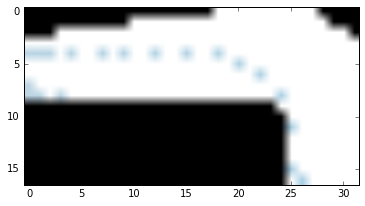

In [167]:
previousState = np.append(mc.start[np.random.randint(mc.start.shape[0])], [0,0])
# previousState = np.append(mc.start[2],(0, 0))
stateInd = 1
episode = np.zeros(shape=(1,7))
while True:
    stateIndex = mc.stateIndex(previousState)
    temp = copy.copy(policyPI[stateIndex])
#             print(stateIndex, temp, np.sum(temp))
    actionIndex = np.random.choice(9,1, p=temp.tolist())[0]
#     possibleActions = mc.possibleActions(previousState[2], previousState[3])
#     if np.sum(possibleActions)==0:
#         print("error: ", possibleActions)
#     notPossibleActionsBool = possibleActions == 0
    
#     temp= copy.copy(mc.Q[stateIndex])
#     temp[notPossibleActionsBool] = -1000000
#     actionIndex = np.argmax(temp)
    
    action = copy.copy(mc.allActions[actionIndex])
#     print(action)
    velocity_x = max(min((previousState[2]+action[0]),5),0)
    velocity_y = max(min((previousState[3]+action[1]),5),0)
    nextState = np.array(((previousState[0] + velocity_x),
                            (previousState[1] + velocity_y), velocity_x, velocity_y))
    nextState = nextState.astype(int)
    intersection = mc.projectedIntersection(previousState, nextState)
    if (intersection == 2):
        nextState = np.append(copy.copy(
                        mc.start[np.random.randint(mc.start.shape[0])]), [0,0])
#         mc.finishState[0,2] = copy.copy(velocity_x)
#         mc.finishState[0,3] = copy.copy(velocity_y)
        reward = -1
#         break
    elif (intersection == 1):
        # episode = np.vstack((episode, np.append(nextState,np.array((0, action[0], action[1])))))
        mc.finishState[0,2] = copy.copy(velocity_x)
        mc.finishState[0,3] = copy.copy(velocity_y)
        break
    else:
        reward = -1

#     print(np.append(previousState,[reward, actionIndex]), episode.shape, stateIndex)

    if episode.shape[0] == 1:
        episode = np.append(previousState, [reward, actionIndex])
        actionValue = mc.Q[stateIndex,actionIndex]
    else:
        episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
    previousState = copy.copy(nextState)
            
# print(np.append(previousState, [reward, actionIndex]), episode.shape)
episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
# print(np.append(previousState,np.array((reward, actionIndex))))
episode =np.vstack((episode, np.append(mc.finishState, [reward, actionIndex])))
path = copy.copy(episode[:,0:2])
print("steps: ", path.shape[0], "totalReard: ", sum(episode[:,4]), "actionValue", actionValue)
colorize_path(mc.map, path, "path.png")
# IM(filename='path.png')
img=mpimg.imread('path.png')
plt.imshow(img)

In [64]:
np.amin(mc.Q)

-11241.0

In [41]:
count

1100001